## Finding the next trendy neighborhood in chicago 

In larger cities, an old and neglected neighborhood can quickly transform into a popular and trendy neighborhood with high real estate demand and a sharp increase in real state prices. If detected early, these areas can be a good real state investment opportunity. Some signs that can show a neighborhood is transforming are an increase in the number of home renovations and new constructions, an increase in the number of resturants and bars in the area, or a decrease in the crime rate.

The goal of this project is to find the next trendy neighborhood using public data available from the City of Chicago Data Portal such as building permits, valid retail food licenses, and crime rates, as well as the historical housing prices in each zip code from Zillow.

In [1]:
import glob, os
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import requests 
import json
from collections import defaultdict
import pickle
import requests
from bs4 import BeautifulSoup
from pandas_profiling import ProfileReport
from sodapy import Socrata
import dill
from geopy.geocoders import Nominatim
import geopy
from ediblepickle import checkpoint
from retrying import retry
import requests
from tqdm import tqdm
from pmdarima import auto_arima
import cloudscraper
from time import sleep
from sklearn.feature_extraction import DictVectorizer


In [2]:
sns.set()

# Historical Housing Price, 1996 to 2020

In [3]:
#reading the housing price data
Housing_price_since1996 = pd.read_csv('All_cities_Monthly_HousingPrice_1996to2020.csv')
Housing_price_since1996 = Housing_price_since1996[Housing_price_since1996.City == 'Chicago']
Housing_price_since1996.drop(['CountyName', 'Metro', 'City', 'State', 'StateName', 'RegionType','SizeRank', 'RegionID'], axis=1, inplace=True)

In [4]:
Housing_price_since1996.rename(columns={'RegionName': 'zipcode'}, inplace=True)
Housing_price_since1996.reset_index(drop=True,inplace=True)
Housing_price_since1996.head(3)

,zipcode,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,...,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30
0,60657,203459.0,203308.0,202913.0,202782.0,202237.0,202415.0,202209.0,202796.0,203655.0,...,473138.0,474705.0,475762.0,475995.0,476428.0,477687.0,479702.0,482493.0,485306.0,488055.0
1,60614,271728.0,271479.0,270979.0,270842.0,270189.0,270275.0,269799.0,270340.0,271380.0,...,608666.0,609279.0,608927.0,608721.0,608756.0,609901.0,611415.0,614273.0,617081.0,620179.0
2,60640,120004.0,119659.0,119308.0,119195.0,118944.0,119065.0,119070.0,119736.0,120564.0,...,304818.0,306382.0,307129.0,307447.0,307954.0,309306.0,311171.0,313906.0,316627.0,319125.0


In [5]:
#all of the zipcodes with housing price information
Housing_price_since1996.zipcode.unique()

array([60657, 60614, 60640, 60647, 60618, 60613, 60625, 60629, 60610,
       60619, 60611, 60617, 60620, 60634, 60628, 60649, 60626, 60622,
       60616, 60615, 60641, 60660, 60637, 60608, 60638, 60639, 60630,
       60643, 60623, 60632, 60605, 60609, 60645, 60654, 60651, 60653,
       60644, 60607, 60612, 60659, 60652, 60631, 60656, 60624, 60601,
       60642, 60655, 60646, 60661, 60633, 60606, 60602, 60603, 60604])

In [6]:
#data cleaning
Housing_price_since1996 = Housing_price_since1996.melt(id_vars='zipcode', value_name='price', var_name='date')
print(Housing_price_since1996.dtypes)
Housing_price_since1996.head()

zipcode      int64
date        object
price      float64
dtype: object


,zipcode,date,price
0,60657,1996-01-31,203459.0
1,60614,1996-01-31,271728.0
2,60640,1996-01-31,120004.0
3,60647,1996-01-31,163786.0
4,60618,1996-01-31,198594.0


In [7]:
#data cleaning
Housing_price_since1996.zipcode = Housing_price_since1996.zipcode.astype(str)
Housing_price_since1996.date = pd.to_datetime(Housing_price_since1996.date, format='%Y-%m-%d')
Housing_price_since1996['year'] = Housing_price_since1996.date.dt.year
Housing_price_yearly = Housing_price_since1996.groupby(['year', 'zipcode'])['price'].mean().reset_index()
Housing_price_yearly

,year,zipcode,price
0,1996,60601,190835.583333
1,1996,60602,203855.583333
2,1996,60603,NaN
3,1996,60604,NaN
4,1996,60605,174092.000000
...,...,...,...
1345,2020,60656,327164.545455
1346,2020,60657,478298.272727
1347,2020,60659,353244.818182
1348,2020,60660,262752.727273


<AxesSubplot:xlabel='price', ylabel='Count'>

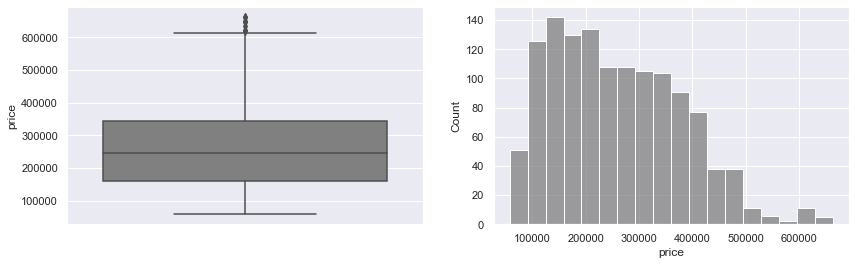

In [8]:
#housing price distribution
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,4))
sns.boxplot(y= 'price',data=Housing_price_yearly.dropna(), color='gray',ax=ax1)
sns.histplot(x= 'price', data=Housing_price_yearly.dropna(),color='gray', ax=ax2)
#price distribution has skewed distribution 

In [9]:
# creating a dataframe for each zipcode
dict_df_by_zip = defaultdict(str)
for zipcode, df in Housing_price_yearly.groupby('zipcode'):
    dict_df_by_zip[zipcode] = df
dict_df_by_zip['60601'].head(3)

,year,zipcode,price
0,1996,60601,190835.583333
54,1997,60601,193921.166667
108,1998,60601,202341.250000


### missing values

In [10]:
# zipcodes with missing data
Housing_price_yearly[Housing_price_yearly.price.isna()].zipcode.unique()

array(['60603', '60604', '60623', '60624', '60651', '60661'], dtype=object)

In [11]:
#approximating the missing data for zipcodes based on other zipcodes data in the same neighborhood

In [12]:
missing_values_60623 = Housing_price_yearly.loc[Housing_price_yearly.zipcode.str.contains('60644|60609', regex=True)].groupby('year').mean().round()
missing_values_60603 = Housing_price_yearly.loc[Housing_price_yearly.zipcode.str.contains('60611', regex=True)].groupby('year').mean().round()+200000
missing_values_60604 = Housing_price_yearly.loc[Housing_price_yearly.zipcode.str.contains('60601|60602|60606', regex=True)].groupby('year').mean().round()
missing_values_60624 =Housing_price_yearly.loc[Housing_price_yearly.zipcode.str.contains('60612|60644', regex=True)].groupby('year').mean().round()
missing_values_60651 = Housing_price_yearly.loc[Housing_price_yearly.zipcode.str.contains('60644', regex=True)].groupby('year').mean().round()-5000
missing_values_60661 = Housing_price_yearly.loc[Housing_price_yearly.zipcode.str.contains('60607', regex=True)].groupby('year').mean().round()

In [13]:
dict_df_by_zip['60603'] = dict_df_by_zip['60603'].set_index('year').fillna(missing_values_60603).reset_index()
dict_df_by_zip['60604'] = dict_df_by_zip['60604'].set_index('year').fillna(missing_values_60604).reset_index()
dict_df_by_zip['60623'] = dict_df_by_zip['60623'].set_index('year').fillna(missing_values_60623).reset_index()
dict_df_by_zip['60624'] = dict_df_by_zip['60624'].set_index('year').fillna(missing_values_60624).reset_index()
dict_df_by_zip['60651'] = dict_df_by_zip['60651'].set_index('year').fillna(missing_values_60651).reset_index()
dict_df_by_zip['60661'] = dict_df_by_zip['60661'].set_index('year').fillna(missing_values_60661).reset_index()
dict_df_by_zip['60653'] = dict_df_by_zip['60653'].fillna(method='bfill')

In [14]:
def get_yearly_price_df(adict):
    yearly_df_by_zip = defaultdict(str)
    for key in dict_df_by_zip:
        yearly_df_by_zip[key]  = dict_df_by_zip[key].set_index('year')
    return yearly_df_by_zip
df_price_by_zipcode_yearly = get_yearly_price_df(dict_df_by_zip)        

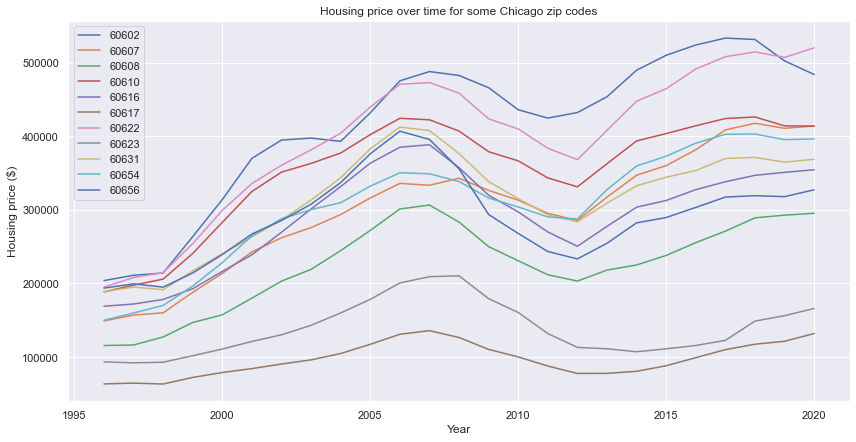

In [15]:
#plotting housing price over time for given zipcodes
def plot_price(adict, selected_zipcodes):
    fig, ax = plt.subplots(figsize=(14,7))
    for zipcode in selected_zipcodes:
        ax.plot(adict[zipcode].price, label=zipcode)
        plt.legend()
    plt.ylabel('Housing price ($)')
    plt.xlabel('Year')
    plt.title('Housing price over time for some Chicago zip codes')
    
selected_zipcodes = ['60602','60607', '60608', '60610', '60616', '60617','60622', '60623','60631', '60654', '60656']
plot_price(df_price_by_zipcode_yearly,selected_zipcodes)

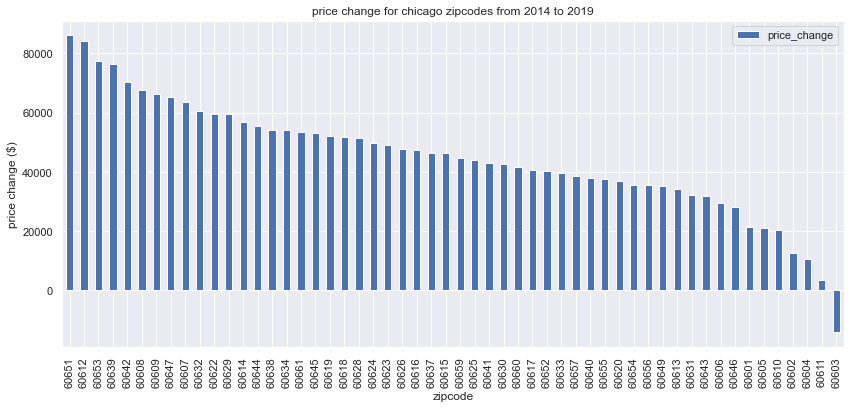

In [16]:
# plotting housing price change for all zipcodes: price at the end of 2019 - price at the beginning of 2014

def get_price_change(init_date = 2014, end_date = 2019):
    price_change = []
    for zipcode in Housing_price_yearly.zipcode.unique():
        df = df_price_by_zipcode_yearly[zipcode].reset_index()
        zipcode_price_change = df.loc[df.year==end_date, 'price'].values[0] - df.loc[df.year==init_date, 'price'].values[0]
        price_change.append((zipcode, zipcode_price_change))
    price_change_df = pd.DataFrame(price_change, columns=['zipcode', 'price_change'])
    price_change_df.sort_values('price_change', ascending=False).plot(x='zipcode',kind='bar', figsize=(14,6))
    plt.title(f'price change for chicago zipcodes from {init_date} to {end_date}')
    plt.ylabel('price change ($)')
    return price_change
price_change = get_price_change()


The plot shows some zipcodes such as 60651, 60612, 60639 had a significant value increase over the 5 year period while other zipcodes such as 60611 and 60604 had much less price increase 

# Consumer price index, 2000 to 2020

value in year_x dollars = value in year_y dollars (CPI_x/CPI_y)

In [17]:
CPI = pd.read_excel('CPI.xlsx', skiprows=11)
CPI.dropna(inplace=True)
monthly_CPI = CPI.drop(['Annual', 'HALF1', 'HALF2'], axis=1).melt(id_vars='Year', value_name='CPI', var_name='month')

In [18]:
monthly_CPI['date'] = pd.to_datetime(monthly_CPI['Year'].astype('str')+','+monthly_CPI['month'])
monthly_CPI= monthly_CPI.drop(['Year', 'month'], axis=1)

In [19]:
monthly_CPI.head()

,CPI,date
0,170.2,2000-01-01
1,178.1,2001-01-01
2,177.9,2002-01-01
3,182.7,2003-01-01
4,185.4,2004-01-01


# Construction and Renovation Permits Data

In [20]:
#getting the data from city of chicago data portal: https://data.cityofchicago.org/
"""
client = Socrata("data.cityofchicago.org", None)
select = 'id, permit_, application_start_date, issue_date, street_number, street_name, community_area, census_tract, ward,latitude,longitude'
results = client.get("ydr8-5enu", select = select, where= "permit_type in ('PERMIT - NEW CONSTRUCTION','PERMIT - WRECKING/DEMOLITION','PERMIT - RENOVATION/ALTERATION')", limit=174534)
# Convert to pandas DataFrame
building = pd.DataFrame.from_records(results)
"""

'\nclient = Socrata("data.cityofchicago.org", None)\nselect = \'id, permit_, application_start_date, issue_date, street_number, street_name, community_area, census_tract, ward,latitude,longitude\'\nresults = client.get("ydr8-5enu", select = select, where= "permit_type in (\'PERMIT - NEW CONSTRUCTION\',\'PERMIT - WRECKING/DEMOLITION\',\'PERMIT - RENOVATION/ALTERATION\')", limit=174534)\n# Convert to pandas DataFrame\nbuilding = pd.DataFrame.from_records(results)\n'

In [21]:
#saving the data 

# with open("building_permit", "wb") as dill_file:
#     dill.dump(building, dill_file)


#reading the data 
with open("building_permit", "rb") as dill_file:
    building_permit = dill.load(dill_file)

In [22]:
building_permit.head(3)

,id,permit_,application_start_date,issue_date,street_number,street_name,community_area,census_tract,ward,latitude,longitude
0,2015693,100276612,2009-03-26T00:00:00.000,2010-06-14T00:00:00.000,5439,DAMEN,61,6117,16,41.794585511,-87.674174892
1,2053303,100293285,2009-06-16T00:00:00.000,2009-07-16T00:00:00.000,2946,HOYNE,5,514,1,41.935473196,-87.680810483
2,3125307,100876352,2020-10-14T00:00:00.000,2020-11-10T00:00:00.000,10000,OHARE,76,980000,41,NaN,NaN


In [23]:
building_permit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174534 entries, 0 to 174533
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   id                      174534 non-null  object
 1   permit_                 174534 non-null  object
 2   application_start_date  174374 non-null  object
 3   issue_date              174534 non-null  object
 4   street_number           174534 non-null  object
 5   street_name             174534 non-null  object
 6   community_area          145676 non-null  object
 7   census_tract            145171 non-null  object
 8   ward                    145640 non-null  object
 9   latitude                174058 non-null  object
 10  longitude               174058 non-null  object
dtypes: object(11)
memory usage: 14.6+ MB


In [24]:
#data cleaning
building_permit.application_start_date = pd.to_datetime(building_permit.application_start_date)
building_permit.issue_date = pd.to_datetime(building_permit.issue_date)
building_permit['year'] = building_permit.application_start_date.dt.year
# building_permit.application_start_date = building_permit.application_start_date - pd.offsets.MonthEnd(0) - pd.offsets.MonthBegin(1)

In [25]:
#looking for data points with missing location information (latitude and longitude)
missing_lat_long = building_permit[(building_permit['latitude'].isna()) | (building_permit['longitude'].isna())]
print(missing_lat_long.shape)
missing_lat_long.head(3)

(476, 12)


,id,permit_,application_start_date,issue_date,street_number,street_name,community_area,census_tract,ward,latitude,longitude,year
2,3125307,100876352,2020-10-14,2020-11-10,10000,OHARE,76,980000,41,NaN,NaN,2020.0
3,3110706,100864812,2020-04-21,2020-07-01,10000,OHARE,76,980000,41,NaN,NaN,2020.0
23,3092615,100854411,2020-02-24,2020-05-01,10000,OHARE,76,980000,41,NaN,NaN,2020.0


In [26]:
#from 174534 entries the location data were missing for 476 entries. Removed the data with missing location
building_lat_long = building_permit[(building_permit['latitude'].notnull()) & (building_permit['longitude'].notnull())]
building_lat_long.head(3)

,id,permit_,application_start_date,issue_date,street_number,street_name,community_area,census_tract,ward,latitude,longitude,year
0,2015693,100276612,2009-03-26,2010-06-14,5439,DAMEN,61,6117,16,41.794585511,-87.674174892,2009.0
1,2053303,100293285,2009-06-16,2009-07-16,2946,HOYNE,5,514,1,41.935473196,-87.680810483,2009.0
4,2068267,100300715,2009-07-24,2009-08-31,2715,KENMORE,7,704,32,41.930475362,-87.654962896,2009.0


In [27]:
building_lat_long.dtypes

id                                object
permit_                           object
application_start_date    datetime64[ns]
issue_date                datetime64[ns]
street_number                     object
street_name                       object
community_area                    object
census_tract                      object
ward                              object
latitude                          object
longitude                         object
year                             float64
dtype: object

In [28]:
building_lat_long.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174058 entries, 0 to 174533
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   id                      174058 non-null  object        
 1   permit_                 174058 non-null  object        
 2   application_start_date  173898 non-null  datetime64[ns]
 3   issue_date              174058 non-null  datetime64[ns]
 4   street_number           174058 non-null  object        
 5   street_name             174058 non-null  object        
 6   community_area          145297 non-null  object        
 7   census_tract            144810 non-null  object        
 8   ward                    145276 non-null  object        
 9   latitude                174058 non-null  object        
 10  longitude               174058 non-null  object        
 11  year                    173898 non-null  float64       
dtypes: datetime64[ns](2), float64(

### Getting zipcode from lat, long data  

In [29]:
#getting the zipcode based on lat and long for each entry
"""def find_zipcode_local(df):
    zipcode = []
    for row in tqdm(df.itertuples()):
        response = requests.get('http://localhost:3000/?lat={}&long={}'.format(row.latitude, row.longitude))
        zipcode.append(response.json()['zip'])
    return zipcode
building_zipcodes = find_zipcode_local(building_lat_long)"""
#saved the zipcode data
"""with open('building_zipcodes', 'wb') as dill_file:
    dill.dump(building_zipcodes, dill_file)"""

"with open('building_zipcodes', 'wb') as dill_file:\n    dill.dump(building_zipcodes, dill_file)"

In [30]:
#reading the zipcode data and assigning it to the zipcode column 
with open('building_zipcodes', 'rb') as f:
    construction_zipcode = dill.load(f)
building_lat_long['zipcode'] = construction_zipcode

<ipython-input-30-006a6e8d731a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  building_lat_long['zipcode'] = construction_zipcode


In [31]:
#confirm that missing zipcodes are located outside of chicago
building_lat_long = building_lat_long.dropna(subset=['application_start_date'])
building_lat_long[building_lat_long.zipcode.isna()].head()

,id,permit_,application_start_date,issue_date,street_number,street_name,community_area,census_tract,ward,latitude,longitude,year,zipcode
1169,1648980,100093725,2006-02-02,2006-02-02,11601,TOUHY,NaN,NaN,NaN,42.008536401,-87.914428439,2006.0,None
1809,1668118,100105612,2006-04-20,2006-04-21,11601,TOUHY,NaN,NaN,NaN,42.008536401,-87.914428439,2006.0,None
3281,1722992,100136817,2006-09-13,2006-09-13,11601,TOUHY,NaN,NaN,NaN,42.008536401,-87.914428439,2006.0,None
3282,1723010,100136826,2006-09-13,2006-09-13,11601,TOUHY,NaN,NaN,NaN,42.008536401,-87.914428439,2006.0,None
3283,1723017,100136828,2006-09-13,2006-09-13,11601,TOUHY,NaN,NaN,NaN,42.008536401,-87.914428439,2006.0,None


In [32]:
#cleaning the data
building_df = building_lat_long.dropna(subset=['latitude', 'longitude'], axis=0).copy()
building_df.rename(columns={'permit_':'permit'}, inplace=True)
building_df['year'] = building_df['year'].astype(int)

In [33]:
# building_df.to_csv('building_df')

In [34]:
# Finding yearly construction count per zipcode
df_construction_by_zipcode_yearly = defaultdict(str)
yearly_building_permits = building_df.groupby(['year', 'zipcode'])['permit'].count().reset_index()
yearly_building_permits['construction_count'] = yearly_building_permits.permit
yearly_building_permits.drop(['permit'], axis=1, inplace=True)
for zipcode, df in yearly_building_permits.groupby('zipcode'):
    df_construction_by_zipcode_yearly[zipcode]= df.reset_index(drop=True).set_index('year')
df_construction_by_zipcode_yearly['60628'].head()

,zipcode,construction_count
year,,
2005,60628,7
2006,60628,149
2007,60628,203
2008,60628,205
2009,60628,152


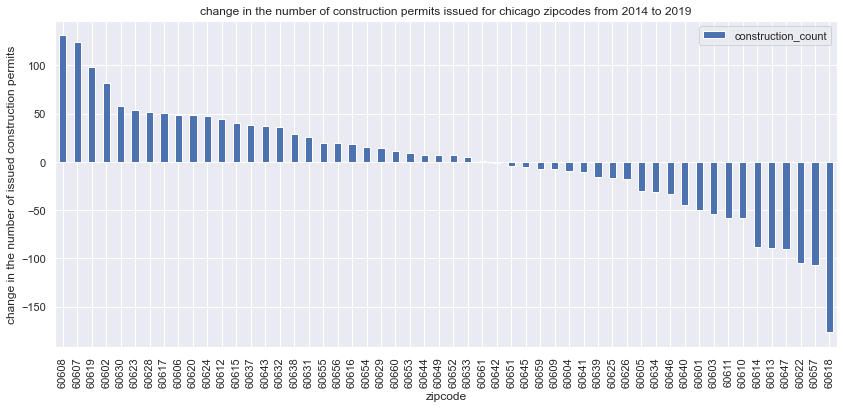

In [35]:
def get_construction_change(init_date = 2014, end_date = 2019):
    construction_change = []
    for zipcode in Housing_price_yearly.zipcode.unique():
        df = df_construction_by_zipcode_yearly[zipcode]
        zipcode_construction_change = df.loc[df.index ==end_date, 'construction_count'].sum() - df.loc[df.index ==init_date, 'construction_count'].sum()
        construction_change.append((zipcode, zipcode_construction_change))
    construction_df = pd.DataFrame(construction_change, columns=['zipcode', 'construction_count'])
    construction_df.sort_values('construction_count', ascending=False).plot(x='zipcode',kind='bar', figsize=(14,6))
    plt.title(f'change in the number of construction permits issued for chicago zipcodes from {init_date} to {end_date}')
    plt.ylabel('change in the number of issued construction permits')
    return price_change
construction_change = get_construction_change()

# Issued Restaurants license Data

In [36]:
#getting the issued licenses information from city of chicago data portal: data.cityofchicago.org
"""
client = Socrata("data.cityofchicago.org", None)
results = client.get("r5kz-chrr", select= 'id, legal_name, city, zip_code, ward, license_code, license_description, license_start_date, expiration_date, date_issued', where='license_code=1006',limit=1000000)
# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)"""

#saving the data
"""with open("resturants", "wb") as dill_file:
    dill.dump(results_df, dill_file)  
"""

'with open("resturants", "wb") as dill_file:\n    dill.dump(results_df, dill_file)  \n'

In [37]:
#reading the data
with open('resturants', 'rb') as f:
    restaurants = dill.load(f)
restaurants.head(3)   

,id,legal_name,city,zip_code,ward,license_code,license_description,license_start_date,expiration_date,date_issued
0,2437540-20180316,"WARM BELLY BAKERY, LLC",CHICAGO,60607,25,1006,Retail Food Establishment,2018-03-16T00:00:00.000,2021-07-15T00:00:00.000,2018-02-13T00:00:00.000
1,2595174-20200416,HOSPITALITY 201 LLC,CHICAGO,60622,1,1006,Retail Food Establishment,2020-04-16T00:00:00.000,2022-04-15T00:00:00.000,2020-11-13T00:00:00.000
2,2359449-20201216,"CO CO VIETNAMESE SANDWICHES, INC.",CHICAGO,60640,47,1006,Retail Food Establishment,2020-12-16T00:00:00.000,2022-12-15T00:00:00.000,2020-11-13T00:00:00.000


In [38]:
#cleaning the data
restaurants.license_start_date = pd.to_datetime(restaurants.license_start_date)
restaurants.expiration_date = pd.to_datetime(restaurants.expiration_date)
restaurants.date_issued = pd.to_datetime(restaurants.date_issued)
restaurants.dropna(subset=['license_start_date', 'zip_code'], inplace=True)

In [39]:
#looking for missing values
restaurants.isna().any()

id                     False
legal_name             False
city                   False
zip_code               False
ward                    True
license_code           False
license_description    False
license_start_date     False
expiration_date        False
date_issued            False
dtype: bool

In [40]:
#extracting restaurants unique license number from the id column 
id_df = restaurants.id.str.extract('(\d+)-')
id_df.rename(columns = {0:'restaurant_id'}, inplace=True)
id_df['start_year'] = restaurants.license_start_date.dt.year.astype(int)
id_df['end_year'] = restaurants.expiration_date.dt.year.astype(int)
id_df['zipcode'] = restaurants.zip_code
id_df.head(3)

,restaurant_id,start_year,end_year,zipcode
0,2437540,2018,2021,60607
1,2595174,2020,2022,60622
2,2359449,2020,2022,60640


In [41]:
#finding the time period for which restaurants had valid license at each zipcode 
id_year_zip_df = id_df.groupby(['restaurant_id','zipcode']).agg({'start_year':min, 'end_year':max})
id_year_zip_df.head()

,,start_year,end_year
restaurant_id,zipcode,,
100,60603,2002,2006
1000049,60607,2002,2018
1000125,60622,2002,2016
1000160,60655,2002,2004
1000200,60639,2002,2007


In [42]:
#adding each year from 1996 to 2024 as a column to the dataframe 
id_year_zip_df
for i in range(1996, 2024):
    year = str(i)
    id_year_zip_df[year] = 0
id_year_zip_df = id_year_zip_df.reset_index().sort_values('start_year')
id_year_zip_df.head()

,restaurant_id,zipcode,start_year,end_year,1996,1997,1998,1999,2000,2001,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
35340,56513,60607,1996,1997,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35261,55401,60631,1996,1997,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32525,31870,60639,1996,1997,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35030,52789,46410,1996,1997,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35297,55920,60643,1996,1997,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
#for each year that the business was open, 1 is placed in the dataframe for that business/year
def add_year_info(row):
    for year in range(row['start_year'], row['end_year']+1):
        row[str(year)] = 1
    return row

In [44]:
# is there a more efficient way to do this?
id_year_zip_df = id_year_zip_df.apply(add_year_info, axis=1)
id_year_zip_df.loc[id_year_zip_df.zipcode=='60607'].head()

,restaurant_id,zipcode,start_year,end_year,1996,1997,1998,1999,2000,2001,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
35340,56513,60607,1996,1997,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1217,1140774,60607,2001,2022,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,0
1229,1141204,60607,2001,2003,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
36751,75178,60607,2001,2002,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1409,1144650,60607,2001,2017,0,0,0,0,0,1,...,1,1,1,1,0,0,0,0,0,0


In [45]:
#finding the total number of issued licenses for each zipcode for each year
df_resturant_info = id_year_zip_df.drop(['restaurant_id', 'start_year', 'end_year'], axis=1).copy()
restaurant_df = df_resturant_info.melt(id_vars='zipcode', value_name='restaurant_count', var_name='year')
restaurant_df = restaurant_df.groupby(['year', 'zipcode'])['restaurant_count'].sum().reset_index()
restaurant_df.year = restaurant_df.year.astype(int)
restaurant_df.head()

,year,zipcode,restaurant_count
0,1996,11572,0
1,1996,46218,0
2,1996,46322,0
3,1996,46410,1
4,1996,60007,0


In [46]:
restaurant_df.restaurant_count = restaurant_df.restaurant_count.astype(float)

In [47]:
restaurant_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2688 entries, 0 to 2687
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   year              2688 non-null   int64  
 1   zipcode           2688 non-null   object 
 2   restaurant_count  2688 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 63.1+ KB


In [48]:
restaurant_df.to_csv('restaurant_df', index=False)

<AxesSubplot:xlabel='year'>

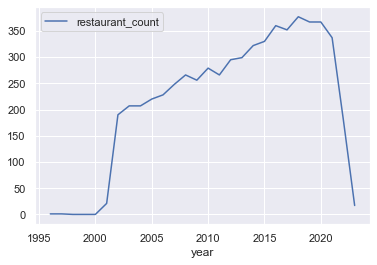

In [49]:
#finding yearly count of valid restaurants licenses for each zipcode
df_restaurants_by_zipcode_yearly = defaultdict(str)
for zipcode, df in restaurant_df.groupby('zipcode'):
    df_restaurants_by_zipcode_yearly[zipcode] = df.reset_index(drop=True).set_index('year')
df_restaurants_by_zipcode_yearly['60607'].plot()

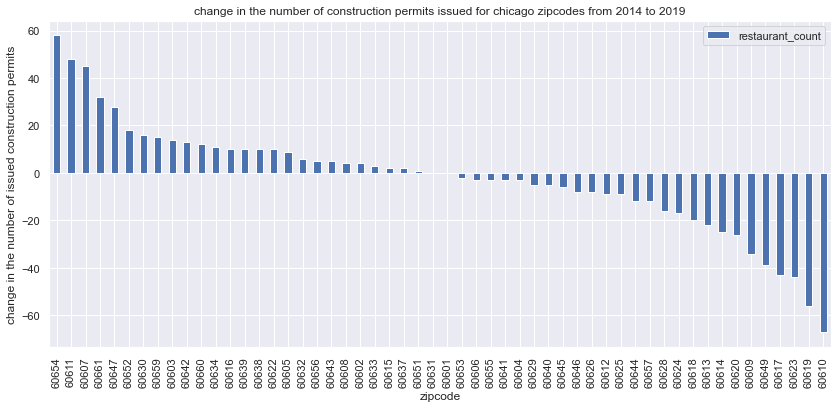

In [50]:
def get_restaurant_change(init_date = 2014, end_date = 2019):
    restaurant_change = []
    for zipcode in Housing_price_yearly.zipcode.unique():
        df = df_restaurants_by_zipcode_yearly[zipcode]
        zipcode_restaurant_change = df.loc[df.index ==end_date, 'restaurant_count'].sum() - df.loc[df.index ==init_date, 'restaurant_count'].sum()
        restaurant_change.append((zipcode, zipcode_restaurant_change))
    restaurant_df = pd.DataFrame(restaurant_change, columns=['zipcode', 'restaurant_count'])
    restaurant_df.sort_values('restaurant_count', ascending=False).plot(x='zipcode',kind='bar', figsize=(14,6))
    plt.title(f'change in the number of construction permits issued for chicago zipcodes from {init_date} to {end_date}')
    plt.ylabel('change in the number of issued construction permits')
    return restaurant_change
restaurant_change = get_restaurant_change()

# Crime data

In [51]:
#getting the crime data from city of chicago open portal:  data.cityofchicago.org
"""client = Socrata("data.cityofchicago.org", None)
select = 'id, date, primary_type, description, location_description, arrest, domestic, year, latitude, longitude'
results = client.get("ijzp-q8t2",select=select, limit=7301707)
# Convert to pandas DataFrame
crime_results = pd.DataFrame.from_records(results)"""

#saving the data 
"""with open("chicago_crime_2001_2020", "wb") as dill_file:
    dill.dump(crime_results, dill_file)"""

'with open("chicago_crime_2001_2020", "wb") as dill_file:\n    dill.dump(crime_results, dill_file)'

In [52]:
#reading the data 
with open("chicago_crime_2001_2020", "rb") as f:
    crime= dill.load(f)
crime.head()

,id,date,primary_type,description,location_description,arrest,domestic,year,latitude,longitude
0,10224738,2015-09-05T13:30:00.000,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,2015,41.815117282,-87.669999562
1,10224739,2015-09-04T11:30:00.000,THEFT,POCKET-PICKING,CTA BUS,False,False,2015,41.895080471,-87.765400451
2,11646166,2018-09-01T00:01:00.000,THEFT,OVER $500,RESIDENCE,False,True,2018,NaN,NaN
3,10224740,2015-09-05T12:45:00.000,NARCOTICS,POSS: HEROIN(BRN/TAN),SIDEWALK,True,False,2015,41.937405765,-87.716649687
4,10224741,2015-09-05T13:00:00.000,ASSAULT,SIMPLE,APARTMENT,False,True,2015,41.881903443,-87.755121152


In [53]:
crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7301707 entries, 0 to 7301706
Data columns (total 10 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   id                    object
 1   date                  object
 2   primary_type          object
 3   description           object
 4   location_description  object
 5   arrest                bool  
 6   domestic              bool  
 7   year                  object
 8   latitude              object
 9   longitude             object
dtypes: bool(2), object(8)
memory usage: 459.6+ MB


In [54]:
#dropping data entries for which the location data (lat and long) were missing
# crime.drop(['date', 'location_description'], axis=1, inplace=True)
crime_df = crime[(crime.latitude.notnull()) & (crime.longitude.notnull())]
crime_df['year'] = crime_df.year.astype(int)
crime_df.head()

<ipython-input-54-c2a6c1d2d734>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_df['year'] = crime_df.year.astype(int)


,id,date,primary_type,description,location_description,arrest,domestic,year,latitude,longitude
0,10224738,2015-09-05T13:30:00.000,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,2015,41.815117282,-87.669999562
1,10224739,2015-09-04T11:30:00.000,THEFT,POCKET-PICKING,CTA BUS,False,False,2015,41.895080471,-87.765400451
3,10224740,2015-09-05T12:45:00.000,NARCOTICS,POSS: HEROIN(BRN/TAN),SIDEWALK,True,False,2015,41.937405765,-87.716649687
4,10224741,2015-09-05T13:00:00.000,ASSAULT,SIMPLE,APARTMENT,False,True,2015,41.881903443,-87.755121152
5,10224742,2015-09-05T10:55:00.000,BURGLARY,FORCIBLE ENTRY,RESIDENCE,False,False,2015,41.744378879,-87.658430635


In [55]:
#finding the zipcode from lat and long information
"""
def find_zipcode_local(lat, long):
    response = requests.get('http://localhost:3000/?lat={}&long={}'.format(lat,long))
    zipcode = response.json()['zip']
    return zipcode

lat = list(crime_df.latitude)
long = list(crime_df.longitude)
results = []
for i in tqdm(range(len(lat))):
    results.append(find_zipcode_local(lat[i], long[i]))
"""
"""with open("crime_zipcode", "wb") as dill_file:
    dill.dump(results, dill_file)"""

'with open("crime_zipcode", "wb") as dill_file:\n    dill.dump(results, dill_file)'

In [56]:
#saving the zipcode data
"""with open("crime_data_zipcode_backup.txt", "wb") as fp:
    pickle.dump(results, fp)"""

'with open("crime_data_zipcode_backup.txt", "wb") as fp:\n    pickle.dump(results, fp)'

In [57]:
#reading the zipcode data and assign it to the zipcode column of the crime dataframe
with open("crime_zipcode", "rb") as f:
    crime_zipcode_data =dill.load(f)
crime_df['zipcode'] = crime_zipcode_data
crime_df = crime_df.dropna(subset=['zipcode'], axis=0)
crime_df.head()

<ipython-input-57-049c6eb613ca>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_df['zipcode'] = crime_zipcode_data


,id,date,primary_type,description,location_description,arrest,domestic,year,latitude,longitude,zipcode
0,10224738,2015-09-05T13:30:00.000,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,2015,41.815117282,-87.669999562,60609
1,10224739,2015-09-04T11:30:00.000,THEFT,POCKET-PICKING,CTA BUS,False,False,2015,41.895080471,-87.765400451,60651
3,10224740,2015-09-05T12:45:00.000,NARCOTICS,POSS: HEROIN(BRN/TAN),SIDEWALK,True,False,2015,41.937405765,-87.716649687,60618
4,10224741,2015-09-05T13:00:00.000,ASSAULT,SIMPLE,APARTMENT,False,True,2015,41.881903443,-87.755121152,60644
5,10224742,2015-09-05T10:55:00.000,BURGLARY,FORCIBLE ENTRY,RESIDENCE,False,False,2015,41.744378879,-87.658430635,60620


In [58]:
# One Hot enocode crime type in the primary_type column, keeping some crime types together as a group.
def get_crime_type(row):
    crime_type_dict = defaultdict(str)
    if type(row) == np.ndarray:
        for i in row:
            i = str(i)
            if i in ('CRIM SEXUAL ASSAULT', 'CRIMINAL SEXUAL ASSAULT', 'SEX OFFENSE','STALKING', 'PROSTITUTION'):
                crime_type_dict['SEX OFFENSE']=1
            elif i in ('PUBLIC INDECENCY','PUBLIC PEACE VIOLATION', 'RITUALISM', 'OBSCENITY'):
                crime_type_dict['PUBLIC INDECENCY']=1
            elif i in ('OTHER OFFENSE', 'NON-CRIMINAL (SUBJECT SPECIFIED)','NON - CRIMINAL', 'NON-CRIMINAL','INTERFERENCE WITH PUBLIC OFFICER', 'INTIMIDATION'):
                crime_type_dict['OTHER']=1
            elif i in ('OTHER NARCOTIC VIOLATION', 'NARCOTICS'): 
                crime_type_dict['NARCOTICS']=1

            
            else:
                crime_type_dict[i]=1
    if type(row) == str:
        if row in ('CRIM SEXUAL ASSAULT', 'CRIMINAL SEXUAL ASSAULT', 'SEX OFFENSE','STALKING', 'PROSTITUTION'):
            crime_type_dict['SEX OFFENSE']=1
        elif row in ('PUBLIC INDECENCY','PUBLIC PEACE VIOLATION', 'RITUALISM', 'OBSCENITY'):
            crime_type_dict['PUBLIC INDECENCY']=1
        elif row in ('OTHER OFFENSE', 'NON-CRIMINAL (SUBJECT SPECIFIED)','NON - CRIMINAL', 'NON-CRIMINAL','INTERFERENCE WITH PUBLIC OFFICER', 'INTIMIDATION'):
            crime_type_dict['OTHER']=1
        elif row in ('OTHER NARCOTIC VIOLATION', 'NARCOTICS'): 
            crime_type_dict['NARCOTICS']=1 
        else:
            crime_type_dict[row]=1
    return crime_type_dict
        

In [59]:
dict_vectorizer = DictVectorizer(sparse=False)
crime_types = dict_vectorizer.fit_transform(crime_df.primary_type.apply(get_crime_type))
crime_type_df = pd.DataFrame(crime_types, columns = dict_vectorizer.get_feature_names())
crime_type_df.head()

,ARSON,ASSAULT,BATTERY,BURGLARY,CONCEALED CARRY LICENSE VIOLATION,CRIMINAL DAMAGE,CRIMINAL TRESPASS,DECEPTIVE PRACTICE,DOMESTIC VIOLENCE,GAMBLING,...,LIQUOR LAW VIOLATION,MOTOR VEHICLE THEFT,NARCOTICS,OFFENSE INVOLVING CHILDREN,OTHER,PUBLIC INDECENCY,ROBBERY,SEX OFFENSE,THEFT,WEAPONS VIOLATION
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
crime_type_df.sum().sort_values(ascending=False)

THEFT                                1513694.0
BATTERY                              1329307.0
CRIMINAL DAMAGE                       825470.0
NARCOTICS                             725955.0
OTHER                                 470622.0
ASSAULT                               460728.0
BURGLARY                              406779.0
MOTOR VEHICLE THEFT                   332858.0
DECEPTIVE PRACTICE                    295175.0
ROBBERY                               272247.0
CRIMINAL TRESPASS                     204563.0
SEX OFFENSE                           127791.0
WEAPONS VIOLATION                      87449.0
PUBLIC INDECENCY                       51470.0
OFFENSE INVOLVING CHILDREN             47910.0
GAMBLING                               14486.0
LIQUOR LAW VIOLATION                   14325.0
ARSON                                  12167.0
HOMICIDE                               10943.0
KIDNAPPING                              6930.0
CONCEALED CARRY LICENSE VIOLATION        703.0
HUMAN TRAFFIC

In [61]:
#adding the crime type data to the rest of the crime df
crime_df_daily = pd.concat((crime_df, crime_type_df),axis=1)
crime_df_daily = crime_df_daily[['year','zipcode','HOMICIDE', 'THEFT', 'BATTERY', 'NARCOTICS','BURGLARY', 'ROBBERY', 'CRIMINAL DAMAGE']]
crime_df_daily.head(3)

,year,zipcode,HOMICIDE,THEFT,BATTERY,NARCOTICS,BURGLARY,ROBBERY,CRIMINAL DAMAGE
0,2015.0,60609,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2015.0,60651,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [62]:
crime_df_daily.sort_values(by='year')

,year,zipcode,HOMICIDE,THEFT,BATTERY,NARCOTICS,BURGLARY,ROBBERY,CRIMINAL DAMAGE
1395949,2001.0,60637,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1282708,2001.0,60634,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1282707,2001.0,60614,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1282706,2001.0,60619,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1282705,2001.0,60612,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
7211632,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7211633,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7211634,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7211635,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
# crime_df_daily = crime_df_daily.to_csv('crime_df_daily',index=False)

In [64]:
# seperating yearly data related to each zipcode and save it as a dataframe in a dictionary
df_crime_by_zipcode_yealy = defaultdict(str)
for zipcode, df in crime_df_daily.groupby('zipcode'):
    temp_df = df.groupby('year').sum()
#     try:
#         zipcode_Population = zipcode_extra_info.loc[zipcode_extra_info.zipcode==zipcode, 'Population'].values[0]
#         temp_df = temp_df/zipcode_Population
#     except:
#         temp_df = temp_df*0
    temp_df['zipcode'] = zipcode
    df_crime_by_zipcode_yealy[zipcode] = temp_df
df_crime_by_zipcode_yealy['60608'].head()


,HOMICIDE,THEFT,BATTERY,NARCOTICS,BURGLARY,ROBBERY,CRIMINAL DAMAGE,zipcode
year,,,,,,,,
2001.0,21.0,2493.0,2346.0,1324.0,692.0,438.0,1369.0,60608
2002.0,93.0,2219.0,2104.0,1114.0,598.0,407.0,1289.0,60608
2003.0,16.0,2365.0,2201.0,1311.0,593.0,389.0,1363.0,60608
2004.0,12.0,2478.0,2134.0,1414.0,597.0,430.0,1358.0,60608
2005.0,19.0,2053.0,2045.0,1368.0,602.0,380.0,1329.0,60608


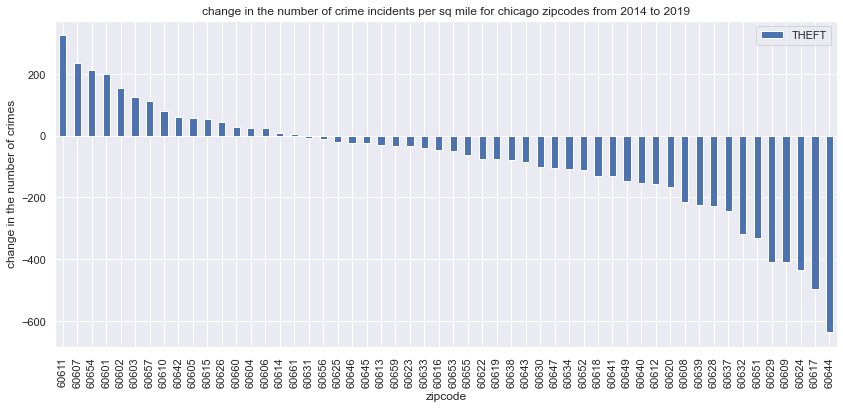

In [65]:
def get_crime_change(init_date = 2014, end_date = 2019):
    crime_change = []
    for zipcode in Housing_price_yearly.zipcode.unique():
        df = df_crime_by_zipcode_yealy[zipcode]
        zipcode_crime_change = df.loc[df.index ==end_date, 'THEFT'].sum() - df.loc[df.index ==init_date, 'THEFT'].sum()
        crime_change.append((zipcode, zipcode_crime_change))
    crime_df = pd.DataFrame(crime_change, columns=['zipcode', 'THEFT'])
    crime_df.sort_values('THEFT', ascending=False).plot(x='zipcode',kind='bar', figsize=(14,6))
    plt.title(f'change in the number of crime incidents per sq mile for chicago zipcodes from {init_date} to {end_date}')
    plt.ylabel('change in the number of crimes')
    return crime_change
crime_change = get_crime_change()

# More detailed data on zipcodes 

In [66]:
# getting zipcode data
"""scraper = cloudscraper.create_scraper()
def send_get_data(zipcode):
    res = scraper.get('https://zip-codes.cybo.com/united-states/{}_chicago/'.format(zipcode))
    if res.status_code == 200:
        soup = BeautifulSoup(res.text)
        dict_zipcode = {i.text.replace(' {}'.format(zipcode), ''): i.find_next().text for i in soup.select('td.t-lab')}
        return dict_zipcode
    return None"""

"scraper = cloudscraper.create_scraper()\ndef send_get_data(zipcode):\n    res = scraper.get('https://zip-codes.cybo.com/united-states/{}_chicago/'.format(zipcode))\n    if res.status_code == 200:\n        soup = BeautifulSoup(res.text)\n        dict_zipcode = {i.text.replace(' {}'.format(zipcode), ''): i.find_next().text for i in soup.select('td.t-lab')}\n        return dict_zipcode\n    return None"

In [67]:
#getting zipcode data
"""zipcodes_data_dict = []
zipcodes_list = []
for zipcode in Housing_price_yearly.zipcode.unique():
    sleep(1)
    try:
        zipcodes_data_dict.append(send_get_data(zipcode))
        zipcodes_list.append(zipcode)
    except:
        continue"""

'zipcodes_data_dict = []\nzipcodes_list = []\nfor zipcode in Housing_price_yearly.zipcode.unique():\n    sleep(1)\n    try:\n        zipcodes_data_dict.append(send_get_data(zipcode))\n        zipcodes_list.append(zipcode)\n    except:\n        continue'

In [68]:
#saving the data
"""zipcode_extra_info = pd.DataFrame(zipcodes_data_dict, index=zipcodes_list)
with open('zipcode_extra_info', 'wb') as f:
    dill.dump(zipcode_extra_info,f)
    
zipcode_extra_info.to_csv('zipcode_extra_info.csv')"""
#reading the data
zipcode_extra_info = pd.read_csv('zipcode_extra_info.csv')
zipcode_extra_info.head(3)

,Unnamed: 0,Primary City,Area of Zip Code,Population,Male Population,Female Population,Population change from 1975 to 2015,Population change from 2000 to 2015,Median Age,Male Median Age,...,Coordinates,Related Zip Codes,Households in,People per Household,Average House Value,Income per Household,2013 CO2 emissions (tonnes/year),2013 CO2 emissions (tonnes/year) per capita,2013 CO2 emissions intensity (tonnes/mi²/year),Associated Cities
0,60601,Chicago,0.408 sq mi,"10,610","5,251 (49.5%)","5,359 (50.5%)",+23.3%,-6.5%,32.7 years,33.2 years,...,41.88540667843862° / -87.62174544914538°,"60602, 60603, 60604, 60605, 60606, 60607","4,147",1.59,"$267,100","$77,374","266,941 t",25.2 t,NaN,NaN
1,60602,Chicago,"2,477,917 sq ft","1,879",955 (50.8%),924 (49.2%),+22.8%,-6.5%,31.3 years,32.5 years,...,41.88308848601485° / -87.62899398335199°,"60601, 60603, 60604, 60605, 60606, 60607",32,1.95,"$137,500","$23,750","42,081 t",22.4 t,NaN,NaN
2,60603,Chicago,0.139 sq mi,448,219 (48.8%),229 (51.2%),+24.4%,-6.5%,28.3 years,28.7 years,...,41.880214915392706° / -87.62551964691993°,"60601, 60602, 60604, 60605, 60606, 60607",16,1.86,"$162,500","$61,815","8,795 t",19.6 t,NaN,NaN


In [69]:
zipcode_extra_info.drop(['Coordinates', 'Related Zip Codes','Timezone', 'Local Time', 'Area Codes', 'Primary City'], axis=1, inplace=True)
zipcode_extra_info.head(3)

,Unnamed: 0,Area of Zip Code,Population,Male Population,Female Population,Population change from 1975 to 2015,Population change from 2000 to 2015,Median Age,Male Median Age,Female Median Age,Neighborhoods,Households in,People per Household,Average House Value,Income per Household,2013 CO2 emissions (tonnes/year),2013 CO2 emissions (tonnes/year) per capita,2013 CO2 emissions intensity (tonnes/mi²/year),Associated Cities
0,60601,0.408 sq mi,"10,610","5,251 (49.5%)","5,359 (50.5%)",+23.3%,-6.5%,32.7 years,33.2 years,32.2 years,Chicago Loop,"4,147",1.59,"$267,100","$77,374","266,941 t",25.2 t,NaN,NaN
1,60602,"2,477,917 sq ft","1,879",955 (50.8%),924 (49.2%),+22.8%,-6.5%,31.3 years,32.5 years,30.1 years,Chicago Loop,32,1.95,"$137,500","$23,750","42,081 t",22.4 t,NaN,NaN
2,60603,0.139 sq mi,448,219 (48.8%),229 (51.2%),+24.4%,-6.5%,28.3 years,28.7 years,28 years,"Central Chicago, Chicago Loop",16,1.86,"$162,500","$61,815","8,795 t",19.6 t,NaN,NaN


In [70]:
#data cleaning
zipcode_extra_info.rename(columns={'Unnamed: 0': 'zipcode'}, inplace=True)
zipcode_extra_info['Population'] = zipcode_extra_info['Population'].str.replace(',','')
zipcode_extra_info['Area of Zip Code'] = zipcode_extra_info['Area of Zip Code'].str.replace(',','').str.extract('(\S+ )')
zipcode_extra_info['Median Age'] = zipcode_extra_info['Median Age'].str.extract('(\S+ )')
zipcode_extra_info['Income per Household'] = zipcode_extra_info['Income per Household'].str.replace('\$|,','')
zipcode_extra_info['Population change from 1975 to 2015'] = zipcode_extra_info['Population change from 1975 to 2015'].str.replace('\+|%','').astype(float)
zipcode_extra_info['Population change from 2000 to 2015'] = zipcode_extra_info['Population change from 2000 to 2015'].str.replace('%','').astype(float)

In [71]:
#data cleaning
zipcode_extra_info.loc[zipcode_extra_info.zipcode == 60602, 'Area of Zip Code'] = 0.0888
zipcode_extra_info.loc[zipcode_extra_info.zipcode == 60604, 'Area of Zip Code'] = 0.0968
zipcode_extra_info.zipcode = zipcode_extra_info.zipcode.astype('str')
zipcode_extra_info['Area of Zip Code'] = zipcode_extra_info['Area of Zip Code'].astype(float)
zipcode_extra_info['Population'] = zipcode_extra_info['Population'].astype(float)
zipcode_extra_info['Income per Household'] = zipcode_extra_info['Income per Household'].fillna(method='ffill')

In [72]:
# one hot encode Neighborhoods column
def get_neighborhoods(row):
    neighborhoods_dict = defaultdict(str)
    for i in row:
        neighborhoods_dict[i] = 1
    return neighborhoods_dict

In [73]:
neighborhood_dict = zipcode_extra_info['Neighborhoods'].str.split(',').apply(get_neighborhoods)
neigh_dict_vect = DictVectorizer(sparse=False)

neighborhood_df = pd.DataFrame(neigh_dict_vect.fit_transform(neighborhood_dict), columns = neigh_dict_vect.get_feature_names(), index= zipcode_extra_info.zipcode)
neighborhood_df.head()

,Auburn Gresham,Avalon Trails,Avondale,Belmont Central,Belmont Cragin,Belmont Gardens,Belmont Heights,Beverly Woods,Brainerd,Bridgeport,...,Edison Park,Fernwood,Fulton River District,Goose Island,Grand Crossing,Lake View,Lawndale,Little India,Magnificent Mile,Rogers Park
zipcode,,,,,,,,,,,,,,,,,,,,,
60601,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60602,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60603,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60604,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60605,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
#only using the first 50 neighborhoods
neighborhood_df.sum().sort_values(ascending=False)[:50].index

Index([' South Side', ' Humboldt Park', ' West Town', ' Near West Side',
       'Chicago Loop', 'Central Chicago', ' Near North', 'Albany Park',
       'Austin', ' Portage Park', ' Greater Grand Crossing', ' Chicago Loop',
       ' Norwood Park', ' North Park', ' West Ridge', ' Irving Park',
       ' Morgan Park', ' Near North Side', ' Garfield Ridge',
       ' Lake View East', ' West Loop', ' Uptown',
       ' University Village / Little Italy', ' Jefferson Park', ' Gage Park',
       ' Lincoln Square', ' South Deering', ' South Chicago', ' Rogers Park',
       ' Little Village', ' Greektown', ' Illinois Medical District',
       ' O'Hare', ' Longwood Manor', ' Lower West Side', ' McKinley Park',
       ' North Center', ' Hyde Park', ' Near South Side', ' Forest Glen',
       'Bucktown', 'Avalon Park', ' Belmont Cragin', 'Edgewater',
       ' Bridgeport', ' Bronzeville', 'East Garfield Park', 'Bronzeville',
       'Beverly', ' Kenwood'],
      dtype='object')

In [75]:
neighborhood_df.sum().sort_values(ascending=False)[:50]


 South Side                           9.0
 Humboldt Park                        5.0
 West Town                            4.0
 Near West Side                       4.0
Chicago Loop                          4.0
Central Chicago                       3.0
 Near North                           3.0
Albany Park                           3.0
Austin                                3.0
 Portage Park                         3.0
 Greater Grand Crossing               3.0
 Chicago Loop                         3.0
 Norwood Park                         3.0
 North Park                           3.0
 West Ridge                           3.0
 Irving Park                          3.0
 Morgan Park                          3.0
 Near North Side                      2.0
 Garfield Ridge                       2.0
 Lake View East                       2.0
 West Loop                            2.0
 Uptown                               2.0
 University Village / Little Italy    2.0
 Jefferson Park                   

In [76]:
neighborhood_df = neighborhood_df[neighborhood_df.sum().sort_values(ascending=False)[:50].index]

In [77]:
some_zipcode_extra_info = zipcode_extra_info[['zipcode', 'Population', 'Median Age', 'Population change from 1975 to 2015', 'Population change from 2000 to 2015']]

In [78]:
some_zipcode_extra_info = pd.merge(some_zipcode_extra_info.set_index('zipcode'), neighborhood_df, right_index=True, left_index=True)

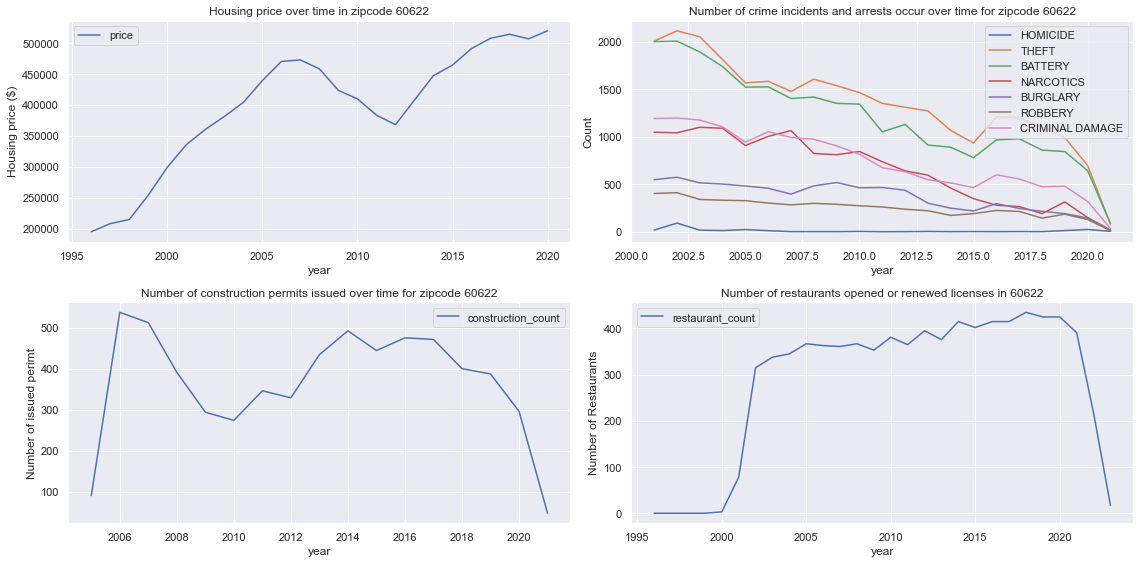

In [79]:
def plot_data_for_zipcode(zipcode):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,8))
    df_price_by_zipcode_yearly[zipcode].plot(ax=ax1, title = 'Housing price over time in zipcode {}'.format(zipcode))
    ax1.set_ylabel('Housing price ($)')
    df_crime_by_zipcode_yealy[zipcode].plot(ax=ax2, title='Number of crime incidents and arrests occur over time for zipcode {}'.format(zipcode))
    ax2.set_ylabel('Count')
    df_construction_by_zipcode_yearly[zipcode].plot(ax=ax3, title ='Number of construction permits issued over time for zipcode {}'.format(zipcode))
    ax3.set_ylabel('Number of issued perimt')
    df_restaurants_by_zipcode_yearly[zipcode].plot(ax=ax4, title='Number of restaurants opened or renewed licenses in {}'.format(zipcode))
    ax4.set_ylabel('Number of Restaurants')
    plt.tight_layout()
plot_data_for_zipcode('60622')

### Merging all data for each zipcode

In [80]:
def get_merged_data_yearly(zipcode):
    merged_df = pd.merge(df_price_by_zipcode_yearly[zipcode], df_crime_by_zipcode_yealy[zipcode].drop(['zipcode'], axis=1), right_index=True, left_index=True, how='inner').merge(df_construction_by_zipcode_yearly[zipcode].drop(['zipcode'], axis=1) ,right_index= True, left_index=True).merge(df_restaurants_by_zipcode_yearly[zipcode].drop(['zipcode'], axis=1), right_index=True, left_index=True)
    merged_df = merged_df[(merged_df.index>=2006) & (merged_df.index<=2019)]
    return merged_df
get_merged_data_yearly('60607').tail()

,zipcode,price,HOMICIDE,THEFT,BATTERY,NARCOTICS,BURGLARY,ROBBERY,CRIMINAL DAMAGE,construction_count,restaurant_count
year,,,,,,,,,,,
2015,60607,359979.833333,3.0,676.0,515.0,240.0,172.0,125.0,315.0,252,330.0
2016,60607,381571.666667,1.0,994.0,782.0,197.0,177.0,162.0,462.0,247,360.0
2017,60607,408474.666667,1.0,949.0,750.0,181.0,197.0,179.0,426.0,346,352.0
2018,60607,417524.083333,0.0,979.0,760.0,201.0,201.0,148.0,432.0,350,377.0
2019,60607,410625.250000,6.0,885.0,773.0,266.0,191.0,150.0,483.0,350,367.0


In [81]:
All_zipcodes_yearly_data_merged = pd.DataFrame()
for zipcode in Housing_price_yearly.zipcode.unique():
    temp_df = get_merged_data_yearly(zipcode)
    All_zipcodes_yearly_data_merged = pd.concat((All_zipcodes_yearly_data_merged, temp_df))


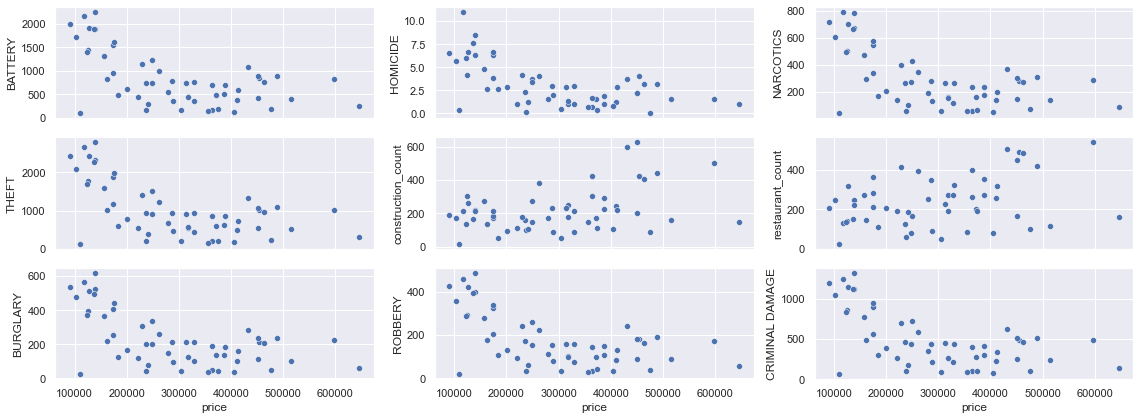

In [82]:
def plot_feature_price_relation(start_year=2014, end_year=2019):
    df = All_zipcodes_yearly_data_merged.loc[(All_zipcodes_yearly_data_merged.index>=start_year) & (All_zipcodes_yearly_data_merged.index<=end_year)]
    grouped_df = df.groupby('zipcode').mean()
    fig, ax = plt.subplots(3,3, figsize = (16,6), sharex=True)
    sns.scatterplot(x='price', y='BATTERY', data=grouped_df, ax=ax[0,0])
    sns.scatterplot(x='price', y='HOMICIDE', data=grouped_df, ax=ax[0,1])
    sns.scatterplot(x='price', y='NARCOTICS', data=grouped_df, ax=ax[0,2])
    sns.scatterplot(x='price', y='THEFT', data=grouped_df, ax=ax[1,0])
    sns.scatterplot(x='price', y='construction_count', data=grouped_df, ax=ax[1,1])
    sns.scatterplot(x='price', y='restaurant_count', data=grouped_df, ax=ax[1,2])
    sns.scatterplot(x='price', y='BURGLARY', data=grouped_df, ax=ax[2,0])
    sns.scatterplot(x='price', y='ROBBERY', data=grouped_df, ax=ax[2,1])
    sns.scatterplot(x='price', y='CRIMINAL DAMAGE', data=grouped_df, ax=ax[2,2])
    plt.tight_layout()
plot_feature_price_relation()

In [83]:
#notes from the plots:

#Battery, NARCOTICS, and Homicide have 1/x ralation with housing price
#Theft has a (x - np.mean(x))**2 relation with housing price
#construction count has an almost x**2 relation with price

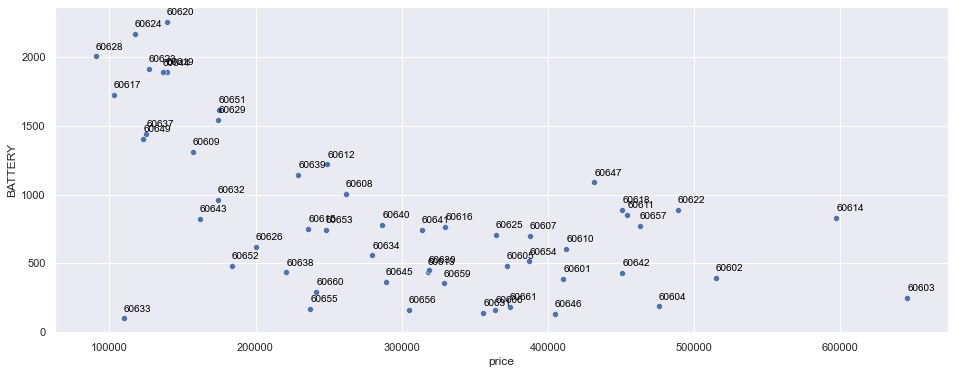

In [84]:
def plot_one_feature_price_relation(x='price', y='BATTERY', start_year=2014, end_year=2019):
    df = All_zipcodes_yearly_data_merged.loc[(All_zipcodes_yearly_data_merged.index>=start_year) & (All_zipcodes_yearly_data_merged.index<=end_year)]
    grouped_df = df.groupby('zipcode').mean()
    plt.figure(figsize=(16,6))
    sns.scatterplot(x=x, y=y, data=grouped_df)
    for zipcode in grouped_df.index:        
        plt.text(x=grouped_df.loc[zipcode,x]+50, y=grouped_df.loc[zipcode,y]+50, s=zipcode, horizontalalignment='left', size='small', color='black', weight='100')
plot_one_feature_price_relation()

In [85]:
#from the above plot we can see that zipcode 60633 is an outlier
get_merged_data_yearly('60608').head()

,zipcode,price,HOMICIDE,THEFT,BATTERY,NARCOTICS,BURGLARY,ROBBERY,CRIMINAL DAMAGE,construction_count,restaurant_count
year,,,,,,,,,,,
2006,60608,301100.916667,13.0,1873.0,1835.0,1228.0,568.0,363.0,1277.0,360,394.0
2007,60608,306468.416667,1.0,1711.0,1566.0,1350.0,483.0,338.0,1112.0,337,391.0
2008,60608,283335.083333,1.0,1760.0,1507.0,883.0,516.0,325.0,1047.0,326,346.0
2009,60608,249957.500000,2.0,1571.0,1309.0,836.0,515.0,314.0,875.0,264,389.0
2010,60608,230831.833333,1.0,1469.0,1367.0,806.0,541.0,314.0,835.0,275,339.0


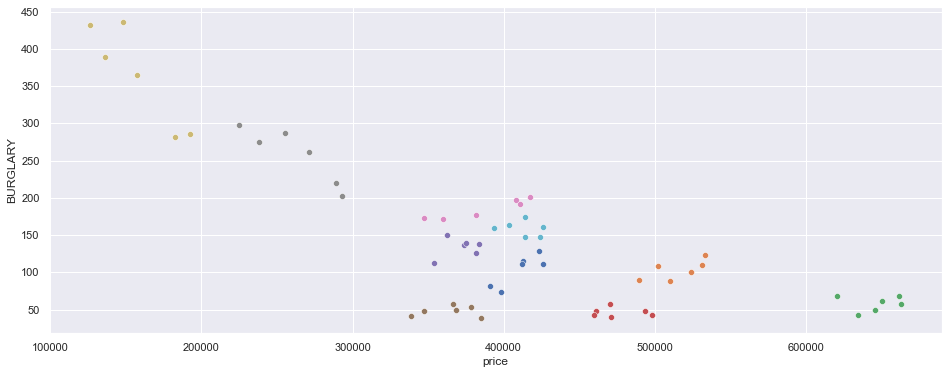

In [86]:
def plot_different_zipcodes_price_feature_realtion(start_year=2014,end_year=2019):
    plt.figure(figsize=(16,6))
    for zipcode in Housing_price_yearly.zipcode.unique()[:10]: 
        sns.scatterplot(x=get_merged_data_yearly(zipcode).price, y=get_merged_data_yearly(zipcode).loc[start_year:end_year,'BURGLARY'])
plot_different_zipcodes_price_feature_realtion()

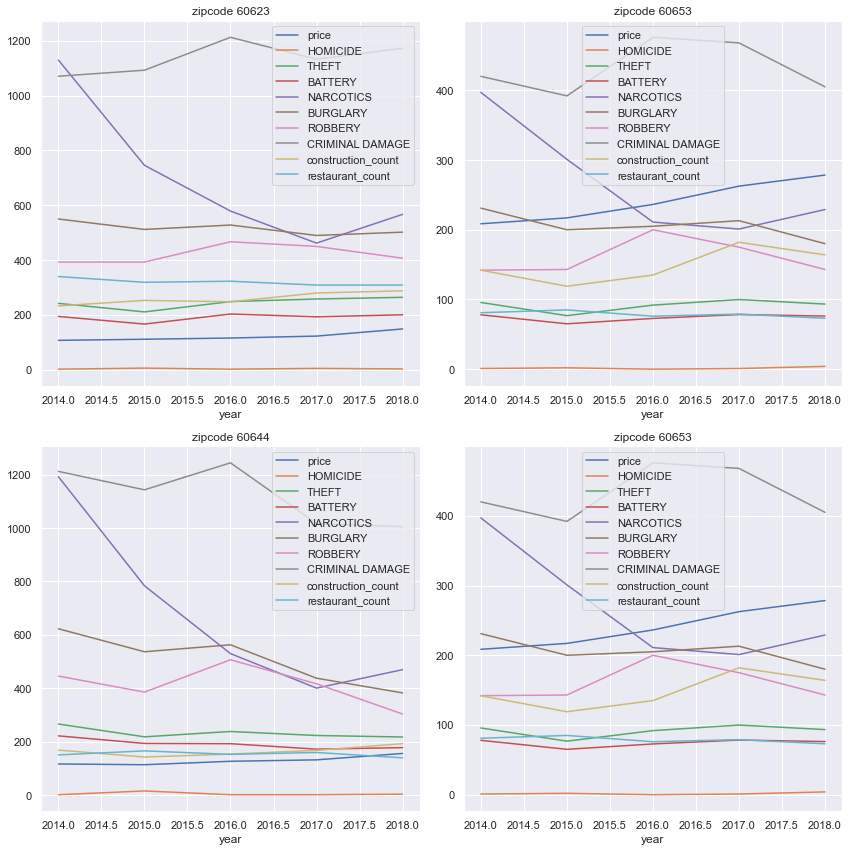

In [87]:
fig, ax = plt.subplots(2,2)
chosen_zipcodes=['60623','60653', '60644', '60653']
idx=0
for i in range(2):
    for j in range(2):
        X_for_plot = (get_merged_data_yearly(chosen_zipcodes[idx])[-6:-1].drop(['zipcode'], axis=1))
        X_for_plot['price'] = X_for_plot['price']/1000
        X_for_plot['HOMICIDE'] = X_for_plot['HOMICIDE']
        X_for_plot['THEFT'] = X_for_plot['THEFT']/10
        X_for_plot['BATTERY'] = X_for_plot['BATTERY']/10
        X_for_plot.plot(figsize=(12,12), ax=ax[i,j]).set( title="zipcode {}".format(chosen_zipcodes[idx]))
        idx+=1

plt.tight_layout()
       

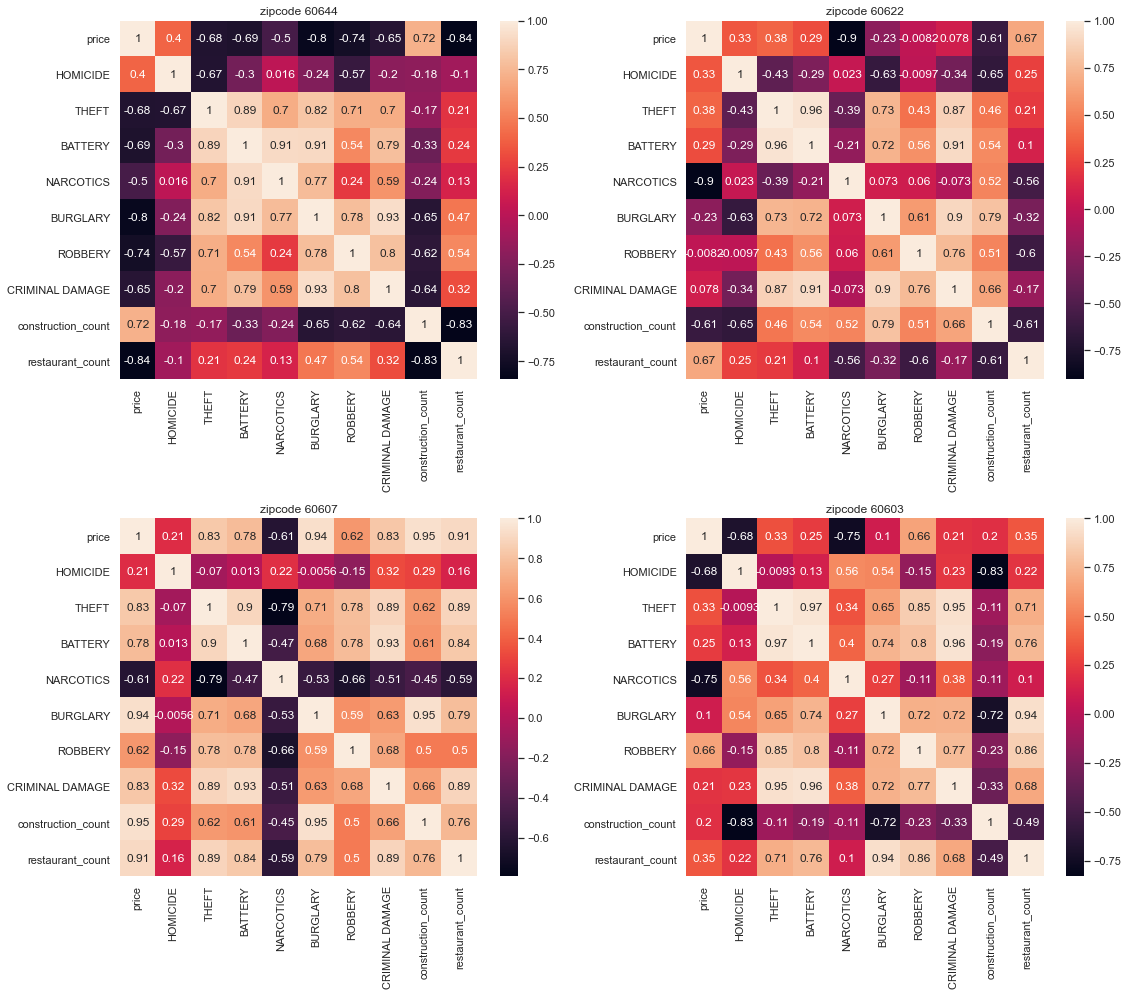

In [88]:
fig, ax = plt.subplots(2,2, figsize=(16,14))
chosen_zipcodes=['60644','60622', '60607', '60603']
idx=0
for i in range(2):
    for j in range(2):
        sns.heatmap(get_merged_data_yearly(chosen_zipcodes[idx]).loc[2014:2019].corr(), annot=True, ax=ax[i,j]).set( title="zipcode {}".format(chosen_zipcodes[idx]))
        idx +=1
plt.tight_layout()
       

In [89]:
# all zipcodes average value
all_zipcodes_df = pd.DataFrame()
for zipcode in Housing_price_yearly.zipcode.unique():
    one_zipcode_df = get_merged_data_yearly(zipcode)
    all_zipcodes_df = pd.concat((all_zipcodes_df, one_zipcode_df))

In [90]:
all_zipcodes_df

,zipcode,price,HOMICIDE,THEFT,BATTERY,NARCOTICS,BURGLARY,ROBBERY,CRIMINAL DAMAGE,construction_count,restaurant_count
year,,,,,,,,,,,
2006,60601,412073.416667,1.0,338.0,307.0,225.0,95.0,61.0,204.0,214,231.0
2007,60601,419326.416667,0.0,322.0,313.0,256.0,106.0,65.0,198.0,232,232.0
2008,60601,408750.250000,0.0,386.0,321.0,212.0,107.0,57.0,225.0,221,229.0
2009,60601,392367.583333,0.0,358.0,311.0,178.0,118.0,67.0,199.0,148,236.0
2010,60601,366400.416667,0.0,339.0,279.0,184.0,103.0,65.0,171.0,152,248.0
...,...,...,...,...,...,...,...,...,...,...,...
2015,60661,352297.833333,0.0,161.0,141.0,67.0,43.0,39.0,95.0,108,188.0
2016,60661,372351.500000,0.0,230.0,179.0,35.0,57.0,54.0,110.0,129,189.0
2017,60661,389386.333333,0.0,242.0,206.0,52.0,42.0,50.0,111.0,113,193.0


<AxesSubplot:>

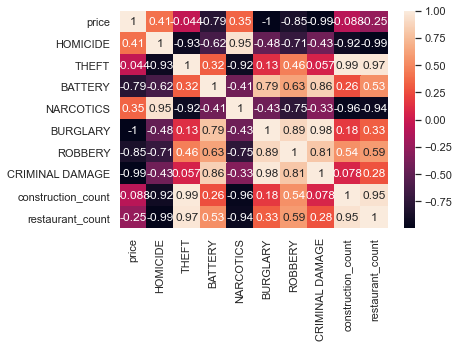

In [91]:
sns.heatmap(all_zipcodes_df.loc[(all_zipcodes_df.index>=2016) & (all_zipcodes_df.index<=2019)].groupby('year').mean().corr(), annot=True)

# Importing unemployment rate, federal interest rates, Chicago GDP,  and Chicago population 

In [92]:
Fed_intrest_rate = pd.read_csv('Federal_effective_rate.csv', skiprows=5, parse_dates=['Time Period'])
Fed_intrest_rate.columns=['date', 'interest_rate']
fed = Fed_intrest_rate.set_index('date')

Unemployment = pd.read_csv('Unemployment_Rate_Chicago-Naperville-Elgin.csv', parse_dates=['DATE'])
Unemployment.columns =['date', 'unemployment_rate']
Unemploy = Unemployment.set_index('date')


In [93]:
gdp_cook = pd.read_csv('GDP_CookCounty.csv', skiprows=4, nrows=3)
gdp_cook.drop(['GeoFips', 'GeoName', 'LineCode'], axis=1, inplace=True)
gdp_cook = gdp_cook.set_index('Description').T
gdp_cook.index = pd.to_datetime(gdp_cook.index)
gdp_cook = gdp_cook.resample('M').mean().interpolate('linear').dropna().round(3)
gdp_cook.columns = ['Real_GDP_dollars', 'GDP_quantity_indexes' ,'Current-dollar GDP']
gdp_cook.index = gdp_cook.index - pd.offsets.MonthEnd(0) - pd.offsets.MonthBegin(1)
gdp_cook.head(3)

,Real_GDP_dollars,GDP_quantity_indexes,Current-dollar GDP
2001-01-01,324316689.0,97.059,2.540582e+08
2001-02-01,324201691.5,97.025,2.544266e+08
2001-03-01,324086694.0,96.990,2.547949e+08


In [94]:
pop_income= pd.read_csv('pop_income_CookCounty.csv', skiprows=4, nrows=3)
pop_income.drop(['GeoFips', 'GeoName', 'LineCode'], axis=1, inplace=True)
pop_income = pop_income.set_index('Description').T
pop_income.index = pd.to_datetime(pop_income.index)
pop_income = pop_income.resample('M').last().interpolate('linear').dropna().round(3)
pop_income.columns = ['Personal_income_dollars', 'Population', 'person_income_per_capita']
pop_income.index = pop_income.index - pd.offsets.MonthEnd(0) - pd.offsets.MonthBegin(1)

In [95]:
chicago_econ_data = pd.merge(fed,Unemploy, how='left', left_index=True, right_index=True)\
                    .merge(gdp_cook[['Current-dollar GDP']], left_index=True, right_index=True)\
                    .merge(pop_income, how='inner', left_index=True, right_index=True)
chicago_econ_data['year'] = chicago_econ_data.index.year
chicago_econ_data_yearly = chicago_econ_data.groupby('year').mean()
chicago_econ_data_yearly.drop(['Population', 'Personal_income_dollars'],axis=1, inplace=True)
chicago_econ_data_yearly.head(3)

,interest_rate,unemployment_rate,Current-dollar GDP,person_income_per_capita
year,,,,
2001,3.887500,5.458333,2.560841e+08,36416.000000
2002,1.666667,6.858333,2.607875e+08,36745.166667
2003,1.127500,6.825000,2.694228e+08,37507.333333


In [96]:
html='<table class="W(100%) M(0)" data-test="historical-prices" data-reactid="33"><thead data-reactid="34"><tr class="C($tertiaryColor) Fz(xs) Ta(end)" data-reactid="35"><th class="Ta(start) W(100px) Fw(400) Py(6px)" data-reactid="36"><span data-reactid="37">Date</span></th><th class="Fw(400) Py(6px)" data-reactid="38"><span data-reactid="39">Open</span></th><th class="Fw(400) Py(6px)" data-reactid="40"><span data-reactid="41">High</span></th><th class="Fw(400) Py(6px)" data-reactid="42"><span data-reactid="43">Low</span></th><th class="Fw(400) Py(6px)" data-reactid="44"><span data-reactid="45">Close*</span></th><th class="Fw(400) Py(6px)" data-reactid="46"><span data-reactid="47">Adj Close**</span></th><th class="Fw(400) Py(6px)" data-reactid="48"><span data-reactid="49">Volume</span></th></tr></thead><tbody data-reactid="50"><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="51"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="52"><span data-reactid="53">May 01, 2021</span></td><td class="Py(10px) Pstart(10px)" data-reactid="54"><span data-reactid="55">33,904.89</span></td><td class="Py(10px) Pstart(10px)" data-reactid="56"><span data-reactid="57">34,221.06</span></td><td class="Py(10px) Pstart(10px)" data-reactid="58"><span data-reactid="59">33,904.89</span></td><td class="Py(10px) Pstart(10px)" data-reactid="60"><span data-reactid="61">34,113.23</span></td><td class="Py(10px) Pstart(10px)" data-reactid="62"><span data-reactid="63">34,113.23</span></td><td class="Py(10px) Pstart(10px)" data-reactid="64"><span data-reactid="65">289,770,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="66"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="67"><span data-reactid="68">Apr 01, 2021</span></td><td class="Py(10px) Pstart(10px)" data-reactid="69"><span data-reactid="70">33,054.58</span></td><td class="Py(10px) Pstart(10px)" data-reactid="71"><span data-reactid="72">34,256.75</span></td><td class="Py(10px) Pstart(10px)" data-reactid="73"><span data-reactid="74">32,985.35</span></td><td class="Py(10px) Pstart(10px)" data-reactid="75"><span data-reactid="76">33,874.85</span></td><td class="Py(10px) Pstart(10px)" data-reactid="77"><span data-reactid="78">33,874.85</span></td><td class="Py(10px) Pstart(10px)" data-reactid="79"><span data-reactid="80">6,810,740,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="81"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="82"><span data-reactid="83">Mar 01, 2021</span></td><td class="Py(10px) Pstart(10px)" data-reactid="84"><span data-reactid="85">31,065.90</span></td><td class="Py(10px) Pstart(10px)" data-reactid="86"><span data-reactid="87">33,259.00</span></td><td class="Py(10px) Pstart(10px)" data-reactid="88"><span data-reactid="89">30,547.53</span></td><td class="Py(10px) Pstart(10px)" data-reactid="90"><span data-reactid="91">32,981.55</span></td><td class="Py(10px) Pstart(10px)" data-reactid="92"><span data-reactid="93">32,981.55</span></td><td class="Py(10px) Pstart(10px)" data-reactid="94"><span data-reactid="95">4,320,731,100</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="96"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="97"><span data-reactid="98">Feb 01, 2021</span></td><td class="Py(10px) Pstart(10px)" data-reactid="99"><span data-reactid="100">30,054.73</span></td><td class="Py(10px) Pstart(10px)" data-reactid="101"><span data-reactid="102">32,009.64</span></td><td class="Py(10px) Pstart(10px)" data-reactid="103"><span data-reactid="104">30,014.97</span></td><td class="Py(10px) Pstart(10px)" data-reactid="105"><span data-reactid="106">30,932.37</span></td><td class="Py(10px) Pstart(10px)" data-reactid="107"><span data-reactid="108">30,932.37</span></td><td class="Py(10px) Pstart(10px)" data-reactid="109"><span data-reactid="110">67,139,200</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="111"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="112"><span data-reactid="113">Jan 01, 2021</span></td><td class="Py(10px) Pstart(10px)" data-reactid="114"><span data-reactid="115">30,627.47</span></td><td class="Py(10px) Pstart(10px)" data-reactid="116"><span data-reactid="117">31,272.22</span></td><td class="Py(10px) Pstart(10px)" data-reactid="118"><span data-reactid="119">29,856.30</span></td><td class="Py(10px) Pstart(10px)" data-reactid="120"><span data-reactid="121">29,982.62</span></td><td class="Py(10px) Pstart(10px)" data-reactid="122"><span data-reactid="123">29,982.62</span></td><td class="Py(10px) Pstart(10px)" data-reactid="124"><span data-reactid="125">81,687,700</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="126"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="127"><span data-reactid="128">Dec 01, 2020</span></td><td class="Py(10px) Pstart(10px)" data-reactid="129"><span data-reactid="130">29,797.50</span></td><td class="Py(10px) Pstart(10px)" data-reactid="131"><span data-reactid="132">30,637.47</span></td><td class="Py(10px) Pstart(10px)" data-reactid="133"><span data-reactid="134">29,599.29</span></td><td class="Py(10px) Pstart(10px)" data-reactid="135"><span data-reactid="136">30,606.48</span></td><td class="Py(10px) Pstart(10px)" data-reactid="137"><span data-reactid="138">30,606.48</span></td><td class="Py(10px) Pstart(10px)" data-reactid="139"><span data-reactid="140">80,983,100</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="141"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="142"><span data-reactid="143">Nov 01, 2020</span></td><td class="Py(10px) Pstart(10px)" data-reactid="144"><span data-reactid="145">26,691.28</span></td><td class="Py(10px) Pstart(10px)" data-reactid="146"><span data-reactid="147">30,116.51</span></td><td class="Py(10px) Pstart(10px)" data-reactid="148"><span data-reactid="149">26,691.28</span></td><td class="Py(10px) Pstart(10px)" data-reactid="150"><span data-reactid="151">29,638.64</span></td><td class="Py(10px) Pstart(10px)" data-reactid="152"><span data-reactid="153">29,638.64</span></td><td class="Py(10px) Pstart(10px)" data-reactid="154"><span data-reactid="155">78,723,800</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="156"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="157"><span data-reactid="158">Oct 01, 2020</span></td><td class="Py(10px) Pstart(10px)" data-reactid="159"><span data-reactid="160">27,940.63</span></td><td class="Py(10px) Pstart(10px)" data-reactid="161"><span data-reactid="162">28,957.90</span></td><td class="Py(10px) Pstart(10px)" data-reactid="163"><span data-reactid="164">26,143.77</span></td><td class="Py(10px) Pstart(10px)" data-reactid="165"><span data-reactid="166">26,501.60</span></td><td class="Py(10px) Pstart(10px)" data-reactid="167"><span data-reactid="168">26,501.60</span></td><td class="Py(10px) Pstart(10px)" data-reactid="169"><span data-reactid="170">84,399,300</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="171"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="172"><span data-reactid="173">Sep 01, 2020</span></td><td class="Py(10px) Pstart(10px)" data-reactid="174"><span data-reactid="175">28,439.61</span></td><td class="Py(10px) Pstart(10px)" data-reactid="176"><span data-reactid="177">29,199.35</span></td><td class="Py(10px) Pstart(10px)" data-reactid="178"><span data-reactid="179">26,537.01</span></td><td class="Py(10px) Pstart(10px)" data-reactid="180"><span data-reactid="181">27,781.70</span></td><td class="Py(10px) Pstart(10px)" data-reactid="182"><span data-reactid="183">27,781.70</span></td><td class="Py(10px) Pstart(10px)" data-reactid="184"><span data-reactid="185">99,739,200</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="186"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="187"><span data-reactid="188">Aug 01, 2020</span></td><td class="Py(10px) Pstart(10px)" data-reactid="189"><span data-reactid="190">26,542.32</span></td><td class="Py(10px) Pstart(10px)" data-reactid="191"><span data-reactid="192">28,733.35</span></td><td class="Py(10px) Pstart(10px)" data-reactid="193"><span data-reactid="194">26,534.38</span></td><td class="Py(10px) Pstart(10px)" data-reactid="195"><span data-reactid="196">28,430.05</span></td><td class="Py(10px) Pstart(10px)" data-reactid="197"><span data-reactid="198">28,430.05</span></td><td class="Py(10px) Pstart(10px)" data-reactid="199"><span data-reactid="200">74,523,600</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="201"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="202"><span data-reactid="203">Jul 01, 2020</span></td><td class="Py(10px) Pstart(10px)" data-reactid="204"><span data-reactid="205">25,879.38</span></td><td class="Py(10px) Pstart(10px)" data-reactid="206"><span data-reactid="207">27,071.33</span></td><td class="Py(10px) Pstart(10px)" data-reactid="208"><span data-reactid="209">25,523.51</span></td><td class="Py(10px) Pstart(10px)" data-reactid="210"><span data-reactid="211">26,428.32</span></td><td class="Py(10px) Pstart(10px)" data-reactid="212"><span data-reactid="213">26,428.32</span></td><td class="Py(10px) Pstart(10px)" data-reactid="214"><span data-reactid="215">82,103,700</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="216"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="217"><span data-reactid="218">Jun 01, 2020</span></td><td class="Py(10px) Pstart(10px)" data-reactid="219"><span data-reactid="220">25,342.99</span></td><td class="Py(10px) Pstart(10px)" data-reactid="221"><span data-reactid="222">27,580.21</span></td><td class="Py(10px) Pstart(10px)" data-reactid="223"><span data-reactid="224">24,843.18</span></td><td class="Py(10px) Pstart(10px)" data-reactid="225"><span data-reactid="226">25,812.88</span></td><td class="Py(10px) Pstart(10px)" data-reactid="227"><span data-reactid="228">25,812.88</span></td><td class="Py(10px) Pstart(10px)" data-reactid="229"><span data-reactid="230">97,104,800</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="231"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="232"><span data-reactid="233">May 01, 2020</span></td><td class="Py(10px) Pstart(10px)" data-reactid="234"><span data-reactid="235">24,120.78</span></td><td class="Py(10px) Pstart(10px)" data-reactid="236"><span data-reactid="237">25,758.79</span></td><td class="Py(10px) Pstart(10px)" data-reactid="238"><span data-reactid="239">22,789.62</span></td><td class="Py(10px) Pstart(10px)" data-reactid="240"><span data-reactid="241">25,383.11</span></td><td class="Py(10px) Pstart(10px)" data-reactid="242"><span data-reactid="243">25,383.11</span></td><td class="Py(10px) Pstart(10px)" data-reactid="244"><span data-reactid="245">79,406,300</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="246"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="247"><span data-reactid="248">Apr 01, 2020</span></td><td class="Py(10px) Pstart(10px)" data-reactid="249"><span data-reactid="250">21,227.38</span></td><td class="Py(10px) Pstart(10px)" data-reactid="251"><span data-reactid="252">24,764.77</span></td><td class="Py(10px) Pstart(10px)" data-reactid="253"><span data-reactid="254">20,735.02</span></td><td class="Py(10px) Pstart(10px)" data-reactid="255"><span data-reactid="256">24,345.72</span></td><td class="Py(10px) Pstart(10px)" data-reactid="257"><span data-reactid="258">24,345.72</span></td><td class="Py(10px) Pstart(10px)" data-reactid="259"><span data-reactid="260">98,051,600</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="261"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="262"><span data-reactid="263">Mar 01, 2020</span></td><td class="Py(10px) Pstart(10px)" data-reactid="264"><span data-reactid="265">25,590.51</span></td><td class="Py(10px) Pstart(10px)" data-reactid="266"><span data-reactid="267">27,102.34</span></td><td class="Py(10px) Pstart(10px)" data-reactid="268"><span data-reactid="269">18,213.65</span></td><td class="Py(10px) Pstart(10px)" data-reactid="270"><span data-reactid="271">21,917.16</span></td><td class="Py(10px) Pstart(10px)" data-reactid="272"><span data-reactid="273">21,917.16</span></td><td class="Py(10px) Pstart(10px)" data-reactid="274"><span data-reactid="275">155,211,400</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="276"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="277"><span data-reactid="278">Feb 01, 2020</span></td><td class="Py(10px) Pstart(10px)" data-reactid="279"><span data-reactid="280">28,319.65</span></td><td class="Py(10px) Pstart(10px)" data-reactid="281"><span data-reactid="282">29,568.57</span></td><td class="Py(10px) Pstart(10px)" data-reactid="283"><span data-reactid="284">24,681.01</span></td><td class="Py(10px) Pstart(10px)" data-reactid="285"><span data-reactid="286">25,409.36</span></td><td class="Py(10px) Pstart(10px)" data-reactid="287"><span data-reactid="288">25,409.36</span></td><td class="Py(10px) Pstart(10px)" data-reactid="289"><span data-reactid="290">69,919,900</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="291"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="292"><span data-reactid="293">Jan 01, 2020</span></td><td class="Py(10px) Pstart(10px)" data-reactid="294"><span data-reactid="295">28,638.97</span></td><td class="Py(10px) Pstart(10px)" data-reactid="296"><span data-reactid="297">29,373.62</span></td><td class="Py(10px) Pstart(10px)" data-reactid="298"><span data-reactid="299">28,169.53</span></td><td class="Py(10px) Pstart(10px)" data-reactid="300"><span data-reactid="301">28,256.03</span></td><td class="Py(10px) Pstart(10px)" data-reactid="302"><span data-reactid="303">28,256.03</span></td><td class="Py(10px) Pstart(10px)" data-reactid="304"><span data-reactid="305">61,707,700</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="306"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="307"><span data-reactid="308">Dec 01, 2019</span></td><td class="Py(10px) Pstart(10px)" data-reactid="309"><span data-reactid="310">28,109.74</span></td><td class="Py(10px) Pstart(10px)" data-reactid="311"><span data-reactid="312">28,701.66</span></td><td class="Py(10px) Pstart(10px)" data-reactid="313"><span data-reactid="314">27,325.13</span></td><td class="Py(10px) Pstart(10px)" data-reactid="315"><span data-reactid="316">28,538.44</span></td><td class="Py(10px) Pstart(10px)" data-reactid="317"><span data-reactid="318">28,538.44</span></td><td class="Py(10px) Pstart(10px)" data-reactid="319"><span data-reactid="320">50,868,800</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="321"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="322"><span data-reactid="323">Nov 01, 2019</span></td><td class="Py(10px) Pstart(10px)" data-reactid="324"><span data-reactid="325">27,142.95</span></td><td class="Py(10px) Pstart(10px)" data-reactid="326"><span data-reactid="327">28,174.97</span></td><td class="Py(10px) Pstart(10px)" data-reactid="328"><span data-reactid="329">27,142.95</span></td><td class="Py(10px) Pstart(10px)" data-reactid="330"><span data-reactid="331">28,051.41</span></td><td class="Py(10px) Pstart(10px)" data-reactid="332"><span data-reactid="333">28,051.41</span></td><td class="Py(10px) Pstart(10px)" data-reactid="334"><span data-reactid="335">49,251,800</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="336"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="337"><span data-reactid="338">Oct 01, 2019</span></td><td class="Py(10px) Pstart(10px)" data-reactid="339"><span data-reactid="340">26,962.54</span></td><td class="Py(10px) Pstart(10px)" data-reactid="341"><span data-reactid="342">27,204.36</span></td><td class="Py(10px) Pstart(10px)" data-reactid="343"><span data-reactid="344">25,743.46</span></td><td class="Py(10px) Pstart(10px)" data-reactid="345"><span data-reactid="346">27,046.23</span></td><td class="Py(10px) Pstart(10px)" data-reactid="347"><span data-reactid="348">27,046.23</span></td><td class="Py(10px) Pstart(10px)" data-reactid="349"><span data-reactid="350">56,609,600</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="351"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="352"><span data-reactid="353">Sep 01, 2019</span></td><td class="Py(10px) Pstart(10px)" data-reactid="354"><span data-reactid="355">26,198.26</span></td><td class="Py(10px) Pstart(10px)" data-reactid="356"><span data-reactid="357">27,306.73</span></td><td class="Py(10px) Pstart(10px)" data-reactid="358"><span data-reactid="359">25,978.22</span></td><td class="Py(10px) Pstart(10px)" data-reactid="360"><span data-reactid="361">26,916.83</span></td><td class="Py(10px) Pstart(10px)" data-reactid="362"><span data-reactid="363">26,916.83</span></td><td class="Py(10px) Pstart(10px)" data-reactid="364"><span data-reactid="365">50,455,200</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="366"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="367"><span data-reactid="368">Aug 01, 2019</span></td><td class="Py(10px) Pstart(10px)" data-reactid="369"><span data-reactid="370">26,879.86</span></td><td class="Py(10px) Pstart(10px)" data-reactid="371"><span data-reactid="372">27,175.59</span></td><td class="Py(10px) Pstart(10px)" data-reactid="373"><span data-reactid="374">25,339.60</span></td><td class="Py(10px) Pstart(10px)" data-reactid="375"><span data-reactid="376">26,403.28</span></td><td class="Py(10px) Pstart(10px)" data-reactid="377"><span data-reactid="378">26,403.28</span></td><td class="Py(10px) Pstart(10px)" data-reactid="379"><span data-reactid="380">61,960,800</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="381"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="382"><span data-reactid="383">Jul 01, 2019</span></td><td class="Py(10px) Pstart(10px)" data-reactid="384"><span data-reactid="385">26,805.86</span></td><td class="Py(10px) Pstart(10px)" data-reactid="386"><span data-reactid="387">27,398.68</span></td><td class="Py(10px) Pstart(10px)" data-reactid="388"><span data-reactid="389">26,616.21</span></td><td class="Py(10px) Pstart(10px)" data-reactid="390"><span data-reactid="391">26,864.27</span></td><td class="Py(10px) Pstart(10px)" data-reactid="392"><span data-reactid="393">26,864.27</span></td><td class="Py(10px) Pstart(10px)" data-reactid="394"><span data-reactid="395">52,074,700</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="396"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="397"><span data-reactid="398">Jun 01, 2019</span></td><td class="Py(10px) Pstart(10px)" data-reactid="399"><span data-reactid="400">24,830.16</span></td><td class="Py(10px) Pstart(10px)" data-reactid="401"><span data-reactid="402">26,907.37</span></td><td class="Py(10px) Pstart(10px)" data-reactid="403"><span data-reactid="404">24,680.57</span></td><td class="Py(10px) Pstart(10px)" data-reactid="405"><span data-reactid="406">26,599.96</span></td><td class="Py(10px) Pstart(10px)" data-reactid="407"><span data-reactid="408">26,599.96</span></td><td class="Py(10px) Pstart(10px)" data-reactid="409"><span data-reactid="410">55,443,900</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="411"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="412"><span data-reactid="413">May 01, 2019</span></td><td class="Py(10px) Pstart(10px)" data-reactid="414"><span data-reactid="415">26,639.06</span></td><td class="Py(10px) Pstart(10px)" data-reactid="416"><span data-reactid="417">26,689.39</span></td><td class="Py(10px) Pstart(10px)" data-reactid="418"><span data-reactid="419">24,809.51</span></td><td class="Py(10px) Pstart(10px)" data-reactid="420"><span data-reactid="421">24,815.04</span></td><td class="Py(10px) Pstart(10px)" data-reactid="422"><span data-reactid="423">24,815.04</span></td><td class="Py(10px) Pstart(10px)" data-reactid="424"><span data-reactid="425">63,582,300</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="426"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="427"><span data-reactid="428">Apr 01, 2019</span></td><td class="Py(10px) Pstart(10px)" data-reactid="429"><span data-reactid="430">26,075.10</span></td><td class="Py(10px) Pstart(10px)" data-reactid="431"><span data-reactid="432">26,695.96</span></td><td class="Py(10px) Pstart(10px)" data-reactid="433"><span data-reactid="434">26,062.59</span></td><td class="Py(10px) Pstart(10px)" data-reactid="435"><span data-reactid="436">26,592.91</span></td><td class="Py(10px) Pstart(10px)" data-reactid="437"><span data-reactid="438">26,592.91</span></td><td class="Py(10px) Pstart(10px)" data-reactid="439"><span data-reactid="440">58,546,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="441"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="442"><span data-reactid="443">Mar 01, 2019</span></td><td class="Py(10px) Pstart(10px)" data-reactid="444"><span data-reactid="445">26,019.67</span></td><td class="Py(10px) Pstart(10px)" data-reactid="446"><span data-reactid="447">26,155.98</span></td><td class="Py(10px) Pstart(10px)" data-reactid="448"><span data-reactid="449">25,208.00</span></td><td class="Py(10px) Pstart(10px)" data-reactid="450"><span data-reactid="451">25,928.68</span></td><td class="Py(10px) Pstart(10px)" data-reactid="452"><span data-reactid="453">25,928.68</span></td><td class="Py(10px) Pstart(10px)" data-reactid="454"><span data-reactid="455">66,377,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="456"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="457"><span data-reactid="458">Feb 01, 2019</span></td><td class="Py(10px) Pstart(10px)" data-reactid="459"><span data-reactid="460">25,025.31</span></td><td class="Py(10px) Pstart(10px)" data-reactid="461"><span data-reactid="462">26,241.42</span></td><td class="Py(10px) Pstart(10px)" data-reactid="463"><span data-reactid="464">24,883.04</span></td><td class="Py(10px) Pstart(10px)" data-reactid="465"><span data-reactid="466">25,916.00</span></td><td class="Py(10px) Pstart(10px)" data-reactid="467"><span data-reactid="468">25,916.00</span></td><td class="Py(10px) Pstart(10px)" data-reactid="469"><span data-reactid="470">54,345,400</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="471"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="472"><span data-reactid="473">Jan 01, 2019</span></td><td class="Py(10px) Pstart(10px)" data-reactid="474"><span data-reactid="475">23,058.61</span></td><td class="Py(10px) Pstart(10px)" data-reactid="476"><span data-reactid="477">25,109.62</span></td><td class="Py(10px) Pstart(10px)" data-reactid="478"><span data-reactid="479">22,638.41</span></td><td class="Py(10px) Pstart(10px)" data-reactid="480"><span data-reactid="481">24,999.67</span></td><td class="Py(10px) Pstart(10px)" data-reactid="482"><span data-reactid="483">24,999.67</span></td><td class="Py(10px) Pstart(10px)" data-reactid="484"><span data-reactid="485">71,892,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="486"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="487"><span data-reactid="488">Dec 01, 2018</span></td><td class="Py(10px) Pstart(10px)" data-reactid="489"><span data-reactid="490">25,779.57</span></td><td class="Py(10px) Pstart(10px)" data-reactid="491"><span data-reactid="492">25,980.21</span></td><td class="Py(10px) Pstart(10px)" data-reactid="493"><span data-reactid="494">21,712.53</span></td><td class="Py(10px) Pstart(10px)" data-reactid="495"><span data-reactid="496">23,327.46</span></td><td class="Py(10px) Pstart(10px)" data-reactid="497"><span data-reactid="498">23,327.46</span></td><td class="Py(10px) Pstart(10px)" data-reactid="499"><span data-reactid="500">81,015,400</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="501"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="502"><span data-reactid="503">Nov 01, 2018</span></td><td class="Py(10px) Pstart(10px)" data-reactid="504"><span data-reactid="505">25,142.08</span></td><td class="Py(10px) Pstart(10px)" data-reactid="506"><span data-reactid="507">26,277.82</span></td><td class="Py(10px) Pstart(10px)" data-reactid="508"><span data-reactid="509">24,268.74</span></td><td class="Py(10px) Pstart(10px)" data-reactid="510"><span data-reactid="511">25,538.46</span></td><td class="Py(10px) Pstart(10px)" data-reactid="512"><span data-reactid="513">25,538.46</span></td><td class="Py(10px) Pstart(10px)" data-reactid="514"><span data-reactid="515">72,269,400</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="516"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="517"><span data-reactid="518">Oct 01, 2018</span></td><td class="Py(10px) Pstart(10px)" data-reactid="519"><span data-reactid="520">26,598.36</span></td><td class="Py(10px) Pstart(10px)" data-reactid="521"><span data-reactid="522">26,951.81</span></td><td class="Py(10px) Pstart(10px)" data-reactid="523"><span data-reactid="524">24,122.23</span></td><td class="Py(10px) Pstart(10px)" data-reactid="525"><span data-reactid="526">25,115.76</span></td><td class="Py(10px) Pstart(10px)" data-reactid="527"><span data-reactid="528">25,115.76</span></td><td class="Py(10px) Pstart(10px)" data-reactid="529"><span data-reactid="530">83,733,500</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="531"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="532"><span data-reactid="533">Sep 01, 2018</span></td><td class="Py(10px) Pstart(10px)" data-reactid="534"><span data-reactid="535">25,916.07</span></td><td class="Py(10px) Pstart(10px)" data-reactid="536"><span data-reactid="537">26,769.16</span></td><td class="Py(10px) Pstart(10px)" data-reactid="538"><span data-reactid="539">25,754.32</span></td><td class="Py(10px) Pstart(10px)" data-reactid="540"><span data-reactid="541">26,458.31</span></td><td class="Py(10px) Pstart(10px)" data-reactid="542"><span data-reactid="543">26,458.31</span></td><td class="Py(10px) Pstart(10px)" data-reactid="544"><span data-reactid="545">52,625,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="546"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="547"><span data-reactid="548">Aug 01, 2018</span></td><td class="Py(10px) Pstart(10px)" data-reactid="549"><span data-reactid="550">25,461.63</span></td><td class="Py(10px) Pstart(10px)" data-reactid="551"><span data-reactid="552">26,167.94</span></td><td class="Py(10px) Pstart(10px)" data-reactid="553"><span data-reactid="554">24,965.77</span></td><td class="Py(10px) Pstart(10px)" data-reactid="555"><span data-reactid="556">25,964.82</span></td><td class="Py(10px) Pstart(10px)" data-reactid="557"><span data-reactid="558">25,964.82</span></td><td class="Py(10px) Pstart(10px)" data-reactid="559"><span data-reactid="560">56,354,100</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="561"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="562"><span data-reactid="563">Jul 01, 2018</span></td><td class="Py(10px) Pstart(10px)" data-reactid="564"><span data-reactid="565">24,161.53</span></td><td class="Py(10px) Pstart(10px)" data-reactid="566"><span data-reactid="567">25,587.24</span></td><td class="Py(10px) Pstart(10px)" data-reactid="568"><span data-reactid="569">24,077.56</span></td><td class="Py(10px) Pstart(10px)" data-reactid="570"><span data-reactid="571">25,415.19</span></td><td class="Py(10px) Pstart(10px)" data-reactid="572"><span data-reactid="573">25,415.19</span></td><td class="Py(10px) Pstart(10px)" data-reactid="574"><span data-reactid="575">54,085,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="576"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="577"><span data-reactid="578">Jun 01, 2018</span></td><td class="Py(10px) Pstart(10px)" data-reactid="579"><span data-reactid="580">24,542.09</span></td><td class="Py(10px) Pstart(10px)" data-reactid="581"><span data-reactid="582">25,402.83</span></td><td class="Py(10px) Pstart(10px)" data-reactid="583"><span data-reactid="584">23,997.21</span></td><td class="Py(10px) Pstart(10px)" data-reactid="585"><span data-reactid="586">24,271.41</span></td><td class="Py(10px) Pstart(10px)" data-reactid="587"><span data-reactid="588">24,271.41</span></td><td class="Py(10px) Pstart(10px)" data-reactid="589"><span data-reactid="590">74,111,100</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="591"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="592"><span data-reactid="593">May 01, 2018</span></td><td class="Py(10px) Pstart(10px)" data-reactid="594"><span data-reactid="595">24,117.29</span></td><td class="Py(10px) Pstart(10px)" data-reactid="596"><span data-reactid="597">25,086.49</span></td><td class="Py(10px) Pstart(10px)" data-reactid="598"><span data-reactid="599">23,531.31</span></td><td class="Py(10px) Pstart(10px)" data-reactid="600"><span data-reactid="601">24,415.84</span></td><td class="Py(10px) Pstart(10px)" data-reactid="602"><span data-reactid="603">24,415.84</span></td><td class="Py(10px) Pstart(10px)" data-reactid="604"><span data-reactid="605">72,780,200</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="606"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="607"><span data-reactid="608">Apr 01, 2018</span></td><td class="Py(10px) Pstart(10px)" data-reactid="609"><span data-reactid="610">24,076.60</span></td><td class="Py(10px) Pstart(10px)" data-reactid="611"><span data-reactid="612">24,858.97</span></td><td class="Py(10px) Pstart(10px)" data-reactid="613"><span data-reactid="614">23,344.52</span></td><td class="Py(10px) Pstart(10px)" data-reactid="615"><span data-reactid="616">24,163.15</span></td><td class="Py(10px) Pstart(10px)" data-reactid="617"><span data-reactid="618">24,163.15</span></td><td class="Py(10px) Pstart(10px)" data-reactid="619"><span data-reactid="620">80,645,500</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="621"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="622"><span data-reactid="623">Mar 01, 2018</span></td><td class="Py(10px) Pstart(10px)" data-reactid="624"><span data-reactid="625">25,024.04</span></td><td class="Py(10px) Pstart(10px)" data-reactid="626"><span data-reactid="627">25,449.15</span></td><td class="Py(10px) Pstart(10px)" data-reactid="628"><span data-reactid="629">23,509.06</span></td><td class="Py(10px) Pstart(10px)" data-reactid="630"><span data-reactid="631">24,103.11</span></td><td class="Py(10px) Pstart(10px)" data-reactid="632"><span data-reactid="633">24,103.11</span></td><td class="Py(10px) Pstart(10px)" data-reactid="634"><span data-reactid="635">88,730,400</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="636"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="637"><span data-reactid="638">Feb 01, 2018</span></td><td class="Py(10px) Pstart(10px)" data-reactid="639"><span data-reactid="640">26,083.04</span></td><td class="Py(10px) Pstart(10px)" data-reactid="641"><span data-reactid="642">26,306.70</span></td><td class="Py(10px) Pstart(10px)" data-reactid="643"><span data-reactid="644">23,360.29</span></td><td class="Py(10px) Pstart(10px)" data-reactid="645"><span data-reactid="646">25,029.20</span></td><td class="Py(10px) Pstart(10px)" data-reactid="647"><span data-reactid="648">25,029.20</span></td><td class="Py(10px) Pstart(10px)" data-reactid="649"><span data-reactid="650">94,502,500</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="651"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="652"><span data-reactid="653">Jan 01, 2018</span></td><td class="Py(10px) Pstart(10px)" data-reactid="654"><span data-reactid="655">24,809.35</span></td><td class="Py(10px) Pstart(10px)" data-reactid="656"><span data-reactid="657">26,616.71</span></td><td class="Py(10px) Pstart(10px)" data-reactid="658"><span data-reactid="659">24,741.70</span></td><td class="Py(10px) Pstart(10px)" data-reactid="660"><span data-reactid="661">26,149.39</span></td><td class="Py(10px) Pstart(10px)" data-reactid="662"><span data-reactid="663">26,149.39</span></td><td class="Py(10px) Pstart(10px)" data-reactid="664"><span data-reactid="665">91,169,200</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="666"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="667"><span data-reactid="668">Dec 01, 2017</span></td><td class="Py(10px) Pstart(10px)" data-reactid="669"><span data-reactid="670">24,305.40</span></td><td class="Py(10px) Pstart(10px)" data-reactid="671"><span data-reactid="672">24,876.07</span></td><td class="Py(10px) Pstart(10px)" data-reactid="673"><span data-reactid="674">23,921.90</span></td><td class="Py(10px) Pstart(10px)" data-reactid="675"><span data-reactid="676">24,719.22</span></td><td class="Py(10px) Pstart(10px)" data-reactid="677"><span data-reactid="678">24,719.22</span></td><td class="Py(10px) Pstart(10px)" data-reactid="679"><span data-reactid="680">65,898,900</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="681"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="682"><span data-reactid="683">Nov 01, 2017</span></td><td class="Py(10px) Pstart(10px)" data-reactid="684"><span data-reactid="685">23,442.90</span></td><td class="Py(10px) Pstart(10px)" data-reactid="686"><span data-reactid="687">24,327.82</span></td><td class="Py(10px) Pstart(10px)" data-reactid="688"><span data-reactid="689">23,242.75</span></td><td class="Py(10px) Pstart(10px)" data-reactid="690"><span data-reactid="691">24,272.35</span></td><td class="Py(10px) Pstart(10px)" data-reactid="692"><span data-reactid="693">24,272.35</span></td><td class="Py(10px) Pstart(10px)" data-reactid="694"><span data-reactid="695">73,356,400</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="696"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="697"><span data-reactid="698">Oct 01, 2017</span></td><td class="Py(10px) Pstart(10px)" data-reactid="699"><span data-reactid="700">22,423.47</span></td><td class="Py(10px) Pstart(10px)" data-reactid="701"><span data-reactid="702">23,485.25</span></td><td class="Py(10px) Pstart(10px)" data-reactid="703"><span data-reactid="704">22,416.00</span></td><td class="Py(10px) Pstart(10px)" data-reactid="705"><span data-reactid="706">23,377.24</span></td><td class="Py(10px) Pstart(10px)" data-reactid="707"><span data-reactid="708">23,377.24</span></td><td class="Py(10px) Pstart(10px)" data-reactid="709"><span data-reactid="710">73,029,100</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="711"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="712"><span data-reactid="713">Sep 01, 2017</span></td><td class="Py(10px) Pstart(10px)" data-reactid="714"><span data-reactid="715">21,981.77</span></td><td class="Py(10px) Pstart(10px)" data-reactid="716"><span data-reactid="717">22,419.51</span></td><td class="Py(10px) Pstart(10px)" data-reactid="718"><span data-reactid="719">21,709.63</span></td><td class="Py(10px) Pstart(10px)" data-reactid="720"><span data-reactid="721">22,405.09</span></td><td class="Py(10px) Pstart(10px)" data-reactid="722"><span data-reactid="723">22,405.09</span></td><td class="Py(10px) Pstart(10px)" data-reactid="724"><span data-reactid="725">63,421,300</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="726"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="727"><span data-reactid="728">Aug 01, 2017</span></td><td class="Py(10px) Pstart(10px)" data-reactid="729"><span data-reactid="730">21,961.42</span></td><td class="Py(10px) Pstart(10px)" data-reactid="731"><span data-reactid="732">22,179.11</span></td><td class="Py(10px) Pstart(10px)" data-reactid="733"><span data-reactid="734">21,600.34</span></td><td class="Py(10px) Pstart(10px)" data-reactid="735"><span data-reactid="736">21,948.10</span></td><td class="Py(10px) Pstart(10px)" data-reactid="737"><span data-reactid="738">21,948.10</span></td><td class="Py(10px) Pstart(10px)" data-reactid="739"><span data-reactid="740">61,500,600</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="741"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="742"><span data-reactid="743">Jul 01, 2017</span></td><td class="Py(10px) Pstart(10px)" data-reactid="744"><span data-reactid="745">21,392.30</span></td><td class="Py(10px) Pstart(10px)" data-reactid="746"><span data-reactid="747">21,929.80</span></td><td class="Py(10px) Pstart(10px)" data-reactid="748"><span data-reactid="749">21,279.30</span></td><td class="Py(10px) Pstart(10px)" data-reactid="750"><span data-reactid="751">21,891.12</span></td><td class="Py(10px) Pstart(10px)" data-reactid="752"><span data-reactid="753">21,891.12</span></td><td class="Py(10px) Pstart(10px)" data-reactid="754"><span data-reactid="755">55,697,200</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="756"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="757"><span data-reactid="758">Jun 01, 2017</span></td><td class="Py(10px) Pstart(10px)" data-reactid="759"><span data-reactid="760">21,030.55</span></td><td class="Py(10px) Pstart(10px)" data-reactid="761"><span data-reactid="762">21,535.03</span></td><td class="Py(10px) Pstart(10px)" data-reactid="763"><span data-reactid="764">20,994.22</span></td><td class="Py(10px) Pstart(10px)" data-reactid="765"><span data-reactid="766">21,349.63</span></td><td class="Py(10px) Pstart(10px)" data-reactid="767"><span data-reactid="768">21,349.63</span></td><td class="Py(10px) Pstart(10px)" data-reactid="769"><span data-reactid="770">72,145,900</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="771"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="772"><span data-reactid="773">May 01, 2017</span></td><td class="Py(10px) Pstart(10px)" data-reactid="774"><span data-reactid="775">20,962.73</span></td><td class="Py(10px) Pstart(10px)" data-reactid="776"><span data-reactid="777">21,112.32</span></td><td class="Py(10px) Pstart(10px)" data-reactid="778"><span data-reactid="779">20,553.45</span></td><td class="Py(10px) Pstart(10px)" data-reactid="780"><span data-reactid="781">21,008.65</span></td><td class="Py(10px) Pstart(10px)" data-reactid="782"><span data-reactid="783">21,008.65</span></td><td class="Py(10px) Pstart(10px)" data-reactid="784"><span data-reactid="785">66,135,700</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="786"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="787"><span data-reactid="788">Apr 01, 2017</span></td><td class="Py(10px) Pstart(10px)" data-reactid="789"><span data-reactid="790">20,665.17</span></td><td class="Py(10px) Pstart(10px)" data-reactid="791"><span data-reactid="792">21,070.90</span></td><td class="Py(10px) Pstart(10px)" data-reactid="793"><span data-reactid="794">20,379.55</span></td><td class="Py(10px) Pstart(10px)" data-reactid="795"><span data-reactid="796">20,940.51</span></td><td class="Py(10px) Pstart(10px)" data-reactid="797"><span data-reactid="798">20,940.51</span></td><td class="Py(10px) Pstart(10px)" data-reactid="799"><span data-reactid="800">53,926,300</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="801"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="802"><span data-reactid="803">Mar 01, 2017</span></td><td class="Py(10px) Pstart(10px)" data-reactid="804"><span data-reactid="805">20,957.29</span></td><td class="Py(10px) Pstart(10px)" data-reactid="806"><span data-reactid="807">21,169.11</span></td><td class="Py(10px) Pstart(10px)" data-reactid="808"><span data-reactid="809">20,412.80</span></td><td class="Py(10px) Pstart(10px)" data-reactid="810"><span data-reactid="811">20,663.22</span></td><td class="Py(10px) Pstart(10px)" data-reactid="812"><span data-reactid="813">20,663.22</span></td><td class="Py(10px) Pstart(10px)" data-reactid="814"><span data-reactid="815">69,419,700</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="816"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="817"><span data-reactid="818">Feb 01, 2017</span></td><td class="Py(10px) Pstart(10px)" data-reactid="819"><span data-reactid="820">19,923.81</span></td><td class="Py(10px) Pstart(10px)" data-reactid="821"><span data-reactid="822">20,851.33</span></td><td class="Py(10px) Pstart(10px)" data-reactid="823"><span data-reactid="824">19,831.09</span></td><td class="Py(10px) Pstart(10px)" data-reactid="825"><span data-reactid="826">20,812.24</span></td><td class="Py(10px) Pstart(10px)" data-reactid="827"><span data-reactid="828">20,812.24</span></td><td class="Py(10px) Pstart(10px)" data-reactid="829"><span data-reactid="830">61,855,800</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="831"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="832"><span data-reactid="833">Jan 01, 2017</span></td><td class="Py(10px) Pstart(10px)" data-reactid="834"><span data-reactid="835">19,872.86</span></td><td class="Py(10px) Pstart(10px)" data-reactid="836"><span data-reactid="837">20,125.58</span></td><td class="Py(10px) Pstart(10px)" data-reactid="838"><span data-reactid="839">19,677.94</span></td><td class="Py(10px) Pstart(10px)" data-reactid="840"><span data-reactid="841">19,864.09</span></td><td class="Py(10px) Pstart(10px)" data-reactid="842"><span data-reactid="843">19,864.09</span></td><td class="Py(10px) Pstart(10px)" data-reactid="844"><span data-reactid="845">64,829,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="846"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="847"><span data-reactid="848">Dec 01, 2016</span></td><td class="Py(10px) Pstart(10px)" data-reactid="849"><span data-reactid="850">19,149.20</span></td><td class="Py(10px) Pstart(10px)" data-reactid="851"><span data-reactid="852">19,987.63</span></td><td class="Py(10px) Pstart(10px)" data-reactid="853"><span data-reactid="854">19,138.79</span></td><td class="Py(10px) Pstart(10px)" data-reactid="855"><span data-reactid="856">19,762.60</span></td><td class="Py(10px) Pstart(10px)" data-reactid="857"><span data-reactid="858">19,762.60</span></td><td class="Py(10px) Pstart(10px)" data-reactid="859"><span data-reactid="860">59,524,700</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="861"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="862"><span data-reactid="863">Nov 01, 2016</span></td><td class="Py(10px) Pstart(10px)" data-reactid="864"><span data-reactid="865">18,158.24</span></td><td class="Py(10px) Pstart(10px)" data-reactid="866"><span data-reactid="867">19,225.29</span></td><td class="Py(10px) Pstart(10px)" data-reactid="868"><span data-reactid="869">17,883.56</span></td><td class="Py(10px) Pstart(10px)" data-reactid="870"><span data-reactid="871">19,123.58</span></td><td class="Py(10px) Pstart(10px)" data-reactid="872"><span data-reactid="873">19,123.58</span></td><td class="Py(10px) Pstart(10px)" data-reactid="874"><span data-reactid="875">21,077,700</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="876"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="877"><span data-reactid="878">Oct 01, 2016</span></td><td class="Py(10px) Pstart(10px)" data-reactid="879"><span data-reactid="880">18,279.60</span></td><td class="Py(10px) Pstart(10px)" data-reactid="881"><span data-reactid="882">18,399.96</span></td><td class="Py(10px) Pstart(10px)" data-reactid="883"><span data-reactid="884">17,959.95</span></td><td class="Py(10px) Pstart(10px)" data-reactid="885"><span data-reactid="886">18,142.42</span></td><td class="Py(10px) Pstart(10px)" data-reactid="887"><span data-reactid="888">18,142.42</span></td><td class="Py(10px) Pstart(10px)" data-reactid="889"><span data-reactid="890">17,936,900</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="891"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="892"><span data-reactid="893">Sep 01, 2016</span></td><td class="Py(10px) Pstart(10px)" data-reactid="894"><span data-reactid="895">18,396.57</span></td><td class="Py(10px) Pstart(10px)" data-reactid="896"><span data-reactid="897">18,551.54</span></td><td class="Py(10px) Pstart(10px)" data-reactid="898"><span data-reactid="899">17,992.21</span></td><td class="Py(10px) Pstart(10px)" data-reactid="900"><span data-reactid="901">18,308.15</span></td><td class="Py(10px) Pstart(10px)" data-reactid="902"><span data-reactid="903">18,308.15</span></td><td class="Py(10px) Pstart(10px)" data-reactid="904"><span data-reactid="905">21,011,200</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="906"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="907"><span data-reactid="908">Aug 01, 2016</span></td><td class="Py(10px) Pstart(10px)" data-reactid="909"><span data-reactid="910">18,434.50</span></td><td class="Py(10px) Pstart(10px)" data-reactid="911"><span data-reactid="912">18,722.61</span></td><td class="Py(10px) Pstart(10px)" data-reactid="913"><span data-reactid="914">18,247.79</span></td><td class="Py(10px) Pstart(10px)" data-reactid="915"><span data-reactid="916">18,400.88</span></td><td class="Py(10px) Pstart(10px)" data-reactid="917"><span data-reactid="918">18,400.88</span></td><td class="Py(10px) Pstart(10px)" data-reactid="919"><span data-reactid="920">16,957,500</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="921"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="922"><span data-reactid="923">Jul 01, 2016</span></td><td class="Py(10px) Pstart(10px)" data-reactid="924"><span data-reactid="925">17,924.24</span></td><td class="Py(10px) Pstart(10px)" data-reactid="926"><span data-reactid="927">18,622.01</span></td><td class="Py(10px) Pstart(10px)" data-reactid="928"><span data-reactid="929">17,713.45</span></td><td class="Py(10px) Pstart(10px)" data-reactid="930"><span data-reactid="931">18,432.24</span></td><td class="Py(10px) Pstart(10px)" data-reactid="932"><span data-reactid="933">18,432.24</span></td><td class="Py(10px) Pstart(10px)" data-reactid="934"><span data-reactid="935">18,165,200</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="936"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="937"><span data-reactid="938">Jun 01, 2016</span></td><td class="Py(10px) Pstart(10px)" data-reactid="939"><span data-reactid="940">17,754.55</span></td><td class="Py(10px) Pstart(10px)" data-reactid="941"><span data-reactid="942">18,016.00</span></td><td class="Py(10px) Pstart(10px)" data-reactid="943"><span data-reactid="944">17,063.08</span></td><td class="Py(10px) Pstart(10px)" data-reactid="945"><span data-reactid="946">17,929.99</span></td><td class="Py(10px) Pstart(10px)" data-reactid="947"><span data-reactid="948">17,929.99</span></td><td class="Py(10px) Pstart(10px)" data-reactid="949"><span data-reactid="950">23,500,200</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="951"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="952"><span data-reactid="953">May 01, 2016</span></td><td class="Py(10px) Pstart(10px)" data-reactid="954"><span data-reactid="955">17,783.78</span></td><td class="Py(10px) Pstart(10px)" data-reactid="956"><span data-reactid="957">17,934.61</span></td><td class="Py(10px) Pstart(10px)" data-reactid="958"><span data-reactid="959">17,331.07</span></td><td class="Py(10px) Pstart(10px)" data-reactid="960"><span data-reactid="961">17,787.20</span></td><td class="Py(10px) Pstart(10px)" data-reactid="962"><span data-reactid="963">17,787.20</span></td><td class="Py(10px) Pstart(10px)" data-reactid="964"><span data-reactid="965">18,790,100</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="966"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="967"><span data-reactid="968">Apr 01, 2016</span></td><td class="Py(10px) Pstart(10px)" data-reactid="969"><span data-reactid="970">17,661.74</span></td><td class="Py(10px) Pstart(10px)" data-reactid="971"><span data-reactid="972">18,167.63</span></td><td class="Py(10px) Pstart(10px)" data-reactid="973"><span data-reactid="974">17,484.23</span></td><td class="Py(10px) Pstart(10px)" data-reactid="975"><span data-reactid="976">17,773.64</span></td><td class="Py(10px) Pstart(10px)" data-reactid="977"><span data-reactid="978">17,773.64</span></td><td class="Py(10px) Pstart(10px)" data-reactid="979"><span data-reactid="980">20,966,500</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="981"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="982"><span data-reactid="983">Mar 01, 2016</span></td><td class="Py(10px) Pstart(10px)" data-reactid="984"><span data-reactid="985">16,545.67</span></td><td class="Py(10px) Pstart(10px)" data-reactid="986"><span data-reactid="987">17,790.11</span></td><td class="Py(10px) Pstart(10px)" data-reactid="988"><span data-reactid="989">16,545.67</span></td><td class="Py(10px) Pstart(10px)" data-reactid="990"><span data-reactid="991">17,685.09</span></td><td class="Py(10px) Pstart(10px)" data-reactid="992"><span data-reactid="993">17,685.09</span></td><td class="Py(10px) Pstart(10px)" data-reactid="994"><span data-reactid="995">24,077,500</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="996"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="997"><span data-reactid="998">Feb 01, 2016</span></td><td class="Py(10px) Pstart(10px)" data-reactid="999"><span data-reactid="1000">16,453.63</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1001"><span data-reactid="1002">16,795.98</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1003"><span data-reactid="1004">15,503.01</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1005"><span data-reactid="1006">16,516.50</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1007"><span data-reactid="1008">16,516.50</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1009"><span data-reactid="1010">24,918,100</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="1011"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="1012"><span data-reactid="1013">Jan 01, 2016</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1014"><span data-reactid="1015">17,405.48</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1016"><span data-reactid="1017">17,405.48</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1018"><span data-reactid="1019">15,450.56</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1020"><span data-reactid="1021">16,466.30</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1022"><span data-reactid="1023">16,466.30</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1024"><span data-reactid="1025">28,440,800</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="1026"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="1027"><span data-reactid="1028">Dec 01, 2015</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1029"><span data-reactid="1030">17,719.72</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1031"><span data-reactid="1032">17,901.58</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1033"><span data-reactid="1034">17,116.73</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1035"><span data-reactid="1036">17,425.03</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1037"><span data-reactid="1038">17,425.03</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1039"><span data-reactid="1040">25,214,400</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="1041"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="1042"><span data-reactid="1043">Nov 01, 2015</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1044"><span data-reactid="1045">17,672.62</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1046"><span data-reactid="1047">17,977.85</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1048"><span data-reactid="1049">17,210.43</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1050"><span data-reactid="1051">17,719.92</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1052"><span data-reactid="1053">17,719.92</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1054"><span data-reactid="1055">23,346,100</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="1056"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="1057"><span data-reactid="1058">Oct 01, 2015</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1059"><span data-reactid="1060">16,278.62</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1061"><span data-reactid="1062">17,799.96</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1063"><span data-reactid="1064">16,013.66</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1065"><span data-reactid="1066">17,663.54</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1067"><span data-reactid="1068">17,663.54</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1069"><span data-reactid="1070">26,054,700</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="1071"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="1072"><span data-reactid="1073">Sep 01, 2015</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1074"><span data-reactid="1075">16,528.03</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1076"><span data-reactid="1077">16,933.43</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1078"><span data-reactid="1079">15,942.37</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1080"><span data-reactid="1081">16,284.70</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1082"><span data-reactid="1083">16,284.70</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1084"><span data-reactid="1085">27,240,800</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="1086"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="1087"><span data-reactid="1088">Aug 01, 2015</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1089"><span data-reactid="1090">17,696.74</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1091"><span data-reactid="1092">17,704.76</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1093"><span data-reactid="1094">15,370.33</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1095"><span data-reactid="1096">16,528.03</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1097"><span data-reactid="1098">16,528.03</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1099"><span data-reactid="1100">27,263,400</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="1101"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="1102"><span data-reactid="1103">Jul 01, 2015</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1104"><span data-reactid="1105">17,638.12</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1106"><span data-reactid="1107">18,137.12</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1108"><span data-reactid="1109">17,399.17</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1110"><span data-reactid="1111">17,689.86</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1112"><span data-reactid="1113">17,689.86</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1114"><span data-reactid="1115">20,342,200</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="1116"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="1117"><span data-reactid="1118">Jun 01, 2015</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1119"><span data-reactid="1120">18,017.82</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1121"><span data-reactid="1122">18,188.81</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1123"><span data-reactid="1124">17,576.50</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1125"><span data-reactid="1126">17,619.51</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1127"><span data-reactid="1128">17,619.51</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1129"><span data-reactid="1130">22,192,400</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="1131"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="1132"><span data-reactid="1133">May 01, 2015</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1134"><span data-reactid="1135">17,859.27</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1136"><span data-reactid="1137">18,351.36</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1138"><span data-reactid="1139">17,733.12</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1140"><span data-reactid="1141">18,010.68</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1142"><span data-reactid="1143">18,010.68</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1144"><span data-reactid="1145">18,324,500</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="1146"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="1147"><span data-reactid="1148">Apr 01, 2015</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1149"><span data-reactid="1150">17,778.52</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1151"><span data-reactid="1152">18,175.56</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1153"><span data-reactid="1154">17,585.01</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1155"><span data-reactid="1156">17,840.52</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1157"><span data-reactid="1158">17,840.52</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1159"><span data-reactid="1160">21,748,800</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="1161"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="1162"><span data-reactid="1163">Mar 01, 2015</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1164"><span data-reactid="1165">18,134.05</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1166"><span data-reactid="1167">18,288.63</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1168"><span data-reactid="1169">17,579.27</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1170"><span data-reactid="1171">17,776.12</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1172"><span data-reactid="1173">17,776.12</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1174"><span data-reactid="1175">24,704,800</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="1176"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="1177"><span data-reactid="1178">Feb 01, 2015</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1179"><span data-reactid="1180">17,169.99</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1181"><span data-reactid="1182">18,244.38</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1183"><span data-reactid="1184">17,037.76</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1185"><span data-reactid="1186">18,132.70</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1187"><span data-reactid="1188">18,132.70</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1189"><span data-reactid="1190">17,512,500</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="1191"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="1192"><span data-reactid="1193">Jan 01, 2015</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1194"><span data-reactid="1195">17,823.07</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1196"><span data-reactid="1197">17,951.78</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1198"><span data-reactid="1199">17,136.30</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1200"><span data-reactid="1201">17,164.95</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1202"><span data-reactid="1203">17,164.95</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1204"><span data-reactid="1205">21,732,600</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="1206"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="1207"><span data-reactid="1208">Dec 01, 2014</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1209"><span data-reactid="1210">17,827.27</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1211"><span data-reactid="1212">18,103.45</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1213"><span data-reactid="1214">17,067.59</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1215"><span data-reactid="1216">17,823.07</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1217"><span data-reactid="1218">17,823.07</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1219"><span data-reactid="1220">22,169,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="1221"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="1222"><span data-reactid="1223">Nov 01, 2014</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1224"><span data-reactid="1225">17,390.90</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1226"><span data-reactid="1227">17,894.83</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1228"><span data-reactid="1229">17,278.36</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1230"><span data-reactid="1231">17,828.24</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1232"><span data-reactid="1233">17,828.24</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1234"><span data-reactid="1235">15,164,900</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="1236"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="1237"><span data-reactid="1238">Oct 01, 2014</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1239"><span data-reactid="1240">17,040.46</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1241"><span data-reactid="1242">17,395.54</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1243"><span data-reactid="1244">15,855.12</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1245"><span data-reactid="1246">17,390.52</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1247"><span data-reactid="1248">17,390.52</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1249"><span data-reactid="1250">29,032,400</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="1251"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="1252"><span data-reactid="1253">Sep 01, 2014</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1254"><span data-reactid="1255">17,097.42</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1256"><span data-reactid="1257">17,350.64</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1258"><span data-reactid="1259">16,934.43</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1260"><span data-reactid="1261">17,042.90</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1262"><span data-reactid="1263">17,042.90</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1264"><span data-reactid="1265">18,705,500</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="1266"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="1267"><span data-reactid="1268">Aug 01, 2014</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1269"><span data-reactid="1270">16,561.70</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1271"><span data-reactid="1272">17,153.80</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1273"><span data-reactid="1274">16,333.78</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1275"><span data-reactid="1276">17,098.45</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1277"><span data-reactid="1278">17,098.45</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1279"><span data-reactid="1280">14,826,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="1281"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="1282"><span data-reactid="1283">Jul 01, 2014</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1284"><span data-reactid="1285">16,828.53</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1286"><span data-reactid="1287">17,151.56</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1288"><span data-reactid="1289">16,563.30</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1290"><span data-reactid="1291">16,563.30</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1292"><span data-reactid="1293">16,563.30</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1294"><span data-reactid="1295">16,908,800</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="1296"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="1297"><span data-reactid="1298">Jun 01, 2014</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1299"><span data-reactid="1300">16,716.85</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1301"><span data-reactid="1302">16,978.02</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1303"><span data-reactid="1304">16,673.65</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1305"><span data-reactid="1306">16,826.60</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1307"><span data-reactid="1308">16,826.60</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1309"><span data-reactid="1310">17,554,800</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="1311"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="1312"><span data-reactid="1313">May 01, 2014</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1314"><span data-reactid="1315">16,580.26</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1316"><span data-reactid="1317">16,735.51</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1318"><span data-reactid="1319">16,341.30</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1320"><span data-reactid="1321">16,717.17</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1322"><span data-reactid="1323">16,717.17</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1324"><span data-reactid="1325">16,431,600</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="1326"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="1327"><span data-reactid="1328">Apr 01, 2014</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1329"><span data-reactid="1330">16,458.05</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1331"><span data-reactid="1332">16,631.63</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1333"><span data-reactid="1334">16,015.32</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1335"><span data-reactid="1336">16,580.84</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1337"><span data-reactid="1338">16,580.84</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1339"><span data-reactid="1340">19,869,600</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="1341"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="1342"><span data-reactid="1343">Mar 01, 2014</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1344"><span data-reactid="1345">16,321.71</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1346"><span data-reactid="1347">16,505.70</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1348"><span data-reactid="1349">16,046.99</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1350"><span data-reactid="1351">16,457.66</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1352"><span data-reactid="1353">16,457.66</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1354"><span data-reactid="1355">20,959,400</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="1356"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="1357"><span data-reactid="1358">Feb 01, 2014</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1359"><span data-reactid="1360">15,697.69</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1361"><span data-reactid="1362">16,398.95</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1363"><span data-reactid="1364">15,340.69</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1365"><span data-reactid="1366">16,321.71</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1367"><span data-reactid="1368">16,321.71</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1369"><span data-reactid="1370">20,678,200</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="1371"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="1372"><span data-reactid="1373">Jan 01, 2014</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1374"><span data-reactid="1375">16,572.17</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1376"><span data-reactid="1377">16,573.07</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1378"><span data-reactid="1379">15,617.55</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1380"><span data-reactid="1381">15,698.85</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1382"><span data-reactid="1383">15,698.85</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1384"><span data-reactid="1385">21,770,400</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="1386"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="1387"><span data-reactid="1388">Dec 01, 2013</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1389"><span data-reactid="1390">16,087.12</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1391"><span data-reactid="1392">16,588.25</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1393"><span data-reactid="1394">15,703.79</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1395"><span data-reactid="1396">16,576.66</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1397"><span data-reactid="1398">16,576.66</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1399"><span data-reactid="1400">20,571,600</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="1401"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="1402"><span data-reactid="1403">Nov 01, 2013</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1404"><span data-reactid="1405">15,558.01</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1406"><span data-reactid="1407">16,174.51</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1408"><span data-reactid="1409">15,522.18</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1410"><span data-reactid="1411">16,086.41</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1412"><span data-reactid="1413">16,086.41</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1414"><span data-reactid="1415">18,202,600</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="1416"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="1417"><span data-reactid="1418">Oct 01, 2013</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1419"><span data-reactid="1420">15,132.49</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1421"><span data-reactid="1422">15,721.00</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1423"><span data-reactid="1424">14,719.43</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1425"><span data-reactid="1426">15,545.75</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1427"><span data-reactid="1428">15,545.75</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1429"><span data-reactid="1430">22,066,200</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="1431"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="1432"><span data-reactid="1433">Sep 01, 2013</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1434"><span data-reactid="1435">14,801.55</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1436"><span data-reactid="1437">15,709.58</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1438"><span data-reactid="1439">14,777.48</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1440"><span data-reactid="1441">15,129.67</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1442"><span data-reactid="1443">15,129.67</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1444"><span data-reactid="1445">23,715,400</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="1446"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="1447"><span data-reactid="1448">Aug 01, 2013</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1449"><span data-reactid="1450">15,503.85</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1451"><span data-reactid="1452">15,658.43</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1453"><span data-reactid="1454">14,760.41</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1455"><span data-reactid="1456">14,810.31</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1457"><span data-reactid="1458">14,810.31</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1459"><span data-reactid="1460">23,276,600</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="1461"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="1462"><span data-reactid="1463">Jul 01, 2013</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1464"><span data-reactid="1465">14,911.60</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1466"><span data-reactid="1467">15,634.32</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1468"><span data-reactid="1469">14,858.93</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1470"><span data-reactid="1471">15,499.54</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1472"><span data-reactid="1473">15,499.54</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1474"><span data-reactid="1475">26,231,300</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="1476"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="1477"><span data-reactid="1478">Jun 01, 2013</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1479"><span data-reactid="1480">15,123.55</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1481"><span data-reactid="1482">15,340.09</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1483"><span data-reactid="1484">14,551.27</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1485"><span data-reactid="1486">14,909.60</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1487"><span data-reactid="1488">14,909.60</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1489"><span data-reactid="1490">29,290,400</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="1491"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="1492"><span data-reactid="1493">May 01, 2013</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1494"><span data-reactid="1495">14,839.80</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1496"><span data-reactid="1497">15,542.40</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1498"><span data-reactid="1499">14,687.05</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1500"><span data-reactid="1501">15,115.57</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1502"><span data-reactid="1503">15,115.57</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1504"><span data-reactid="1505">27,715,100</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="1506"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="1507"><span data-reactid="1508">Apr 01, 2013</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1509"><span data-reactid="1510">14,578.54</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1511"><span data-reactid="1512">14,887.51</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1513"><span data-reactid="1514">14,434.43</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1515"><span data-reactid="1516">14,839.80</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1517"><span data-reactid="1518">14,839.80</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1519"><span data-reactid="1520">29,202,300</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="1521"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="1522"><span data-reactid="1523">Mar 01, 2013</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1524"><span data-reactid="1525">14,054.49</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1526"><span data-reactid="1527">14,585.10</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1528"><span data-reactid="1529">13,937.60</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1530"><span data-reactid="1531">14,578.54</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1532"><span data-reactid="1533">14,578.54</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1534"><span data-reactid="1535">25,463,200</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)" data-reactid="1536"><td class="Py(10px) Ta(start) Pend(10px)" data-reactid="1537"><span data-reactid="1538">Feb 01, 2013</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1539"><span data-reactid="1540">13,860.58</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1541"><span data-reactid="1542">14,149.15</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1543"><span data-reactid="1544">13,784.01</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1545"><span data-reactid="1546">14,054.49</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1547"><span data-reactid="1548">14,054.49</span></td><td class="Py(10px) Pstart(10px)" data-reactid="1549"><span data-reactid="1550">24,875,800</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jan 01, 2013</span></td><td class="Py(10px) Pstart(10px)"><span>13,104.30</span></td><td class="Py(10px) Pstart(10px)"><span>13,969.99</span></td><td class="Py(10px) Pstart(10px)"><span>13,104.30</span></td><td class="Py(10px) Pstart(10px)"><span>13,860.58</span></td><td class="Py(10px) Pstart(10px)"><span>13,860.58</span></td><td class="Py(10px) Pstart(10px)"><span>27,866,800</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Dec 01, 2012</span></td><td class="Py(10px) Pstart(10px)"><span>13,027.73</span></td><td class="Py(10px) Pstart(10px)"><span>13,365.86</span></td><td class="Py(10px) Pstart(10px)"><span>12,883.89</span></td><td class="Py(10px) Pstart(10px)"><span>13,104.14</span></td><td class="Py(10px) Pstart(10px)"><span>13,104.14</span></td><td class="Py(10px) Pstart(10px)"><span>26,667,500</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Nov 01, 2012</span></td><td class="Py(10px) Pstart(10px)"><span>13,099.19</span></td><td class="Py(10px) Pstart(10px)"><span>13,290.75</span></td><td class="Py(10px) Pstart(10px)"><span>12,471.49</span></td><td class="Py(10px) Pstart(10px)"><span>13,025.58</span></td><td class="Py(10px) Pstart(10px)"><span>13,025.58</span></td><td class="Py(10px) Pstart(10px)"><span>26,839,300</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Oct 01, 2012</span></td><td class="Py(10px) Pstart(10px)"><span>13,437.66</span></td><td class="Py(10px) Pstart(10px)"><span>13,661.87</span></td><td class="Py(10px) Pstart(10px)"><span>13,017.37</span></td><td class="Py(10px) Pstart(10px)"><span>13,096.46</span></td><td class="Py(10px) Pstart(10px)"><span>13,096.46</span></td><td class="Py(10px) Pstart(10px)"><span>24,726,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Sep 01, 2012</span></td><td class="Py(10px) Pstart(10px)"><span>13,092.15</span></td><td class="Py(10px) Pstart(10px)"><span>13,653.24</span></td><td class="Py(10px) Pstart(10px)"><span>12,977.09</span></td><td class="Py(10px) Pstart(10px)"><span>13,437.13</span></td><td class="Py(10px) Pstart(10px)"><span>13,437.13</span></td><td class="Py(10px) Pstart(10px)"><span>27,012,700</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Aug 01, 2012</span></td><td class="Py(10px) Pstart(10px)"><span>13,007.47</span></td><td class="Py(10px) Pstart(10px)"><span>13,330.76</span></td><td class="Py(10px) Pstart(10px)"><span>12,778.90</span></td><td class="Py(10px) Pstart(10px)"><span>13,090.84</span></td><td class="Py(10px) Pstart(10px)"><span>13,090.84</span></td><td class="Py(10px) Pstart(10px)"><span>22,672,800</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jul 01, 2012</span></td><td class="Py(10px) Pstart(10px)"><span>12,879.71</span></td><td class="Py(10px) Pstart(10px)"><span>13,128.64</span></td><td class="Py(10px) Pstart(10px)"><span>12,492.25</span></td><td class="Py(10px) Pstart(10px)"><span>13,008.68</span></td><td class="Py(10px) Pstart(10px)"><span>13,008.68</span></td><td class="Py(10px) Pstart(10px)"><span>25,781,100</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 01, 2012</span></td><td class="Py(10px) Pstart(10px)"><span>12,391.56</span></td><td class="Py(10px) Pstart(10px)"><span>12,898.94</span></td><td class="Py(10px) Pstart(10px)"><span>12,035.09</span></td><td class="Py(10px) Pstart(10px)"><span>12,880.09</span></td><td class="Py(10px) Pstart(10px)"><span>12,880.09</span></td><td class="Py(10px) Pstart(10px)"><span>29,236,700</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 01, 2012</span></td><td class="Py(10px) Pstart(10px)"><span>13,214.16</span></td><td class="Py(10px) Pstart(10px)"><span>13,338.66</span></td><td class="Py(10px) Pstart(10px)"><span>12,311.56</span></td><td class="Py(10px) Pstart(10px)"><span>12,393.45</span></td><td class="Py(10px) Pstart(10px)"><span>12,393.45</span></td><td class="Py(10px) Pstart(10px)"><span>30,500,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 01, 2012</span></td><td class="Py(10px) Pstart(10px)"><span>13,211.36</span></td><td class="Py(10px) Pstart(10px)"><span>13,297.11</span></td><td class="Py(10px) Pstart(10px)"><span>12,710.56</span></td><td class="Py(10px) Pstart(10px)"><span>13,213.63</span></td><td class="Py(10px) Pstart(10px)"><span>13,213.63</span></td><td class="Py(10px) Pstart(10px)"><span>25,749,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 01, 2012</span></td><td class="Py(10px) Pstart(10px)"><span>12,952.29</span></td><td class="Py(10px) Pstart(10px)"><span>13,289.08</span></td><td class="Py(10px) Pstart(10px)"><span>12,734.86</span></td><td class="Py(10px) Pstart(10px)"><span>13,212.04</span></td><td class="Py(10px) Pstart(10px)"><span>13,212.04</span></td><td class="Py(10px) Pstart(10px)"><span>32,033,900</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 01, 2012</span></td><td class="Py(10px) Pstart(10px)"><span>12,632.76</span></td><td class="Py(10px) Pstart(10px)"><span>13,055.75</span></td><td class="Py(10px) Pstart(10px)"><span>12,632.76</span></td><td class="Py(10px) Pstart(10px)"><span>12,952.07</span></td><td class="Py(10px) Pstart(10px)"><span>12,952.07</span></td><td class="Py(10px) Pstart(10px)"><span>27,121,700</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jan 01, 2012</span></td><td class="Py(10px) Pstart(10px)"><span>12,221.19</span></td><td class="Py(10px) Pstart(10px)"><span>12,841.95</span></td><td class="Py(10px) Pstart(10px)"><span>12,221.19</span></td><td class="Py(10px) Pstart(10px)"><span>12,632.91</span></td><td class="Py(10px) Pstart(10px)"><span>12,632.91</span></td><td class="Py(10px) Pstart(10px)"><span>29,810,800</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Dec 01, 2011</span></td><td class="Py(10px) Pstart(10px)"><span>12,046.21</span></td><td class="Py(10px) Pstart(10px)"><span>12,328.47</span></td><td class="Py(10px) Pstart(10px)"><span>11,735.19</span></td><td class="Py(10px) Pstart(10px)"><span>12,217.56</span></td><td class="Py(10px) Pstart(10px)"><span>12,217.56</span></td><td class="Py(10px) Pstart(10px)"><span>30,714,800</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Nov 01, 2011</span></td><td class="Py(10px) Pstart(10px)"><span>11,951.53</span></td><td class="Py(10px) Pstart(10px)"><span>12,187.51</span></td><td class="Py(10px) Pstart(10px)"><span>11,231.43</span></td><td class="Py(10px) Pstart(10px)"><span>12,045.68</span></td><td class="Py(10px) Pstart(10px)"><span>12,045.68</span></td><td class="Py(10px) Pstart(10px)"><span>32,631,100</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Oct 01, 2011</span></td><td class="Py(10px) Pstart(10px)"><span>10,912.10</span></td><td class="Py(10px) Pstart(10px)"><span>12,284.31</span></td><td class="Py(10px) Pstart(10px)"><span>10,404.49</span></td><td class="Py(10px) Pstart(10px)"><span>11,955.01</span></td><td class="Py(10px) Pstart(10px)"><span>11,955.01</span></td><td class="Py(10px) Pstart(10px)"><span>39,077,300</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Sep 01, 2011</span></td><td class="Py(10px) Pstart(10px)"><span>11,613.30</span></td><td class="Py(10px) Pstart(10px)"><span>11,716.84</span></td><td class="Py(10px) Pstart(10px)"><span>10,597.14</span></td><td class="Py(10px) Pstart(10px)"><span>10,913.38</span></td><td class="Py(10px) Pstart(10px)"><span>10,913.38</span></td><td class="Py(10px) Pstart(10px)"><span>43,965,200</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Aug 01, 2011</span></td><td class="Py(10px) Pstart(10px)"><span>12,144.22</span></td><td class="Py(10px) Pstart(10px)"><span>12,282.42</span></td><td class="Py(10px) Pstart(10px)"><span>10,604.07</span></td><td class="Py(10px) Pstart(10px)"><span>11,613.53</span></td><td class="Py(10px) Pstart(10px)"><span>11,613.53</span></td><td class="Py(10px) Pstart(10px)"><span>62,032,300</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jul 01, 2011</span></td><td class="Py(10px) Pstart(10px)"><span>12,414.34</span></td><td class="Py(10px) Pstart(10px)"><span>12,753.89</span></td><td class="Py(10px) Pstart(10px)"><span>12,083.45</span></td><td class="Py(10px) Pstart(10px)"><span>12,143.24</span></td><td class="Py(10px) Pstart(10px)"><span>12,143.24</span></td><td class="Py(10px) Pstart(10px)"><span>30,924,800</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 01, 2011</span></td><td class="Py(10px) Pstart(10px)"><span>12,569.41</span></td><td class="Py(10px) Pstart(10px)"><span>12,569.49</span></td><td class="Py(10px) Pstart(10px)"><span>11,862.53</span></td><td class="Py(10px) Pstart(10px)"><span>12,414.34</span></td><td class="Py(10px) Pstart(10px)"><span>12,414.34</span></td><td class="Py(10px) Pstart(10px)"><span>38,764,600</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 01, 2011</span></td><td class="Py(10px) Pstart(10px)"><span>12,810.16</span></td><td class="Py(10px) Pstart(10px)"><span>12,876.00</span></td><td class="Py(10px) Pstart(10px)"><span>12,309.52</span></td><td class="Py(10px) Pstart(10px)"><span>12,569.79</span></td><td class="Py(10px) Pstart(10px)"><span>12,569.79</span></td><td class="Py(10px) Pstart(10px)"><span>35,780,200</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 01, 2011</span></td><td class="Py(10px) Pstart(10px)"><span>12,321.02</span></td><td class="Py(10px) Pstart(10px)"><span>12,832.83</span></td><td class="Py(10px) Pstart(10px)"><span>12,093.89</span></td><td class="Py(10px) Pstart(10px)"><span>12,810.54</span></td><td class="Py(10px) Pstart(10px)"><span>12,810.54</span></td><td class="Py(10px) Pstart(10px)"><span>33,210,900</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 01, 2011</span></td><td class="Py(10px) Pstart(10px)"><span>12,226.49</span></td><td class="Py(10px) Pstart(10px)"><span>12,383.46</span></td><td class="Py(10px) Pstart(10px)"><span>11,555.48</span></td><td class="Py(10px) Pstart(10px)"><span>12,319.73</span></td><td class="Py(10px) Pstart(10px)"><span>12,319.73</span></td><td class="Py(10px) Pstart(10px)"><span>38,518,300</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 01, 2011</span></td><td class="Py(10px) Pstart(10px)"><span>11,892.50</span></td><td class="Py(10px) Pstart(10px)"><span>12,391.29</span></td><td class="Py(10px) Pstart(10px)"><span>11,892.50</span></td><td class="Py(10px) Pstart(10px)"><span>12,226.34</span></td><td class="Py(10px) Pstart(10px)"><span>12,226.34</span></td><td class="Py(10px) Pstart(10px)"><span>32,204,800</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jan 01, 2011</span></td><td class="Py(10px) Pstart(10px)"><span>11,577.43</span></td><td class="Py(10px) Pstart(10px)"><span>12,020.52</span></td><td class="Py(10px) Pstart(10px)"><span>11,573.87</span></td><td class="Py(10px) Pstart(10px)"><span>11,891.93</span></td><td class="Py(10px) Pstart(10px)"><span>11,891.93</span></td><td class="Py(10px) Pstart(10px)"><span>36,817,200</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Dec 01, 2010</span></td><td class="Py(10px) Pstart(10px)"><span>11,007.23</span></td><td class="Py(10px) Pstart(10px)"><span>11,625.00</span></td><td class="Py(10px) Pstart(10px)"><span>11,007.23</span></td><td class="Py(10px) Pstart(10px)"><span>11,577.51</span></td><td class="Py(10px) Pstart(10px)"><span>11,577.51</span></td><td class="Py(10px) Pstart(10px)"><span>32,529,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Nov 01, 2010</span></td><td class="Py(10px) Pstart(10px)"><span>11,120.30</span></td><td class="Py(10px) Pstart(10px)"><span>11,451.53</span></td><td class="Py(10px) Pstart(10px)"><span>10,929.28</span></td><td class="Py(10px) Pstart(10px)"><span>11,006.02</span></td><td class="Py(10px) Pstart(10px)"><span>11,006.02</span></td><td class="Py(10px) Pstart(10px)"><span>38,081,300</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Oct 01, 2010</span></td><td class="Py(10px) Pstart(10px)"><span>10,789.72</span></td><td class="Py(10px) Pstart(10px)"><span>11,247.60</span></td><td class="Py(10px) Pstart(10px)"><span>10,711.12</span></td><td class="Py(10px) Pstart(10px)"><span>11,118.49</span></td><td class="Py(10px) Pstart(10px)"><span>11,118.49</span></td><td class="Py(10px) Pstart(10px)"><span>37,872,500</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Sep 01, 2010</span></td><td class="Py(10px) Pstart(10px)"><span>10,016.01</span></td><td class="Py(10px) Pstart(10px)"><span>10,948.88</span></td><td class="Py(10px) Pstart(10px)"><span>10,016.01</span></td><td class="Py(10px) Pstart(10px)"><span>10,788.05</span></td><td class="Py(10px) Pstart(10px)"><span>10,788.05</span></td><td class="Py(10px) Pstart(10px)"><span>37,649,700</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Aug 01, 2010</span></td><td class="Py(10px) Pstart(10px)"><span>10,468.82</span></td><td class="Py(10px) Pstart(10px)"><span>10,719.94</span></td><td class="Py(10px) Pstart(10px)"><span>9,936.62</span></td><td class="Py(10px) Pstart(10px)"><span>10,014.72</span></td><td class="Py(10px) Pstart(10px)"><span>10,014.72</span></td><td class="Py(10px) Pstart(10px)"><span>41,175,500</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jul 01, 2010</span></td><td class="Py(10px) Pstart(10px)"><span>9,773.27</span></td><td class="Py(10px) Pstart(10px)"><span>10,584.99</span></td><td class="Py(10px) Pstart(10px)"><span>9,614.32</span></td><td class="Py(10px) Pstart(10px)"><span>10,465.94</span></td><td class="Py(10px) Pstart(10px)"><span>10,465.94</span></td><td class="Py(10px) Pstart(10px)"><span>42,433,200</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 01, 2010</span></td><td class="Py(10px) Pstart(10px)"><span>10,133.94</span></td><td class="Py(10px) Pstart(10px)"><span>10,594.16</span></td><td class="Py(10px) Pstart(10px)"><span>9,753.84</span></td><td class="Py(10px) Pstart(10px)"><span>9,774.02</span></td><td class="Py(10px) Pstart(10px)"><span>9,774.02</span></td><td class="Py(10px) Pstart(10px)"><span>49,416,800</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 01, 2010</span></td><td class="Py(10px) Pstart(10px)"><span>11,009.60</span></td><td class="Py(10px) Pstart(10px)"><span>11,177.67</span></td><td class="Py(10px) Pstart(10px)"><span>9,774.48</span></td><td class="Py(10px) Pstart(10px)"><span>10,136.63</span></td><td class="Py(10px) Pstart(10px)"><span>10,136.63</span></td><td class="Py(10px) Pstart(10px)"><span>56,056,900</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 01, 2010</span></td><td class="Py(10px) Pstart(10px)"><span>10,857.31</span></td><td class="Py(10px) Pstart(10px)"><span>11,258.01</span></td><td class="Py(10px) Pstart(10px)"><span>10,844.09</span></td><td class="Py(10px) Pstart(10px)"><span>11,008.61</span></td><td class="Py(10px) Pstart(10px)"><span>11,008.61</span></td><td class="Py(10px) Pstart(10px)"><span>42,375,500</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 01, 2010</span></td><td class="Py(10px) Pstart(10px)"><span>10,326.10</span></td><td class="Py(10px) Pstart(10px)"><span>10,955.48</span></td><td class="Py(10px) Pstart(10px)"><span>10,326.10</span></td><td class="Py(10px) Pstart(10px)"><span>10,856.63</span></td><td class="Py(10px) Pstart(10px)"><span>10,856.63</span></td><td class="Py(10px) Pstart(10px)"><span>43,885,300</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 01, 2010</span></td><td class="Py(10px) Pstart(10px)"><span>10,068.99</span></td><td class="Py(10px) Pstart(10px)"><span>10,438.55</span></td><td class="Py(10px) Pstart(10px)"><span>9,835.09</span></td><td class="Py(10px) Pstart(10px)"><span>10,325.26</span></td><td class="Py(10px) Pstart(10px)"><span>10,325.26</span></td><td class="Py(10px) Pstart(10px)"><span>42,796,600</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jan 01, 2010</span></td><td class="Py(10px) Pstart(10px)"><span>10,430.69</span></td><td class="Py(10px) Pstart(10px)"><span>10,729.89</span></td><td class="Py(10px) Pstart(10px)"><span>10,043.75</span></td><td class="Py(10px) Pstart(10px)"><span>10,067.33</span></td><td class="Py(10px) Pstart(10px)"><span>10,067.33</span></td><td class="Py(10px) Pstart(10px)"><span>44,247,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Dec 01, 2009</span></td><td class="Py(10px) Pstart(10px)"><span>10,343.82</span></td><td class="Py(10px) Pstart(10px)"><span>10,580.33</span></td><td class="Py(10px) Pstart(10px)"><span>10,235.63</span></td><td class="Py(10px) Pstart(10px)"><span>10,428.05</span></td><td class="Py(10px) Pstart(10px)"><span>10,428.05</span></td><td class="Py(10px) Pstart(10px)"><span>41,740,400</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Nov 01, 2009</span></td><td class="Py(10px) Pstart(10px)"><span>9,712.13</span></td><td class="Py(10px) Pstart(10px)"><span>10,495.61</span></td><td class="Py(10px) Pstart(10px)"><span>9,678.95</span></td><td class="Py(10px) Pstart(10px)"><span>10,344.84</span></td><td class="Py(10px) Pstart(10px)"><span>10,344.84</span></td><td class="Py(10px) Pstart(10px)"><span>38,135,500</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Oct 01, 2009</span></td><td class="Py(10px) Pstart(10px)"><span>9,711.60</span></td><td class="Py(10px) Pstart(10px)"><span>10,119.47</span></td><td class="Py(10px) Pstart(10px)"><span>9,430.08</span></td><td class="Py(10px) Pstart(10px)"><span>9,712.73</span></td><td class="Py(10px) Pstart(10px)"><span>9,712.73</span></td><td class="Py(10px) Pstart(10px)"><span>51,511,500</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Sep 01, 2009</span></td><td class="Py(10px) Pstart(10px)"><span>9,492.32</span></td><td class="Py(10px) Pstart(10px)"><span>9,917.99</span></td><td class="Py(10px) Pstart(10px)"><span>9,252.93</span></td><td class="Py(10px) Pstart(10px)"><span>9,712.28</span></td><td class="Py(10px) Pstart(10px)"><span>9,712.28</span></td><td class="Py(10px) Pstart(10px)"><span>44,784,800</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Aug 01, 2009</span></td><td class="Py(10px) Pstart(10px)"><span>9,173.65</span></td><td class="Py(10px) Pstart(10px)"><span>9,630.20</span></td><td class="Py(10px) Pstart(10px)"><span>9,116.52</span></td><td class="Py(10px) Pstart(10px)"><span>9,496.28</span></td><td class="Py(10px) Pstart(10px)"><span>9,496.28</span></td><td class="Py(10px) Pstart(10px)"><span>40,422,100</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jul 01, 2009</span></td><td class="Py(10px) Pstart(10px)"><span>8,447.53</span></td><td class="Py(10px) Pstart(10px)"><span>9,246.43</span></td><td class="Py(10px) Pstart(10px)"><span>8,087.19</span></td><td class="Py(10px) Pstart(10px)"><span>9,171.61</span></td><td class="Py(10px) Pstart(10px)"><span>9,171.61</span></td><td class="Py(10px) Pstart(10px)"><span>49,023,400</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 01, 2009</span></td><td class="Py(10px) Pstart(10px)"><span>8,501.53</span></td><td class="Py(10px) Pstart(10px)"><span>8,877.93</span></td><td class="Py(10px) Pstart(10px)"><span>8,259.43</span></td><td class="Py(10px) Pstart(10px)"><span>8,447.00</span></td><td class="Py(10px) Pstart(10px)"><span>8,447.00</span></td><td class="Py(10px) Pstart(10px)"><span>55,240,800</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 01, 2009</span></td><td class="Py(10px) Pstart(10px)"><span>8,167.41</span></td><td class="Py(10px) Pstart(10px)"><span>8,591.93</span></td><td class="Py(10px) Pstart(10px)"><span>8,099.31</span></td><td class="Py(10px) Pstart(10px)"><span>8,500.33</span></td><td class="Py(10px) Pstart(10px)"><span>8,500.33</span></td><td class="Py(10px) Pstart(10px)"><span>67,343,900</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 01, 2009</span></td><td class="Py(10px) Pstart(10px)"><span>7,606.13</span></td><td class="Py(10px) Pstart(10px)"><span>8,307.51</span></td><td class="Py(10px) Pstart(10px)"><span>7,483.87</span></td><td class="Py(10px) Pstart(10px)"><span>8,168.12</span></td><td class="Py(10px) Pstart(10px)"><span>8,168.12</span></td><td class="Py(10px) Pstart(10px)"><span>77,959,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 01, 2009</span></td><td class="Py(10px) Pstart(10px)"><span>7,056.48</span></td><td class="Py(10px) Pstart(10px)"><span>7,931.33</span></td><td class="Py(10px) Pstart(10px)"><span>6,469.95</span></td><td class="Py(10px) Pstart(10px)"><span>7,608.92</span></td><td class="Py(10px) Pstart(10px)"><span>7,608.92</span></td><td class="Py(10px) Pstart(10px)"><span>105,610,600</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 01, 2009</span></td><td class="Py(10px) Pstart(10px)"><span>8,000.62</span></td><td class="Py(10px) Pstart(10px)"><span>8,315.07</span></td><td class="Py(10px) Pstart(10px)"><span>7,033.62</span></td><td class="Py(10px) Pstart(10px)"><span>7,062.93</span></td><td class="Py(10px) Pstart(10px)"><span>7,062.93</span></td><td class="Py(10px) Pstart(10px)"><span>71,343,600</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jan 01, 2009</span></td><td class="Py(10px) Pstart(10px)"><span>8,772.25</span></td><td class="Py(10px) Pstart(10px)"><span>9,088.06</span></td><td class="Py(10px) Pstart(10px)"><span>7,909.03</span></td><td class="Py(10px) Pstart(10px)"><span>8,000.86</span></td><td class="Py(10px) Pstart(10px)"><span>8,000.86</span></td><td class="Py(10px) Pstart(10px)"><span>62,619,800</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Dec 01, 2008</span></td><td class="Py(10px) Pstart(10px)"><span>8,826.89</span></td><td class="Py(10px) Pstart(10px)"><span>9,026.41</span></td><td class="Py(10px) Pstart(10px)"><span>8,118.50</span></td><td class="Py(10px) Pstart(10px)"><span>8,776.39</span></td><td class="Py(10px) Pstart(10px)"><span>8,776.39</span></td><td class="Py(10px) Pstart(10px)"><span>57,018,700</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Nov 01, 2008</span></td><td class="Py(10px) Pstart(10px)"><span>9,326.04</span></td><td class="Py(10px) Pstart(10px)"><span>9,653.95</span></td><td class="Py(10px) Pstart(10px)"><span>7,449.38</span></td><td class="Py(10px) Pstart(10px)"><span>8,829.04</span></td><td class="Py(10px) Pstart(10px)"><span>8,829.04</span></td><td class="Py(10px) Pstart(10px)"><span>62,628,800</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Oct 01, 2008</span></td><td class="Py(10px) Pstart(10px)"><span>10,847.40</span></td><td class="Py(10px) Pstart(10px)"><span>10,882.52</span></td><td class="Py(10px) Pstart(10px)"><span>7,882.51</span></td><td class="Py(10px) Pstart(10px)"><span>9,325.01</span></td><td class="Py(10px) Pstart(10px)"><span>9,325.01</span></td><td class="Py(10px) Pstart(10px)"><span>83,115,800</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Sep 01, 2008</span></td><td class="Py(10px) Pstart(10px)"><span>11,545.63</span></td><td class="Py(10px) Pstart(10px)"><span>11,790.17</span></td><td class="Py(10px) Pstart(10px)"><span>10,365.45</span></td><td class="Py(10px) Pstart(10px)"><span>10,850.66</span></td><td class="Py(10px) Pstart(10px)"><span>10,850.66</span></td><td class="Py(10px) Pstart(10px)"><span>63,023,300</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Aug 01, 2008</span></td><td class="Py(10px) Pstart(10px)"><span>11,379.89</span></td><td class="Py(10px) Pstart(10px)"><span>11,867.11</span></td><td class="Py(10px) Pstart(10px)"><span>11,221.53</span></td><td class="Py(10px) Pstart(10px)"><span>11,543.96</span></td><td class="Py(10px) Pstart(10px)"><span>11,543.96</span></td><td class="Py(10px) Pstart(10px)"><span>35,782,100</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jul 01, 2008</span></td><td class="Py(10px) Pstart(10px)"><span>11,344.64</span></td><td class="Py(10px) Pstart(10px)"><span>11,698.17</span></td><td class="Py(10px) Pstart(10px)"><span>10,827.71</span></td><td class="Py(10px) Pstart(10px)"><span>11,378.02</span></td><td class="Py(10px) Pstart(10px)"><span>11,378.02</span></td><td class="Py(10px) Pstart(10px)"><span>55,515,800</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 01, 2008</span></td><td class="Py(10px) Pstart(10px)"><span>12,637.67</span></td><td class="Py(10px) Pstart(10px)"><span>12,638.08</span></td><td class="Py(10px) Pstart(10px)"><span>11,287.56</span></td><td class="Py(10px) Pstart(10px)"><span>11,350.01</span></td><td class="Py(10px) Pstart(10px)"><span>11,350.01</span></td><td class="Py(10px) Pstart(10px)"><span>53,099,500</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 01, 2008</span></td><td class="Py(10px) Pstart(10px)"><span>12,818.34</span></td><td class="Py(10px) Pstart(10px)"><span>13,136.69</span></td><td class="Py(10px) Pstart(10px)"><span>12,442.59</span></td><td class="Py(10px) Pstart(10px)"><span>12,638.32</span></td><td class="Py(10px) Pstart(10px)"><span>12,638.32</span></td><td class="Py(10px) Pstart(10px)"><span>45,307,900</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 01, 2008</span></td><td class="Py(10px) Pstart(10px)"><span>12,266.64</span></td><td class="Py(10px) Pstart(10px)"><span>13,010.00</span></td><td class="Py(10px) Pstart(10px)"><span>12,266.47</span></td><td class="Py(10px) Pstart(10px)"><span>12,820.13</span></td><td class="Py(10px) Pstart(10px)"><span>12,820.13</span></td><td class="Py(10px) Pstart(10px)"><span>50,508,400</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 01, 2008</span></td><td class="Py(10px) Pstart(10px)"><span>12,264.36</span></td><td class="Py(10px) Pstart(10px)"><span>12,622.07</span></td><td class="Py(10px) Pstart(10px)"><span>11,731.60</span></td><td class="Py(10px) Pstart(10px)"><span>12,262.89</span></td><td class="Py(10px) Pstart(10px)"><span>12,262.89</span></td><td class="Py(10px) Pstart(10px)"><span>62,290,200</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 01, 2008</span></td><td class="Py(10px) Pstart(10px)"><span>12,638.17</span></td><td class="Py(10px) Pstart(10px)"><span>12,767.74</span></td><td class="Py(10px) Pstart(10px)"><span>12,069.47</span></td><td class="Py(10px) Pstart(10px)"><span>12,266.39</span></td><td class="Py(10px) Pstart(10px)"><span>12,266.39</span></td><td class="Py(10px) Pstart(10px)"><span>57,203,600</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jan 01, 2008</span></td><td class="Py(10px) Pstart(10px)"><span>13,261.82</span></td><td class="Py(10px) Pstart(10px)"><span>13,279.54</span></td><td class="Py(10px) Pstart(10px)"><span>11,634.82</span></td><td class="Py(10px) Pstart(10px)"><span>12,650.36</span></td><td class="Py(10px) Pstart(10px)"><span>12,650.36</span></td><td class="Py(10px) Pstart(10px)"><span>74,598,300</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Dec 01, 2007</span></td><td class="Py(10px) Pstart(10px)"><span>13,368.22</span></td><td class="Py(10px) Pstart(10px)"><span>13,780.11</span></td><td class="Py(10px) Pstart(10px)"><span>13,092.00</span></td><td class="Py(10px) Pstart(10px)"><span>13,264.82</span></td><td class="Py(10px) Pstart(10px)"><span>13,264.82</span></td><td class="Py(10px) Pstart(10px)"><span>43,103,200</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Nov 01, 2007</span></td><td class="Py(10px) Pstart(10px)"><span>13,924.16</span></td><td class="Py(10px) Pstart(10px)"><span>13,924.16</span></td><td class="Py(10px) Pstart(10px)"><span>12,724.09</span></td><td class="Py(10px) Pstart(10px)"><span>13,371.72</span></td><td class="Py(10px) Pstart(10px)"><span>13,371.72</span></td><td class="Py(10px) Pstart(10px)"><span>59,802,300</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Oct 01, 2007</span></td><td class="Py(10px) Pstart(10px)"><span>13,895.71</span></td><td class="Py(10px) Pstart(10px)"><span>14,198.10</span></td><td class="Py(10px) Pstart(10px)"><span>13,407.49</span></td><td class="Py(10px) Pstart(10px)"><span>13,930.01</span></td><td class="Py(10px) Pstart(10px)"><span>13,930.01</span></td><td class="Py(10px) Pstart(10px)"><span>50,109,200</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Sep 01, 2007</span></td><td class="Py(10px) Pstart(10px)"><span>13,358.39</span></td><td class="Py(10px) Pstart(10px)"><span>13,924.81</span></td><td class="Py(10px) Pstart(10px)"><span>13,021.93</span></td><td class="Py(10px) Pstart(10px)"><span>13,895.63</span></td><td class="Py(10px) Pstart(10px)"><span>13,895.63</span></td><td class="Py(10px) Pstart(10px)"><span>43,283,700</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Aug 01, 2007</span></td><td class="Py(10px) Pstart(10px)"><span>13,211.09</span></td><td class="Py(10px) Pstart(10px)"><span>13,695.82</span></td><td class="Py(10px) Pstart(10px)"><span>12,517.94</span></td><td class="Py(10px) Pstart(10px)"><span>13,357.74</span></td><td class="Py(10px) Pstart(10px)"><span>13,357.74</span></td><td class="Py(10px) Pstart(10px)"><span>61,991,200</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jul 01, 2007</span></td><td class="Py(10px) Pstart(10px)"><span>13,409.60</span></td><td class="Py(10px) Pstart(10px)"><span>14,021.95</span></td><td class="Py(10px) Pstart(10px)"><span>13,199.79</span></td><td class="Py(10px) Pstart(10px)"><span>13,211.99</span></td><td class="Py(10px) Pstart(10px)"><span>13,211.99</span></td><td class="Py(10px) Pstart(10px)"><span>55,120,400</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 01, 2007</span></td><td class="Py(10px) Pstart(10px)"><span>13,628.69</span></td><td class="Py(10px) Pstart(10px)"><span>13,692.00</span></td><td class="Py(10px) Pstart(10px)"><span>13,251.53</span></td><td class="Py(10px) Pstart(10px)"><span>13,408.62</span></td><td class="Py(10px) Pstart(10px)"><span>13,408.62</span></td><td class="Py(10px) Pstart(10px)"><span>52,276,200</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 01, 2007</span></td><td class="Py(10px) Pstart(10px)"><span>13,062.75</span></td><td class="Py(10px) Pstart(10px)"><span>13,673.07</span></td><td class="Py(10px) Pstart(10px)"><span>13,041.30</span></td><td class="Py(10px) Pstart(10px)"><span>13,627.64</span></td><td class="Py(10px) Pstart(10px)"><span>13,627.64</span></td><td class="Py(10px) Pstart(10px)"><span>50,398,500</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 01, 2007</span></td><td class="Py(10px) Pstart(10px)"><span>12,354.52</span></td><td class="Py(10px) Pstart(10px)"><span>13,162.06</span></td><td class="Py(10px) Pstart(10px)"><span>12,324.28</span></td><td class="Py(10px) Pstart(10px)"><span>13,062.91</span></td><td class="Py(10px) Pstart(10px)"><span>13,062.91</span></td><td class="Py(10px) Pstart(10px)"><span>48,198,100</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 01, 2007</span></td><td class="Py(10px) Pstart(10px)"><span>12,268.63</span></td><td class="Py(10px) Pstart(10px)"><span>12,511.05</span></td><td class="Py(10px) Pstart(10px)"><span>11,939.61</span></td><td class="Py(10px) Pstart(10px)"><span>12,354.35</span></td><td class="Py(10px) Pstart(10px)"><span>12,354.35</span></td><td class="Py(10px) Pstart(10px)"><span>56,331,800</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 01, 2007</span></td><td class="Py(10px) Pstart(10px)"><span>12,617.20</span></td><td class="Py(10px) Pstart(10px)"><span>12,795.93</span></td><td class="Py(10px) Pstart(10px)"><span>12,086.06</span></td><td class="Py(10px) Pstart(10px)"><span>12,268.63</span></td><td class="Py(10px) Pstart(10px)"><span>12,268.63</span></td><td class="Py(10px) Pstart(10px)"><span>43,474,200</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jan 01, 2007</span></td><td class="Py(10px) Pstart(10px)"><span>12,459.54</span></td><td class="Py(10px) Pstart(10px)"><span>12,657.02</span></td><td class="Py(10px) Pstart(10px)"><span>12,337.37</span></td><td class="Py(10px) Pstart(10px)"><span>12,621.69</span></td><td class="Py(10px) Pstart(10px)"><span>12,621.69</span></td><td class="Py(10px) Pstart(10px)"><span>50,754,400</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Dec 01, 2006</span></td><td class="Py(10px) Pstart(10px)"><span>12,220.97</span></td><td class="Py(10px) Pstart(10px)"><span>12,529.88</span></td><td class="Py(10px) Pstart(10px)"><span>12,089.98</span></td><td class="Py(10px) Pstart(10px)"><span>12,463.15</span></td><td class="Py(10px) Pstart(10px)"><span>12,463.15</span></td><td class="Py(10px) Pstart(10px)"><span>43,813,100</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Nov 01, 2006</span></td><td class="Py(10px) Pstart(10px)"><span>12,080.25</span></td><td class="Py(10px) Pstart(10px)"><span>12,361.00</span></td><td class="Py(10px) Pstart(10px)"><span>11,965.31</span></td><td class="Py(10px) Pstart(10px)"><span>12,221.93</span></td><td class="Py(10px) Pstart(10px)"><span>12,221.93</span></td><td class="Py(10px) Pstart(10px)"><span>47,228,500</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Oct 01, 2006</span></td><td class="Py(10px) Pstart(10px)"><span>11,678.99</span></td><td class="Py(10px) Pstart(10px)"><span>12,167.02</span></td><td class="Py(10px) Pstart(10px)"><span>11,653.06</span></td><td class="Py(10px) Pstart(10px)"><span>12,080.73</span></td><td class="Py(10px) Pstart(10px)"><span>12,080.73</span></td><td class="Py(10px) Pstart(10px)"><span>56,658,200</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Sep 01, 2006</span></td><td class="Py(10px) Pstart(10px)"><span>11,382.75</span></td><td class="Py(10px) Pstart(10px)"><span>11,741.99</span></td><td class="Py(10px) Pstart(10px)"><span>11,323.84</span></td><td class="Py(10px) Pstart(10px)"><span>11,679.07</span></td><td class="Py(10px) Pstart(10px)"><span>11,679.07</span></td><td class="Py(10px) Pstart(10px)"><span>44,948,900</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Aug 01, 2006</span></td><td class="Py(10px) Pstart(10px)"><span>11,184.80</span></td><td class="Py(10px) Pstart(10px)"><span>11,407.08</span></td><td class="Py(10px) Pstart(10px)"><span>11,042.64</span></td><td class="Py(10px) Pstart(10px)"><span>11,381.15</span></td><td class="Py(10px) Pstart(10px)"><span>11,381.15</span></td><td class="Py(10px) Pstart(10px)"><span>46,686,500</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jul 01, 2006</span></td><td class="Py(10px) Pstart(10px)"><span>11,149.34</span></td><td class="Py(10px) Pstart(10px)"><span>11,257.08</span></td><td class="Py(10px) Pstart(10px)"><span>10,683.32</span></td><td class="Py(10px) Pstart(10px)"><span>11,185.68</span></td><td class="Py(10px) Pstart(10px)"><span>11,185.68</span></td><td class="Py(10px) Pstart(10px)"><span>55,486,800</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 01, 2006</span></td><td class="Py(10px) Pstart(10px)"><span>11,169.03</span></td><td class="Py(10px) Pstart(10px)"><span>11,285.82</span></td><td class="Py(10px) Pstart(10px)"><span>10,698.85</span></td><td class="Py(10px) Pstart(10px)"><span>11,150.22</span></td><td class="Py(10px) Pstart(10px)"><span>11,150.22</span></td><td class="Py(10px) Pstart(10px)"><span>69,596,600</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 01, 2006</span></td><td class="Py(10px) Pstart(10px)"><span>11,367.78</span></td><td class="Py(10px) Pstart(10px)"><span>11,670.19</span></td><td class="Py(10px) Pstart(10px)"><span>11,030.47</span></td><td class="Py(10px) Pstart(10px)"><span>11,168.31</span></td><td class="Py(10px) Pstart(10px)"><span>11,168.31</span></td><td class="Py(10px) Pstart(10px)"><span>73,605,900</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 01, 2006</span></td><td class="Py(10px) Pstart(10px)"><span>11,113.00</span></td><td class="Py(10px) Pstart(10px)"><span>11,417.66</span></td><td class="Py(10px) Pstart(10px)"><span>11,039.12</span></td><td class="Py(10px) Pstart(10px)"><span>11,367.14</span></td><td class="Py(10px) Pstart(10px)"><span>11,367.14</span></td><td class="Py(10px) Pstart(10px)"><span>55,840,200</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 01, 2006</span></td><td class="Py(10px) Pstart(10px)"><span>10,993.25</span></td><td class="Py(10px) Pstart(10px)"><span>11,334.96</span></td><td class="Py(10px) Pstart(10px)"><span>10,922.73</span></td><td class="Py(10px) Pstart(10px)"><span>11,109.32</span></td><td class="Py(10px) Pstart(10px)"><span>11,109.32</span></td><td class="Py(10px) Pstart(10px)"><span>66,801,800</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 01, 2006</span></td><td class="Py(10px) Pstart(10px)"><span>10,862.14</span></td><td class="Py(10px) Pstart(10px)"><span>11,159.18</span></td><td class="Py(10px) Pstart(10px)"><span>10,737.67</span></td><td class="Py(10px) Pstart(10px)"><span>10,993.41</span></td><td class="Py(10px) Pstart(10px)"><span>10,993.41</span></td><td class="Py(10px) Pstart(10px)"><span>57,590,900</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jan 01, 2006</span></td><td class="Py(10px) Pstart(10px)"><span>10,718.30</span></td><td class="Py(10px) Pstart(10px)"><span>11,047.76</span></td><td class="Py(10px) Pstart(10px)"><span>10,661.15</span></td><td class="Py(10px) Pstart(10px)"><span>10,864.86</span></td><td class="Py(10px) Pstart(10px)"><span>10,864.86</span></td><td class="Py(10px) Pstart(10px)"><span>65,522,100</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Dec 01, 2005</span></td><td class="Py(10px) Pstart(10px)"><span>10,806.03</span></td><td class="Py(10px) Pstart(10px)"><span>10,940.34</span></td><td class="Py(10px) Pstart(10px)"><span>10,709.42</span></td><td class="Py(10px) Pstart(10px)"><span>10,717.50</span></td><td class="Py(10px) Pstart(10px)"><span>10,717.50</span></td><td class="Py(10px) Pstart(10px)"><span>52,239,100</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Nov 01, 2005</span></td><td class="Py(10px) Pstart(10px)"><span>10,440.07</span></td><td class="Py(10px) Pstart(10px)"><span>10,959.79</span></td><td class="Py(10px) Pstart(10px)"><span>10,388.76</span></td><td class="Py(10px) Pstart(10px)"><span>10,805.87</span></td><td class="Py(10px) Pstart(10px)"><span>10,805.87</span></td><td class="Py(10px) Pstart(10px)"><span>53,857,800</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Oct 01, 2005</span></td><td class="Py(10px) Pstart(10px)"><span>10,569.50</span></td><td class="Py(10px) Pstart(10px)"><span>10,608.56</span></td><td class="Py(10px) Pstart(10px)"><span>10,156.46</span></td><td class="Py(10px) Pstart(10px)"><span>10,440.07</span></td><td class="Py(10px) Pstart(10px)"><span>10,440.07</span></td><td class="Py(10px) Pstart(10px)"><span>58,290,600</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Sep 01, 2005</span></td><td class="Py(10px) Pstart(10px)"><span>10,481.44</span></td><td class="Py(10px) Pstart(10px)"><span>10,701.81</span></td><td class="Py(10px) Pstart(10px)"><span>10,350.96</span></td><td class="Py(10px) Pstart(10px)"><span>10,568.70</span></td><td class="Py(10px) Pstart(10px)"><span>10,568.70</span></td><td class="Py(10px) Pstart(10px)"><span>52,293,100</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Aug 01, 2005</span></td><td class="Py(10px) Pstart(10px)"><span>10,641.78</span></td><td class="Py(10px) Pstart(10px)"><span>10,719.41</span></td><td class="Py(10px) Pstart(10px)"><span>10,349.37</span></td><td class="Py(10px) Pstart(10px)"><span>10,481.60</span></td><td class="Py(10px) Pstart(10px)"><span>10,481.60</span></td><td class="Py(10px) Pstart(10px)"><span>50,824,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jul 01, 2005</span></td><td class="Py(10px) Pstart(10px)"><span>10,273.59</span></td><td class="Py(10px) Pstart(10px)"><span>10,717.73</span></td><td class="Py(10px) Pstart(10px)"><span>10,175.40</span></td><td class="Py(10px) Pstart(10px)"><span>10,640.91</span></td><td class="Py(10px) Pstart(10px)"><span>10,640.91</span></td><td class="Py(10px) Pstart(10px)"><span>48,212,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 01, 2005</span></td><td class="Py(10px) Pstart(10px)"><span>10,462.86</span></td><td class="Py(10px) Pstart(10px)"><span>10,656.29</span></td><td class="Py(10px) Pstart(10px)"><span>10,253.49</span></td><td class="Py(10px) Pstart(10px)"><span>10,274.97</span></td><td class="Py(10px) Pstart(10px)"><span>10,274.97</span></td><td class="Py(10px) Pstart(10px)"><span>50,267,300</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 01, 2005</span></td><td class="Py(10px) Pstart(10px)"><span>10,192.00</span></td><td class="Py(10px) Pstart(10px)"><span>10,560.81</span></td><td class="Py(10px) Pstart(10px)"><span>10,075.55</span></td><td class="Py(10px) Pstart(10px)"><span>10,467.48</span></td><td class="Py(10px) Pstart(10px)"><span>10,467.48</span></td><td class="Py(10px) Pstart(10px)"><span>48,430,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 01, 2005</span></td><td class="Py(10px) Pstart(10px)"><span>10,504.57</span></td><td class="Py(10px) Pstart(10px)"><span>10,568.93</span></td><td class="Py(10px) Pstart(10px)"><span>10,000.46</span></td><td class="Py(10px) Pstart(10px)"><span>10,192.51</span></td><td class="Py(10px) Pstart(10px)"><span>10,192.51</span></td><td class="Py(10px) Pstart(10px)"><span>58,522,400</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 01, 2005</span></td><td class="Py(10px) Pstart(10px)"><span>10,769.04</span></td><td class="Py(10px) Pstart(10px)"><span>10,984.46</span></td><td class="Py(10px) Pstart(10px)"><span>10,396.24</span></td><td class="Py(10px) Pstart(10px)"><span>10,503.76</span></td><td class="Py(10px) Pstart(10px)"><span>10,503.76</span></td><td class="Py(10px) Pstart(10px)"><span>58,201,600</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 01, 2005</span></td><td class="Py(10px) Pstart(10px)"><span>10,489.72</span></td><td class="Py(10px) Pstart(10px)"><span>10,853.43</span></td><td class="Py(10px) Pstart(10px)"><span>10,489.64</span></td><td class="Py(10px) Pstart(10px)"><span>10,766.23</span></td><td class="Py(10px) Pstart(10px)"><span>10,766.23</span></td><td class="Py(10px) Pstart(10px)"><span>50,386,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jan 01, 2005</span></td><td class="Py(10px) Pstart(10px)"><span>10,783.75</span></td><td class="Py(10px) Pstart(10px)"><span>10,867.39</span></td><td class="Py(10px) Pstart(10px)"><span>10,368.61</span></td><td class="Py(10px) Pstart(10px)"><span>10,489.94</span></td><td class="Py(10px) Pstart(10px)"><span>10,489.94</span></td><td class="Py(10px) Pstart(10px)"><span>54,249,300</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Dec 01, 2004</span></td><td class="Py(10px) Pstart(10px)"><span>10,425.80</span></td><td class="Py(10px) Pstart(10px)"><span>10,868.07</span></td><td class="Py(10px) Pstart(10px)"><span>10,418.63</span></td><td class="Py(10px) Pstart(10px)"><span>10,783.01</span></td><td class="Py(10px) Pstart(10px)"><span>10,783.01</span></td><td class="Py(10px) Pstart(10px)"><span>57,447,300</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Nov 01, 2004</span></td><td class="Py(10px) Pstart(10px)"><span>10,028.73</span></td><td class="Py(10px) Pstart(10px)"><span>10,602.85</span></td><td class="Py(10px) Pstart(10px)"><span>10,010.15</span></td><td class="Py(10px) Pstart(10px)"><span>10,428.02</span></td><td class="Py(10px) Pstart(10px)"><span>10,428.02</span></td><td class="Py(10px) Pstart(10px)"><span>56,666,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Oct 01, 2004</span></td><td class="Py(10px) Pstart(10px)"><span>10,082.04</span></td><td class="Py(10px) Pstart(10px)"><span>10,270.37</span></td><td class="Py(10px) Pstart(10px)"><span>9,708.40</span></td><td class="Py(10px) Pstart(10px)"><span>10,027.47</span></td><td class="Py(10px) Pstart(10px)"><span>10,027.47</span></td><td class="Py(10px) Pstart(10px)"><span>52,929,200</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Sep 01, 2004</span></td><td class="Py(10px) Pstart(10px)"><span>10,170.12</span></td><td class="Py(10px) Pstart(10px)"><span>10,363.36</span></td><td class="Py(10px) Pstart(10px)"><span>9,977.92</span></td><td class="Py(10px) Pstart(10px)"><span>10,080.27</span></td><td class="Py(10px) Pstart(10px)"><span>10,080.27</span></td><td class="Py(10px) Pstart(10px)"><span>46,383,700</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Aug 01, 2004</span></td><td class="Py(10px) Pstart(10px)"><span>10,138.45</span></td><td class="Py(10px) Pstart(10px)"><span>10,211.25</span></td><td class="Py(10px) Pstart(10px)"><span>9,783.91</span></td><td class="Py(10px) Pstart(10px)"><span>10,173.92</span></td><td class="Py(10px) Pstart(10px)"><span>10,173.92</span></td><td class="Py(10px) Pstart(10px)"><span>37,565,500</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jul 01, 2004</span></td><td class="Py(10px) Pstart(10px)"><span>10,434.00</span></td><td class="Py(10px) Pstart(10px)"><span>10,448.09</span></td><td class="Py(10px) Pstart(10px)"><span>9,913.92</span></td><td class="Py(10px) Pstart(10px)"><span>10,139.71</span></td><td class="Py(10px) Pstart(10px)"><span>10,139.71</span></td><td class="Py(10px) Pstart(10px)"><span>44,521,800</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 01, 2004</span></td><td class="Py(10px) Pstart(10px)"><span>10,187.18</span></td><td class="Py(10px) Pstart(10px)"><span>10,498.67</span></td><td class="Py(10px) Pstart(10px)"><span>10,134.86</span></td><td class="Py(10px) Pstart(10px)"><span>10,435.48</span></td><td class="Py(10px) Pstart(10px)"><span>10,435.48</span></td><td class="Py(10px) Pstart(10px)"><span>41,111,100</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 01, 2004</span></td><td class="Py(10px) Pstart(10px)"><span>10,227.27</span></td><td class="Py(10px) Pstart(10px)"><span>10,386.32</span></td><td class="Py(10px) Pstart(10px)"><span>9,852.19</span></td><td class="Py(10px) Pstart(10px)"><span>10,188.45</span></td><td class="Py(10px) Pstart(10px)"><span>10,188.45</span></td><td class="Py(10px) Pstart(10px)"><span>40,168,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 01, 2004</span></td><td class="Py(10px) Pstart(10px)"><span>10,357.52</span></td><td class="Py(10px) Pstart(10px)"><span>10,570.81</span></td><td class="Py(10px) Pstart(10px)"><span>10,219.18</span></td><td class="Py(10px) Pstart(10px)"><span>10,225.57</span></td><td class="Py(10px) Pstart(10px)"><span>10,225.57</span></td><td class="Py(10px) Pstart(10px)"><span>45,300,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 01, 2004</span></td><td class="Py(10px) Pstart(10px)"><span>10,582.25</span></td><td class="Py(10px) Pstart(10px)"><span>10,695.55</span></td><td class="Py(10px) Pstart(10px)"><span>10,007.49</span></td><td class="Py(10px) Pstart(10px)"><span>10,357.70</span></td><td class="Py(10px) Pstart(10px)"><span>10,357.70</span></td><td class="Py(10px) Pstart(10px)"><span>50,096,400</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 01, 2004</span></td><td class="Py(10px) Pstart(10px)"><span>10,487.78</span></td><td class="Py(10px) Pstart(10px)"><span>10,753.63</span></td><td class="Py(10px) Pstart(10px)"><span>10,434.67</span></td><td class="Py(10px) Pstart(10px)"><span>10,583.92</span></td><td class="Py(10px) Pstart(10px)"><span>10,583.92</span></td><td class="Py(10px) Pstart(10px)"><span>38,946,400</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jan 01, 2004</span></td><td class="Py(10px) Pstart(10px)"><span>10,452.74</span></td><td class="Py(10px) Pstart(10px)"><span>10,705.18</span></td><td class="Py(10px) Pstart(10px)"><span>10,367.41</span></td><td class="Py(10px) Pstart(10px)"><span>10,488.07</span></td><td class="Py(10px) Pstart(10px)"><span>10,488.07</span></td><td class="Py(10px) Pstart(10px)"><span>43,805,100</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Dec 01, 2003</span></td><td class="Py(10px) Pstart(10px)"><span>9,785.35</span></td><td class="Py(10px) Pstart(10px)"><span>10,462.44</span></td><td class="Py(10px) Pstart(10px)"><span>9,785.35</span></td><td class="Py(10px) Pstart(10px)"><span>10,453.92</span></td><td class="Py(10px) Pstart(10px)"><span>10,453.92</span></td><td class="Py(10px) Pstart(10px)"><span>42,460,800</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Nov 01, 2003</span></td><td class="Py(10px) Pstart(10px)"><span>9,802.46</span></td><td class="Py(10px) Pstart(10px)"><span>9,903.57</span></td><td class="Py(10px) Pstart(10px)"><span>9,585.50</span></td><td class="Py(10px) Pstart(10px)"><span>9,782.46</span></td><td class="Py(10px) Pstart(10px)"><span>9,782.46</span></td><td class="Py(10px) Pstart(10px)"><span>35,485,200</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Oct 01, 2003</span></td><td class="Py(10px) Pstart(10px)"><span>9,276.80</span></td><td class="Py(10px) Pstart(10px)"><span>9,850.01</span></td><td class="Py(10px) Pstart(10px)"><span>9,276.80</span></td><td class="Py(10px) Pstart(10px)"><span>9,801.12</span></td><td class="Py(10px) Pstart(10px)"><span>9,801.12</span></td><td class="Py(10px) Pstart(10px)"><span>48,409,700</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Sep 01, 2003</span></td><td class="Py(10px) Pstart(10px)"><span>9,416.67</span></td><td class="Py(10px) Pstart(10px)"><span>9,686.08</span></td><td class="Py(10px) Pstart(10px)"><span>9,230.47</span></td><td class="Py(10px) Pstart(10px)"><span>9,275.06</span></td><td class="Py(10px) Pstart(10px)"><span>9,275.06</span></td><td class="Py(10px) Pstart(10px)"><span>43,854,600</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Aug 01, 2003</span></td><td class="Py(10px) Pstart(10px)"><span>9,232.68</span></td><td class="Py(10px) Pstart(10px)"><span>9,499.97</span></td><td class="Py(10px) Pstart(10px)"><span>8,997.11</span></td><td class="Py(10px) Pstart(10px)"><span>9,415.82</span></td><td class="Py(10px) Pstart(10px)"><span>9,415.82</span></td><td class="Py(10px) Pstart(10px)"><span>38,537,600</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jul 01, 2003</span></td><td class="Py(10px) Pstart(10px)"><span>8,983.66</span></td><td class="Py(10px) Pstart(10px)"><span>9,361.40</span></td><td class="Py(10px) Pstart(10px)"><span>8,871.20</span></td><td class="Py(10px) Pstart(10px)"><span>9,233.80</span></td><td class="Py(10px) Pstart(10px)"><span>9,233.80</span></td><td class="Py(10px) Pstart(10px)"><span>49,113,900</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 01, 2003</span></td><td class="Py(10px) Pstart(10px)"><span>8,851.45</span></td><td class="Py(10px) Pstart(10px)"><span>9,352.77</span></td><td class="Py(10px) Pstart(10px)"><span>8,851.45</span></td><td class="Py(10px) Pstart(10px)"><span>8,985.44</span></td><td class="Py(10px) Pstart(10px)"><span>8,985.44</span></td><td class="Py(10px) Pstart(10px)"><span>49,878,500</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 01, 2003</span></td><td class="Py(10px) Pstart(10px)"><span>8,478.48</span></td><td class="Py(10px) Pstart(10px)"><span>8,868.33</span></td><td class="Py(10px) Pstart(10px)"><span>8,340.23</span></td><td class="Py(10px) Pstart(10px)"><span>8,850.26</span></td><td class="Py(10px) Pstart(10px)"><span>8,850.26</span></td><td class="Py(10px) Pstart(10px)"><span>46,862,800</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 01, 2003</span></td><td class="Py(10px) Pstart(10px)"><span>7,992.83</span></td><td class="Py(10px) Pstart(10px)"><span>8,559.77</span></td><td class="Py(10px) Pstart(10px)"><span>7,979.69</span></td><td class="Py(10px) Pstart(10px)"><span>8,480.09</span></td><td class="Py(10px) Pstart(10px)"><span>8,480.09</span></td><td class="Py(10px) Pstart(10px)"><span>51,285,900</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 01, 2003</span></td><td class="Py(10px) Pstart(10px)"><span>7,890.24</span></td><td class="Py(10px) Pstart(10px)"><span>8,522.18</span></td><td class="Py(10px) Pstart(10px)"><span>7,416.64</span></td><td class="Py(10px) Pstart(10px)"><span>7,992.13</span></td><td class="Py(10px) Pstart(10px)"><span>7,992.13</span></td><td class="Py(10px) Pstart(10px)"><span>56,162,900</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 01, 2003</span></td><td class="Py(10px) Pstart(10px)"><span>8,053.74</span></td><td class="Py(10px) Pstart(10px)"><span>8,152.53</span></td><td class="Py(10px) Pstart(10px)"><span>7,628.99</span></td><td class="Py(10px) Pstart(10px)"><span>7,891.08</span></td><td class="Py(10px) Pstart(10px)"><span>7,891.08</span></td><td class="Py(10px) Pstart(10px)"><span>44,183,200</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jan 01, 2003</span></td><td class="Py(10px) Pstart(10px)"><span>8,342.38</span></td><td class="Py(10px) Pstart(10px)"><span>8,869.29</span></td><td class="Py(10px) Pstart(10px)"><span>7,917.16</span></td><td class="Py(10px) Pstart(10px)"><span>8,053.81</span></td><td class="Py(10px) Pstart(10px)"><span>8,053.81</span></td><td class="Py(10px) Pstart(10px)"><span>54,266,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Dec 01, 2002</span></td><td class="Py(10px) Pstart(10px)"><span>8,902.95</span></td><td class="Py(10px) Pstart(10px)"><span>9,043.37</span></td><td class="Py(10px) Pstart(10px)"><span>8,242.91</span></td><td class="Py(10px) Pstart(10px)"><span>8,341.63</span></td><td class="Py(10px) Pstart(10px)"><span>8,341.63</span></td><td class="Py(10px) Pstart(10px)"><span>46,072,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Nov 01, 2002</span></td><td class="Py(10px) Pstart(10px)"><span>8,395.64</span></td><td class="Py(10px) Pstart(10px)"><span>8,950.33</span></td><td class="Py(10px) Pstart(10px)"><span>8,298.68</span></td><td class="Py(10px) Pstart(10px)"><span>8,896.09</span></td><td class="Py(10px) Pstart(10px)"><span>8,896.09</span></td><td class="Py(10px) Pstart(10px)"><span>54,103,700</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Oct 01, 2002</span></td><td class="Py(10px) Pstart(10px)"><span>7,593.04</span></td><td class="Py(10px) Pstart(10px)"><span>8,558.63</span></td><td class="Py(10px) Pstart(10px)"><span>7,197.49</span></td><td class="Py(10px) Pstart(10px)"><span>8,397.03</span></td><td class="Py(10px) Pstart(10px)"><span>8,397.03</span></td><td class="Py(10px) Pstart(10px)"><span>74,988,500</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Sep 01, 2002</span></td><td class="Py(10px) Pstart(10px)"><span>8,659.27</span></td><td class="Py(10px) Pstart(10px)"><span>8,726.90</span></td><td class="Py(10px) Pstart(10px)"><span>7,460.78</span></td><td class="Py(10px) Pstart(10px)"><span>7,591.93</span></td><td class="Py(10px) Pstart(10px)"><span>7,591.93</span></td><td class="Py(10px) Pstart(10px)"><span>56,018,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Aug 01, 2002</span></td><td class="Py(10px) Pstart(10px)"><span>8,732.58</span></td><td class="Py(10px) Pstart(10px)"><span>9,077.01</span></td><td class="Py(10px) Pstart(10px)"><span>8,030.82</span></td><td class="Py(10px) Pstart(10px)"><span>8,663.50</span></td><td class="Py(10px) Pstart(10px)"><span>8,663.50</span></td><td class="Py(10px) Pstart(10px)"><span>55,913,500</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jul 01, 2002</span></td><td class="Py(10px) Pstart(10px)"><span>9,239.25</span></td><td class="Py(10px) Pstart(10px)"><span>9,410.38</span></td><td class="Py(10px) Pstart(10px)"><span>7,532.66</span></td><td class="Py(10px) Pstart(10px)"><span>8,736.59</span></td><td class="Py(10px) Pstart(10px)"><span>8,736.59</span></td><td class="Py(10px) Pstart(10px)"><span>77,146,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 01, 2002</span></td><td class="Py(10px) Pstart(10px)"><span>9,923.94</span></td><td class="Py(10px) Pstart(10px)"><span>9,986.49</span></td><td class="Py(10px) Pstart(10px)"><span>8,926.57</span></td><td class="Py(10px) Pstart(10px)"><span>9,243.26</span></td><td class="Py(10px) Pstart(10px)"><span>9,243.26</span></td><td class="Py(10px) Pstart(10px)"><span>57,837,200</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 01, 2002</span></td><td class="Py(10px) Pstart(10px)"><span>9,944.90</span></td><td class="Py(10px) Pstart(10px)"><span>10,353.43</span></td><td class="Py(10px) Pstart(10px)"><span>9,802.23</span></td><td class="Py(10px) Pstart(10px)"><span>9,925.25</span></td><td class="Py(10px) Pstart(10px)"><span>9,925.25</span></td><td class="Py(10px) Pstart(10px)"><span>48,008,100</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 01, 2002</span></td><td class="Py(10px) Pstart(10px)"><span>10,402.07</span></td><td class="Py(10px) Pstart(10px)"><span>10,402.07</span></td><td class="Py(10px) Pstart(10px)"><span>9,811.57</span></td><td class="Py(10px) Pstart(10px)"><span>9,946.22</span></td><td class="Py(10px) Pstart(10px)"><span>9,946.22</span></td><td class="Py(10px) Pstart(10px)"><span>51,118,600</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 01, 2002</span></td><td class="Py(10px) Pstart(10px)"><span>10,111.04</span></td><td class="Py(10px) Pstart(10px)"><span>10,673.10</span></td><td class="Py(10px) Pstart(10px)"><span>10,111.04</span></td><td class="Py(10px) Pstart(10px)"><span>10,403.94</span></td><td class="Py(10px) Pstart(10px)"><span>10,403.94</span></td><td class="Py(10px) Pstart(10px)"><span>45,897,500</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 01, 2002</span></td><td class="Py(10px) Pstart(10px)"><span>9,923.04</span></td><td class="Py(10px) Pstart(10px)"><span>10,255.24</span></td><td class="Py(10px) Pstart(10px)"><span>9,580.32</span></td><td class="Py(10px) Pstart(10px)"><span>10,106.13</span></td><td class="Py(10px) Pstart(10px)"><span>10,106.13</span></td><td class="Py(10px) Pstart(10px)"><span>46,518,900</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jan 01, 2002</span></td><td class="Py(10px) Pstart(10px)"><span>10,021.71</span></td><td class="Py(10px) Pstart(10px)"><span>10,300.15</span></td><td class="Py(10px) Pstart(10px)"><span>9,529.46</span></td><td class="Py(10px) Pstart(10px)"><span>9,920.00</span></td><td class="Py(10px) Pstart(10px)"><span>9,920.00</span></td><td class="Py(10px) Pstart(10px)"><span>49,557,600</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Dec 01, 2001</span></td><td class="Py(10px) Pstart(10px)"><span>9,848.93</span></td><td class="Py(10px) Pstart(10px)"><span>10,184.45</span></td><td class="Py(10px) Pstart(10px)"><span>9,703.90</span></td><td class="Py(10px) Pstart(10px)"><span>10,021.57</span></td><td class="Py(10px) Pstart(10px)"><span>10,021.57</span></td><td class="Py(10px) Pstart(10px)"><span>43,027,100</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Nov 01, 2001</span></td><td class="Py(10px) Pstart(10px)"><span>9,087.45</span></td><td class="Py(10px) Pstart(10px)"><span>9,992.79</span></td><td class="Py(10px) Pstart(10px)"><span>9,014.46</span></td><td class="Py(10px) Pstart(10px)"><span>9,851.56</span></td><td class="Py(10px) Pstart(10px)"><span>9,851.56</span></td><td class="Py(10px) Pstart(10px)"><span>47,225,600</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Oct 01, 2001</span></td><td class="Py(10px) Pstart(10px)"><span>8,845.97</span></td><td class="Py(10px) Pstart(10px)"><span>9,598.17</span></td><td class="Py(10px) Pstart(10px)"><span>8,732.14</span></td><td class="Py(10px) Pstart(10px)"><span>9,075.14</span></td><td class="Py(10px) Pstart(10px)"><span>9,075.14</span></td><td class="Py(10px) Pstart(10px)"><span>57,220,300</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Sep 01, 2001</span></td><td class="Py(10px) Pstart(10px)"><span>9,946.98</span></td><td class="Py(10px) Pstart(10px)"><span>10,182.38</span></td><td class="Py(10px) Pstart(10px)"><span>8,062.34</span></td><td class="Py(10px) Pstart(10px)"><span>8,847.56</span></td><td class="Py(10px) Pstart(10px)"><span>8,847.56</span></td><td class="Py(10px) Pstart(10px)"><span>55,550,200</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Aug 01, 2001</span></td><td class="Py(10px) Pstart(10px)"><span>10,527.38</span></td><td class="Py(10px) Pstart(10px)"><span>10,609.65</span></td><td class="Py(10px) Pstart(10px)"><span>9,869.14</span></td><td class="Py(10px) Pstart(10px)"><span>9,949.75</span></td><td class="Py(10px) Pstart(10px)"><span>9,949.75</span></td><td class="Py(10px) Pstart(10px)"><span>40,834,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jul 01, 2001</span></td><td class="Py(10px) Pstart(10px)"><span>10,504.95</span></td><td class="Py(10px) Pstart(10px)"><span>10,679.12</span></td><td class="Py(10px) Pstart(10px)"><span>10,120.89</span></td><td class="Py(10px) Pstart(10px)"><span>10,522.81</span></td><td class="Py(10px) Pstart(10px)"><span>10,522.81</span></td><td class="Py(10px) Pstart(10px)"><span>46,058,800</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 01, 2001</span></td><td class="Py(10px) Pstart(10px)"><span>10,913.57</span></td><td class="Py(10px) Pstart(10px)"><span>11,196.53</span></td><td class="Py(10px) Pstart(10px)"><span>10,394.72</span></td><td class="Py(10px) Pstart(10px)"><span>10,502.40</span></td><td class="Py(10px) Pstart(10px)"><span>10,502.40</span></td><td class="Py(10px) Pstart(10px)"><span>49,145,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 01, 2001</span></td><td class="Py(10px) Pstart(10px)"><span>10,734.05</span></td><td class="Py(10px) Pstart(10px)"><span>11,350.05</span></td><td class="Py(10px) Pstart(10px)"><span>10,673.22</span></td><td class="Py(10px) Pstart(10px)"><span>10,911.94</span></td><td class="Py(10px) Pstart(10px)"><span>10,911.94</span></td><td class="Py(10px) Pstart(10px)"><span>45,181,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 01, 2001</span></td><td class="Py(10px) Pstart(10px)"><span>9,877.16</span></td><td class="Py(10px) Pstart(10px)"><span>10,906.41</span></td><td class="Py(10px) Pstart(10px)"><span>9,375.72</span></td><td class="Py(10px) Pstart(10px)"><span>10,734.97</span></td><td class="Py(10px) Pstart(10px)"><span>10,734.97</span></td><td class="Py(10px) Pstart(10px)"><span>52,411,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 01, 2001</span></td><td class="Py(10px) Pstart(10px)"><span>10,493.25</span></td><td class="Py(10px) Pstart(10px)"><span>10,859.50</span></td><td class="Py(10px) Pstart(10px)"><span>9,106.54</span></td><td class="Py(10px) Pstart(10px)"><span>9,878.78</span></td><td class="Py(10px) Pstart(10px)"><span>9,878.78</span></td><td class="Py(10px) Pstart(10px)"><span>60,864,700</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 01, 2001</span></td><td class="Py(10px) Pstart(10px)"><span>10,884.82</span></td><td class="Py(10px) Pstart(10px)"><span>11,035.14</span></td><td class="Py(10px) Pstart(10px)"><span>10,294.01</span></td><td class="Py(10px) Pstart(10px)"><span>10,495.28</span></td><td class="Py(10px) Pstart(10px)"><span>10,495.28</span></td><td class="Py(10px) Pstart(10px)"><span>41,648,200</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jan 01, 2001</span></td><td class="Py(10px) Pstart(10px)"><span>10,790.92</span></td><td class="Py(10px) Pstart(10px)"><span>11,028.00</span></td><td class="Py(10px) Pstart(10px)"><span>10,468.04</span></td><td class="Py(10px) Pstart(10px)"><span>10,887.36</span></td><td class="Py(10px) Pstart(10px)"><span>10,887.36</span></td><td class="Py(10px) Pstart(10px)"><span>58,259,600</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Dec 01, 2000</span></td><td class="Py(10px) Pstart(10px)"><span>10,416.76</span></td><td class="Py(10px) Pstart(10px)"><span>10,917.68</span></td><td class="Py(10px) Pstart(10px)"><span>10,299.21</span></td><td class="Py(10px) Pstart(10px)"><span>10,787.99</span></td><td class="Py(10px) Pstart(10px)"><span>10,787.99</span></td><td class="Py(10px) Pstart(10px)"><span>52,025,800</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Nov 01, 2000</span></td><td class="Py(10px) Pstart(10px)"><span>10,966.21</span></td><td class="Py(10px) Pstart(10px)"><span>11,006.50</span></td><td class="Py(10px) Pstart(10px)"><span>10,292.39</span></td><td class="Py(10px) Pstart(10px)"><span>10,414.49</span></td><td class="Py(10px) Pstart(10px)"><span>10,414.49</span></td><td class="Py(10px) Pstart(10px)"><span>46,803,100</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Oct 01, 2000</span></td><td class="Py(10px) Pstart(10px)"><span>10,659.06</span></td><td class="Py(10px) Pstart(10px)"><span>10,995.41</span></td><td class="Py(10px) Pstart(10px)"><span>9,654.64</span></td><td class="Py(10px) Pstart(10px)"><span>10,971.14</span></td><td class="Py(10px) Pstart(10px)"><span>10,971.14</span></td><td class="Py(10px) Pstart(10px)"><span>62,548,200</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Sep 01, 2000</span></td><td class="Py(10px) Pstart(10px)"><span>11,219.54</span></td><td class="Py(10px) Pstart(10px)"><span>11,401.19</span></td><td class="Py(10px) Pstart(10px)"><span>10,567.32</span></td><td class="Py(10px) Pstart(10px)"><span>10,650.92</span></td><td class="Py(10px) Pstart(10px)"><span>10,650.92</span></td><td class="Py(10px) Pstart(10px)"><span>46,399,300</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Aug 01, 2000</span></td><td class="Py(10px) Pstart(10px)"><span>10,523.81</span></td><td class="Py(10px) Pstart(10px)"><span>11,319.06</span></td><td class="Py(10px) Pstart(10px)"><span>10,516.76</span></td><td class="Py(10px) Pstart(10px)"><span>11,215.10</span></td><td class="Py(10px) Pstart(10px)"><span>11,215.10</span></td><td class="Py(10px) Pstart(10px)"><span>36,207,300</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jul 01, 2000</span></td><td class="Py(10px) Pstart(10px)"><span>10,450.36</span></td><td class="Py(10px) Pstart(10px)"><span>10,874.63</span></td><td class="Py(10px) Pstart(10px)"><span>10,393.09</span></td><td class="Py(10px) Pstart(10px)"><span>10,521.98</span></td><td class="Py(10px) Pstart(10px)"><span>10,521.98</span></td><td class="Py(10px) Pstart(10px)"><span>32,488,800</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 01, 2000</span></td><td class="Py(10px) Pstart(10px)"><span>10,532.27</span></td><td class="Py(10px) Pstart(10px)"><span>10,863.00</span></td><td class="Py(10px) Pstart(10px)"><span>10,335.46</span></td><td class="Py(10px) Pstart(10px)"><span>10,447.89</span></td><td class="Py(10px) Pstart(10px)"><span>10,447.89</span></td><td class="Py(10px) Pstart(10px)"><span>38,235,900</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 01, 2000</span></td><td class="Py(10px) Pstart(10px)"><span>10,749.42</span></td><td class="Py(10px) Pstart(10px)"><span>10,971.24</span></td><td class="Py(10px) Pstart(10px)"><span>10,258.81</span></td><td class="Py(10px) Pstart(10px)"><span>10,522.33</span></td><td class="Py(10px) Pstart(10px)"><span>10,522.33</span></td><td class="Py(10px) Pstart(10px)"><span>38,169,800</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 01, 2000</span></td><td class="Py(10px) Pstart(10px)"><span>10,863.28</span></td><td class="Py(10px) Pstart(10px)"><span>11,425.45</span></td><td class="Py(10px) Pstart(10px)"><span>10,201.53</span></td><td class="Py(10px) Pstart(10px)"><span>10,733.91</span></td><td class="Py(10px) Pstart(10px)"><span>10,733.91</span></td><td class="Py(10px) Pstart(10px)"><span>40,497,500</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 01, 2000</span></td><td class="Py(10px) Pstart(10px)"><span>10,128.11</span></td><td class="Py(10px) Pstart(10px)"><span>11,234.65</span></td><td class="Py(10px) Pstart(10px)"><span>9,731.81</span></td><td class="Py(10px) Pstart(10px)"><span>10,921.92</span></td><td class="Py(10px) Pstart(10px)"><span>10,921.92</span></td><td class="Py(10px) Pstart(10px)"><span>47,546,300</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 01, 2000</span></td><td class="Py(10px) Pstart(10px)"><span>10,937.74</span></td><td class="Py(10px) Pstart(10px)"><span>11,118.93</span></td><td class="Py(10px) Pstart(10px)"><span>9,836.06</span></td><td class="Py(10px) Pstart(10px)"><span>10,128.31</span></td><td class="Py(10px) Pstart(10px)"><span>10,128.31</span></td><td class="Py(10px) Pstart(10px)"><span>36,611,200</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jan 01, 2000</span></td><td class="Py(10px) Pstart(10px)"><span>11,501.85</span></td><td class="Py(10px) Pstart(10px)"><span>11,750.28</span></td><td class="Py(10px) Pstart(10px)"><span>10,701.64</span></td><td class="Py(10px) Pstart(10px)"><span>10,940.53</span></td><td class="Py(10px) Pstart(10px)"><span>10,940.53</span></td><td class="Py(10px) Pstart(10px)"><span>38,545,300</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Dec 01, 1999</span></td><td class="Py(10px) Pstart(10px)"><span>10,876.47</span></td><td class="Py(10px) Pstart(10px)"><span>11,568.77</span></td><td class="Py(10px) Pstart(10px)"><span>10,859.65</span></td><td class="Py(10px) Pstart(10px)"><span>11,497.12</span></td><td class="Py(10px) Pstart(10px)"><span>11,497.12</span></td><td class="Py(10px) Pstart(10px)"><span>31,661,500</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Nov 01, 1999</span></td><td class="Py(10px) Pstart(10px)"><span>10,730.78</span></td><td class="Py(10px) Pstart(10px)"><span>11,112.77</span></td><td class="Py(10px) Pstart(10px)"><span>10,536.27</span></td><td class="Py(10px) Pstart(10px)"><span>10,877.81</span></td><td class="Py(10px) Pstart(10px)"><span>10,877.81</span></td><td class="Py(10px) Pstart(10px)"><span>32,508,900</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Oct 01, 1999</span></td><td class="Py(10px) Pstart(10px)"><span>10,335.69</span></td><td class="Py(10px) Pstart(10px)"><span>10,790.02</span></td><td class="Py(10px) Pstart(10px)"><span>9,976.02</span></td><td class="Py(10px) Pstart(10px)"><span>10,729.86</span></td><td class="Py(10px) Pstart(10px)"><span>10,729.86</span></td><td class="Py(10px) Pstart(10px)"><span>22,030,300</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Sep 01, 1999</span></td><td class="Py(10px) Pstart(10px)"><span>10,828.44</span></td><td class="Py(10px) Pstart(10px)"><span>11,142.41</span></td><td class="Py(10px) Pstart(10px)"><span>10,081.13</span></td><td class="Py(10px) Pstart(10px)"><span>10,336.95</span></td><td class="Py(10px) Pstart(10px)"><span>10,336.95</span></td><td class="Py(10px) Pstart(10px)"><span>17,519,100</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Aug 01, 1999</span></td><td class="Py(10px) Pstart(10px)"><span>10,654.83</span></td><td class="Py(10px) Pstart(10px)"><span>11,365.93</span></td><td class="Py(10px) Pstart(10px)"><span>10,549.08</span></td><td class="Py(10px) Pstart(10px)"><span>10,829.28</span></td><td class="Py(10px) Pstart(10px)"><span>10,829.28</span></td><td class="Py(10px) Pstart(10px)"><span>18,577,600</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jul 01, 1999</span></td><td class="Py(10px) Pstart(10px)"><span>10,966.05</span></td><td class="Py(10px) Pstart(10px)"><span>11,252.27</span></td><td class="Py(10px) Pstart(10px)"><span>10,647.86</span></td><td class="Py(10px) Pstart(10px)"><span>10,655.15</span></td><td class="Py(10px) Pstart(10px)"><span>10,655.15</span></td><td class="Py(10px) Pstart(10px)"><span>16,721,900</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 01, 1999</span></td><td class="Py(10px) Pstart(10px)"><span>10,561.01</span></td><td class="Py(10px) Pstart(10px)"><span>11,003.41</span></td><td class="Py(10px) Pstart(10px)"><span>10,409.14</span></td><td class="Py(10px) Pstart(10px)"><span>10,970.80</span></td><td class="Py(10px) Pstart(10px)"><span>10,970.80</span></td><td class="Py(10px) Pstart(10px)"><span>17,669,900</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 01, 1999</span></td><td class="Py(10px) Pstart(10px)"><span>10,789.04</span></td><td class="Py(10px) Pstart(10px)"><span>11,130.67</span></td><td class="Py(10px) Pstart(10px)"><span>10,434.26</span></td><td class="Py(10px) Pstart(10px)"><span>10,559.74</span></td><td class="Py(10px) Pstart(10px)"><span>10,559.74</span></td><td class="Py(10px) Pstart(10px)"><span>18,426,200</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 01, 1999</span></td><td class="Py(10px) Pstart(10px)"><span>9,786.44</span></td><td class="Py(10px) Pstart(10px)"><span>10,961.71</span></td><td class="Py(10px) Pstart(10px)"><span>9,765.63</span></td><td class="Py(10px) Pstart(10px)"><span>10,789.04</span></td><td class="Py(10px) Pstart(10px)"><span>10,789.04</span></td><td class="Py(10px) Pstart(10px)"><span>20,965,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 01, 1999</span></td><td class="Py(10px) Pstart(10px)"><span>9,307.39</span></td><td class="Py(10px) Pstart(10px)"><span>10,085.31</span></td><td class="Py(10px) Pstart(10px)"><span>9,211.23</span></td><td class="Py(10px) Pstart(10px)"><span>9,786.16</span></td><td class="Py(10px) Pstart(10px)"><span>9,786.16</span></td><td class="Py(10px) Pstart(10px)"><span>19,930,400</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 01, 1999</span></td><td class="Py(10px) Pstart(10px)"><span>9,359.60</span></td><td class="Py(10px) Pstart(10px)"><span>9,611.33</span></td><td class="Py(10px) Pstart(10px)"><span>9,099.04</span></td><td class="Py(10px) Pstart(10px)"><span>9,306.58</span></td><td class="Py(10px) Pstart(10px)"><span>9,306.58</span></td><td class="Py(10px) Pstart(10px)"><span>15,452,200</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jan 01, 1999</span></td><td class="Py(10px) Pstart(10px)"><span>9,184.01</span></td><td class="Py(10px) Pstart(10px)"><span>9,647.96</span></td><td class="Py(10px) Pstart(10px)"><span>9,063.26</span></td><td class="Py(10px) Pstart(10px)"><span>9,358.83</span></td><td class="Py(10px) Pstart(10px)"><span>9,358.83</span></td><td class="Py(10px) Pstart(10px)"><span>17,464,900</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Dec 01, 1998</span></td><td class="Py(10px) Pstart(10px)"><span>9,116.55</span></td><td class="Py(10px) Pstart(10px)"><span>9,334.88</span></td><td class="Py(10px) Pstart(10px)"><span>8,676.03</span></td><td class="Py(10px) Pstart(10px)"><span>9,181.43</span></td><td class="Py(10px) Pstart(10px)"><span>9,181.43</span></td><td class="Py(10px) Pstart(10px)"><span>15,075,200</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Nov 01, 1998</span></td><td class="Py(10px) Pstart(10px)"><span>8,595.70</span></td><td class="Py(10px) Pstart(10px)"><span>9,380.20</span></td><td class="Py(10px) Pstart(10px)"><span>8,595.70</span></td><td class="Py(10px) Pstart(10px)"><span>9,116.55</span></td><td class="Py(10px) Pstart(10px)"><span>9,116.55</span></td><td class="Py(10px) Pstart(10px)"><span>13,890,300</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Oct 01, 1998</span></td><td class="Py(10px) Pstart(10px)"><span>7,841.33</span></td><td class="Py(10px) Pstart(10px)"><span>8,659.81</span></td><td class="Py(10px) Pstart(10px)"><span>7,467.49</span></td><td class="Py(10px) Pstart(10px)"><span>8,592.10</span></td><td class="Py(10px) Pstart(10px)"><span>8,592.10</span></td><td class="Py(10px) Pstart(10px)"><span>19,163,300</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Sep 01, 1998</span></td><td class="Py(10px) Pstart(10px)"><span>7,545.76</span></td><td class="Py(10px) Pstart(10px)"><span>8,182.47</span></td><td class="Py(10px) Pstart(10px)"><span>7,400.30</span></td><td class="Py(10px) Pstart(10px)"><span>7,842.62</span></td><td class="Py(10px) Pstart(10px)"><span>7,842.62</span></td><td class="Py(10px) Pstart(10px)"><span>18,971,400</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Aug 01, 1998</span></td><td class="Py(10px) Pstart(10px)"><span>8,883.29</span></td><td class="Py(10px) Pstart(10px)"><span>8,886.12</span></td><td class="Py(10px) Pstart(10px)"><span>7,539.07</span></td><td class="Py(10px) Pstart(10px)"><span>7,539.07</span></td><td class="Py(10px) Pstart(10px)"><span>7,539.07</span></td><td class="Py(10px) Pstart(10px)"><span>16,416,600</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jul 01, 1998</span></td><td class="Py(10px) Pstart(10px)"><span>8,958.99</span></td><td class="Py(10px) Pstart(10px)"><span>9,367.84</span></td><td class="Py(10px) Pstart(10px)"><span>8,816.09</span></td><td class="Py(10px) Pstart(10px)"><span>8,883.29</span></td><td class="Py(10px) Pstart(10px)"><span>8,883.29</span></td><td class="Py(10px) Pstart(10px)"><span>14,136,700</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 01, 1998</span></td><td class="Py(10px) Pstart(10px)"><span>8,900.95</span></td><td class="Py(10px) Pstart(10px)"><span>9,104.72</span></td><td class="Py(10px) Pstart(10px)"><span>8,569.88</span></td><td class="Py(10px) Pstart(10px)"><span>8,952.02</span></td><td class="Py(10px) Pstart(10px)"><span>8,952.02</span></td><td class="Py(10px) Pstart(10px)"><span>12,875,700</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 01, 1998</span></td><td class="Py(10px) Pstart(10px)"><span>9,066.61</span></td><td class="Py(10px) Pstart(10px)"><span>9,261.91</span></td><td class="Py(10px) Pstart(10px)"><span>8,788.10</span></td><td class="Py(10px) Pstart(10px)"><span>8,899.95</span></td><td class="Py(10px) Pstart(10px)"><span>8,899.95</span></td><td class="Py(10px) Pstart(10px)"><span>10,752,400</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 01, 1998</span></td><td class="Py(10px) Pstart(10px)"><span>8,801.56</span></td><td class="Py(10px) Pstart(10px)"><span>9,213.33</span></td><td class="Py(10px) Pstart(10px)"><span>8,748.74</span></td><td class="Py(10px) Pstart(10px)"><span>9,063.37</span></td><td class="Py(10px) Pstart(10px)"><span>9,063.37</span></td><td class="Py(10px) Pstart(10px)"><span>13,879,600</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 01, 1998</span></td><td class="Py(10px) Pstart(10px)"><span>8,544.47</span></td><td class="Py(10px) Pstart(10px)"><span>8,959.24</span></td><td class="Py(10px) Pstart(10px)"><span>8,405.72</span></td><td class="Py(10px) Pstart(10px)"><span>8,799.81</span></td><td class="Py(10px) Pstart(10px)"><span>8,799.81</span></td><td class="Py(10px) Pstart(10px)"><span>11,918,800</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 01, 1998</span></td><td class="Py(10px) Pstart(10px)"><span>7,909.99</span></td><td class="Py(10px) Pstart(10px)"><span>8,566.89</span></td><td class="Py(10px) Pstart(10px)"><span>7,909.99</span></td><td class="Py(10px) Pstart(10px)"><span>8,545.72</span></td><td class="Py(10px) Pstart(10px)"><span>8,545.72</span></td><td class="Py(10px) Pstart(10px)"><span>10,314,800</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jan 01, 1998</span></td><td class="Py(10px) Pstart(10px)"><span>7,910.20</span></td><td class="Py(10px) Pstart(10px)"><span>8,035.54</span></td><td class="Py(10px) Pstart(10px)"><span>7,443.41</span></td><td class="Py(10px) Pstart(10px)"><span>7,906.50</span></td><td class="Py(10px) Pstart(10px)"><span>7,906.50</span></td><td class="Py(10px) Pstart(10px)"><span>13,242,600</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Dec 01, 1997</span></td><td class="Py(10px) Pstart(10px)"><span>7,825.12</span></td><td class="Py(10px) Pstart(10px)"><span>8,166.29</span></td><td class="Py(10px) Pstart(10px)"><span>7,576.93</span></td><td class="Py(10px) Pstart(10px)"><span>7,908.30</span></td><td class="Py(10px) Pstart(10px)"><span>7,908.30</span></td><td class="Py(10px) Pstart(10px)"><span>11,560,600</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Nov 01, 1997</span></td><td class="Py(10px) Pstart(10px)"><span>7,445.80</span></td><td class="Py(10px) Pstart(10px)"><span>7,881.07</span></td><td class="Py(10px) Pstart(10px)"><span>7,349.99</span></td><td class="Py(10px) Pstart(10px)"><span>7,823.10</span></td><td class="Py(10px) Pstart(10px)"><span>7,823.10</span></td><td class="Py(10px) Pstart(10px)"><span>10,682,900</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Oct 01, 1997</span></td><td class="Py(10px) Pstart(10px)"><span>7,948.50</span></td><td class="Py(10px) Pstart(10px)"><span>8,184.70</span></td><td class="Py(10px) Pstart(10px)"><span>6,971.07</span></td><td class="Py(10px) Pstart(10px)"><span>7,442.10</span></td><td class="Py(10px) Pstart(10px)"><span>7,442.10</span></td><td class="Py(10px) Pstart(10px)"><span>16,050,300</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Sep 01, 1997</span></td><td class="Py(10px) Pstart(10px)"><span>7,631.70</span></td><td class="Py(10px) Pstart(10px)"><span>8,035.63</span></td><td class="Py(10px) Pstart(10px)"><span>7,580.85</span></td><td class="Py(10px) Pstart(10px)"><span>7,945.30</span></td><td class="Py(10px) Pstart(10px)"><span>7,945.30</span></td><td class="Py(10px) Pstart(10px)"><span>12,125,500</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Aug 01, 1997</span></td><td class="Py(10px) Pstart(10px)"><span>8,222.80</span></td><td class="Py(10px) Pstart(10px)"><span>8,299.49</span></td><td class="Py(10px) Pstart(10px)"><span>7,606.86</span></td><td class="Py(10px) Pstart(10px)"><span>7,622.40</span></td><td class="Py(10px) Pstart(10px)"><span>7,622.40</span></td><td class="Py(10px) Pstart(10px)"><span>11,231,900</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jul 01, 1997</span></td><td class="Py(10px) Pstart(10px)"><span>7,678.00</span></td><td class="Py(10px) Pstart(10px)"><span>8,282.77</span></td><td class="Py(10px) Pstart(10px)"><span>7,667.36</span></td><td class="Py(10px) Pstart(10px)"><span>8,222.60</span></td><td class="Py(10px) Pstart(10px)"><span>8,222.60</span></td><td class="Py(10px) Pstart(10px)"><span>12,652,800</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 01, 1997</span></td><td class="Py(10px) Pstart(10px)"><span>7,331.00</span></td><td class="Py(10px) Pstart(10px)"><span>7,834.06</span></td><td class="Py(10px) Pstart(10px)"><span>7,253.78</span></td><td class="Py(10px) Pstart(10px)"><span>7,672.80</span></td><td class="Py(10px) Pstart(10px)"><span>7,672.80</span></td><td class="Py(10px) Pstart(10px)"><span>10,867,400</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 01, 1997</span></td><td class="Py(10px) Pstart(10px)"><span>7,008.99</span></td><td class="Py(10px) Pstart(10px)"><span>7,394.95</span></td><td class="Py(10px) Pstart(10px)"><span>6,913.47</span></td><td class="Py(10px) Pstart(10px)"><span>7,331.00</span></td><td class="Py(10px) Pstart(10px)"><span>7,331.00</span></td><td class="Py(10px) Pstart(10px)"><span>10,466,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 01, 1997</span></td><td class="Py(10px) Pstart(10px)"><span>6,583.50</span></td><td class="Py(10px) Pstart(10px)"><span>7,057.55</span></td><td class="Py(10px) Pstart(10px)"><span>6,356.78</span></td><td class="Py(10px) Pstart(10px)"><span>7,009.00</span></td><td class="Py(10px) Pstart(10px)"><span>7,009.00</span></td><td class="Py(10px) Pstart(10px)"><span>10,989,300</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 01, 1997</span></td><td class="Py(10px) Pstart(10px)"><span>6,874.30</span></td><td class="Py(10px) Pstart(10px)"><span>7,112.10</span></td><td class="Py(10px) Pstart(10px)"><span>6,561.20</span></td><td class="Py(10px) Pstart(10px)"><span>6,583.48</span></td><td class="Py(10px) Pstart(10px)"><span>6,583.48</span></td><td class="Py(10px) Pstart(10px)"><span>9,622,300</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 01, 1997</span></td><td class="Py(10px) Pstart(10px)"><span>6,810.80</span></td><td class="Py(10px) Pstart(10px)"><span>7,073.62</span></td><td class="Py(10px) Pstart(10px)"><span>6,710.72</span></td><td class="Py(10px) Pstart(10px)"><span>6,877.74</span></td><td class="Py(10px) Pstart(10px)"><span>6,877.74</span></td><td class="Py(10px) Pstart(10px)"><span>7,659,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jan 01, 1997</span></td><td class="Py(10px) Pstart(10px)"><span>6,447.50</span></td><td class="Py(10px) Pstart(10px)"><span>6,906.60</span></td><td class="Py(10px) Pstart(10px)"><span>6,352.83</span></td><td class="Py(10px) Pstart(10px)"><span>6,813.09</span></td><td class="Py(10px) Pstart(10px)"><span>6,813.09</span></td><td class="Py(10px) Pstart(10px)"><span>10,039,200</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Dec 01, 1996</span></td><td class="Py(10px) Pstart(10px)"><span>6,520.60</span></td><td class="Py(10px) Pstart(10px)"><span>6,587.05</span></td><td class="Py(10px) Pstart(10px)"><span>6,236.05</span></td><td class="Py(10px) Pstart(10px)"><span>6,448.27</span></td><td class="Py(10px) Pstart(10px)"><span>6,448.27</span></td><td class="Py(10px) Pstart(10px)"><span>7,811,800</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Nov 01, 1996</span></td><td class="Py(10px) Pstart(10px)"><span>6,027.10</span></td><td class="Py(10px) Pstart(10px)"><span>6,589.53</span></td><td class="Py(10px) Pstart(10px)"><span>5,998.82</span></td><td class="Py(10px) Pstart(10px)"><span>6,521.70</span></td><td class="Py(10px) Pstart(10px)"><span>6,521.70</span></td><td class="Py(10px) Pstart(10px)"><span>7,415,600</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Oct 01, 1996</span></td><td class="Py(10px) Pstart(10px)"><span>5,878.40</span></td><td class="Py(10px) Pstart(10px)"><span>6,133.73</span></td><td class="Py(10px) Pstart(10px)"><span>5,861.67</span></td><td class="Py(10px) Pstart(10px)"><span>6,029.38</span></td><td class="Py(10px) Pstart(10px)"><span>6,029.38</span></td><td class="Py(10px) Pstart(10px)"><span>7,662,600</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Sep 01, 1996</span></td><td class="Py(10px) Pstart(10px)"><span>5,611.80</span></td><td class="Py(10px) Pstart(10px)"><span>5,929.89</span></td><td class="Py(10px) Pstart(10px)"><span>5,561.46</span></td><td class="Py(10px) Pstart(10px)"><span>5,882.17</span></td><td class="Py(10px) Pstart(10px)"><span>5,882.17</span></td><td class="Py(10px) Pstart(10px)"><span>6,493,200</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Aug 01, 1996</span></td><td class="Py(10px) Pstart(10px)"><span>5,528.90</span></td><td class="Py(10px) Pstart(10px)"><span>5,739.02</span></td><td class="Py(10px) Pstart(10px)"><span>5,524.10</span></td><td class="Py(10px) Pstart(10px)"><span>5,616.21</span></td><td class="Py(10px) Pstart(10px)"><span>5,616.21</span></td><td class="Py(10px) Pstart(10px)"><span>6,158,200</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jul 01, 1996</span></td><td class="Py(10px) Pstart(10px)"><span>5,654.60</span></td><td class="Py(10px) Pstart(10px)"><span>5,733.31</span></td><td class="Py(10px) Pstart(10px)"><span>5,182.32</span></td><td class="Py(10px) Pstart(10px)"><span>5,528.91</span></td><td class="Py(10px) Pstart(10px)"><span>5,528.91</span></td><td class="Py(10px) Pstart(10px)"><span>7,818,500</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 01, 1996</span></td><td class="Py(10px) Pstart(10px)"><span>5,643.90</span></td><td class="Py(10px) Pstart(10px)"><span>5,742.54</span></td><td class="Py(10px) Pstart(10px)"><span>5,580.38</span></td><td class="Py(10px) Pstart(10px)"><span>5,654.63</span></td><td class="Py(10px) Pstart(10px)"><span>5,654.63</span></td><td class="Py(10px) Pstart(10px)"><span>6,477,900</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 01, 1996</span></td><td class="Py(10px) Pstart(10px)"><span>5,567.60</span></td><td class="Py(10px) Pstart(10px)"><span>5,796.10</span></td><td class="Py(10px) Pstart(10px)"><span>5,342.20</span></td><td class="Py(10px) Pstart(10px)"><span>5,643.18</span></td><td class="Py(10px) Pstart(10px)"><span>5,643.18</span></td><td class="Py(10px) Pstart(10px)"><span>8,019,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 01, 1996</span></td><td class="Py(10px) Pstart(10px)"><span>5,588.60</span></td><td class="Py(10px) Pstart(10px)"><span>5,697.69</span></td><td class="Py(10px) Pstart(10px)"><span>5,415.53</span></td><td class="Py(10px) Pstart(10px)"><span>5,569.08</span></td><td class="Py(10px) Pstart(10px)"><span>5,569.08</span></td><td class="Py(10px) Pstart(10px)"><span>7,565,300</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 01, 1996</span></td><td class="Py(10px) Pstart(10px)"><span>5,488.20</span></td><td class="Py(10px) Pstart(10px)"><span>5,709.97</span></td><td class="Py(10px) Pstart(10px)"><span>5,424.20</span></td><td class="Py(10px) Pstart(10px)"><span>5,587.14</span></td><td class="Py(10px) Pstart(10px)"><span>5,587.14</span></td><td class="Py(10px) Pstart(10px)"><span>8,310,700</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 01, 1996</span></td><td class="Py(10px) Pstart(10px)"><span>5,394.90</span></td><td class="Py(10px) Pstart(10px)"><span>5,659.40</span></td><td class="Py(10px) Pstart(10px)"><span>5,348.34</span></td><td class="Py(10px) Pstart(10px)"><span>5,485.62</span></td><td class="Py(10px) Pstart(10px)"><span>5,485.62</span></td><td class="Py(10px) Pstart(10px)"><span>7,691,300</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jan 01, 1996</span></td><td class="Py(10px) Pstart(10px)"><span>5,115.70</span></td><td class="Py(10px) Pstart(10px)"><span>5,408.67</span></td><td class="Py(10px) Pstart(10px)"><span>5,014.52</span></td><td class="Py(10px) Pstart(10px)"><span>5,395.30</span></td><td class="Py(10px) Pstart(10px)"><span>5,395.30</span></td><td class="Py(10px) Pstart(10px)"><span>8,510,300</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Dec 01, 1995</span></td><td class="Py(10px) Pstart(10px)"><span>5,075.60</span></td><td class="Py(10px) Pstart(10px)"><span>5,235.62</span></td><td class="Py(10px) Pstart(10px)"><span>5,051.73</span></td><td class="Py(10px) Pstart(10px)"><span>5,117.12</span></td><td class="Py(10px) Pstart(10px)"><span>5,117.12</span></td><td class="Py(10px) Pstart(10px)"><span>6,011,600</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Nov 01, 1995</span></td><td class="Py(10px) Pstart(10px)"><span>4,753.70</span></td><td class="Py(10px) Pstart(10px)"><span>5,118.93</span></td><td class="Py(10px) Pstart(10px)"><span>4,744.64</span></td><td class="Py(10px) Pstart(10px)"><span>5,074.49</span></td><td class="Py(10px) Pstart(10px)"><span>5,074.49</span></td><td class="Py(10px) Pstart(10px)"><span>5,989,700</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Oct 01, 1995</span></td><td class="Py(10px) Pstart(10px)"><span>4,789.80</span></td><td class="Py(10px) Pstart(10px)"><span>4,816.90</span></td><td class="Py(10px) Pstart(10px)"><span>4,659.74</span></td><td class="Py(10px) Pstart(10px)"><span>4,755.48</span></td><td class="Py(10px) Pstart(10px)"><span>4,755.48</span></td><td class="Py(10px) Pstart(10px)"><span>6,855,700</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Sep 01, 1995</span></td><td class="Py(10px) Pstart(10px)"><span>4,610.20</span></td><td class="Py(10px) Pstart(10px)"><span>4,816.54</span></td><td class="Py(10px) Pstart(10px)"><span>4,607.03</span></td><td class="Py(10px) Pstart(10px)"><span>4,789.08</span></td><td class="Py(10px) Pstart(10px)"><span>4,789.08</span></td><td class="Py(10px) Pstart(10px)"><span>7,071,900</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Aug 01, 1995</span></td><td class="Py(10px) Pstart(10px)"><span>4,708.50</span></td><td class="Py(10px) Pstart(10px)"><span>4,754.96</span></td><td class="Py(10px) Pstart(10px)"><span>4,570.85</span></td><td class="Py(10px) Pstart(10px)"><span>4,610.56</span></td><td class="Py(10px) Pstart(10px)"><span>4,610.56</span></td><td class="Py(10px) Pstart(10px)"><span>6,230,300</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jul 01, 1995</span></td><td class="Py(10px) Pstart(10px)"><span>4,556.10</span></td><td class="Py(10px) Pstart(10px)"><span>4,747.21</span></td><td class="Py(10px) Pstart(10px)"><span>4,551.25</span></td><td class="Py(10px) Pstart(10px)"><span>4,708.47</span></td><td class="Py(10px) Pstart(10px)"><span>4,708.47</span></td><td class="Py(10px) Pstart(10px)"><span>6,655,800</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 01, 1995</span></td><td class="Py(10px) Pstart(10px)"><span>4,465.10</span></td><td class="Py(10px) Pstart(10px)"><span>4,593.10</span></td><td class="Py(10px) Pstart(10px)"><span>4,406.69</span></td><td class="Py(10px) Pstart(10px)"><span>4,556.10</span></td><td class="Py(10px) Pstart(10px)"><span>4,556.10</span></td><td class="Py(10px) Pstart(10px)"><span>6,415,200</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 01, 1995</span></td><td class="Py(10px) Pstart(10px)"><span>4,321.30</span></td><td class="Py(10px) Pstart(10px)"><span>4,465.14</span></td><td class="Py(10px) Pstart(10px)"><span>4,301.56</span></td><td class="Py(10px) Pstart(10px)"><span>4,465.14</span></td><td class="Py(10px) Pstart(10px)"><span>4,465.14</span></td><td class="Py(10px) Pstart(10px)"><span>6,899,400</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 01, 1995</span></td><td class="Py(10px) Pstart(10px)"><span>4,157.70</span></td><td class="Py(10px) Pstart(10px)"><span>4,328.53</span></td><td class="Py(10px) Pstart(10px)"><span>4,155.96</span></td><td class="Py(10px) Pstart(10px)"><span>4,321.27</span></td><td class="Py(10px) Pstart(10px)"><span>4,321.27</span></td><td class="Py(10px) Pstart(10px)"><span>5,475,700</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 01, 1995</span></td><td class="Py(10px) Pstart(10px)"><span>4,011.10</span></td><td class="Py(10px) Pstart(10px)"><span>4,198.84</span></td><td class="Py(10px) Pstart(10px)"><span>3,945.69</span></td><td class="Py(10px) Pstart(10px)"><span>4,157.69</span></td><td class="Py(10px) Pstart(10px)"><span>4,157.69</span></td><td class="Py(10px) Pstart(10px)"><span>7,025,400</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 01, 1995</span></td><td class="Py(10px) Pstart(10px)"><span>3,843.90</span></td><td class="Py(10px) Pstart(10px)"><span>4,021.23</span></td><td class="Py(10px) Pstart(10px)"><span>3,831.41</span></td><td class="Py(10px) Pstart(10px)"><span>4,011.05</span></td><td class="Py(10px) Pstart(10px)"><span>4,011.05</span></td><td class="Py(10px) Pstart(10px)"><span>5,760,900</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jan 01, 1995</span></td><td class="Py(10px) Pstart(10px)"><span>3,834.40</span></td><td class="Py(10px) Pstart(10px)"><span>3,936.72</span></td><td class="Py(10px) Pstart(10px)"><span>3,817.26</span></td><td class="Py(10px) Pstart(10px)"><span>3,843.86</span></td><td class="Py(10px) Pstart(10px)"><span>3,843.86</span></td><td class="Py(10px) Pstart(10px)"><span>6,157,600</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Dec 01, 1994</span></td><td class="Py(10px) Pstart(10px)"><span>3,739.20</span></td><td class="Py(10px) Pstart(10px)"><span>3,866.40</span></td><td class="Py(10px) Pstart(10px)"><span>3,655.11</span></td><td class="Py(10px) Pstart(10px)"><span>3,834.44</span></td><td class="Py(10px) Pstart(10px)"><span>3,834.44</span></td><td class="Py(10px) Pstart(10px)"><span>5,436,100</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Nov 01, 1994</span></td><td class="Py(10px) Pstart(10px)"><span>3,907.78</span></td><td class="Py(10px) Pstart(10px)"><span>3,907.78</span></td><td class="Py(10px) Pstart(10px)"><span>3,638.63</span></td><td class="Py(10px) Pstart(10px)"><span>3,739.23</span></td><td class="Py(10px) Pstart(10px)"><span>3,739.23</span></td><td class="Py(10px) Pstart(10px)"><span>6,132,700</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Oct 01, 1994</span></td><td class="Py(10px) Pstart(10px)"><span>3,843.20</span></td><td class="Py(10px) Pstart(10px)"><span>3,949.84</span></td><td class="Py(10px) Pstart(10px)"><span>3,747.97</span></td><td class="Py(10px) Pstart(10px)"><span>3,908.12</span></td><td class="Py(10px) Pstart(10px)"><span>3,908.12</span></td><td class="Py(10px) Pstart(10px)"><span>6,362,500</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Sep 01, 1994</span></td><td class="Py(10px) Pstart(10px)"><span>3,913.10</span></td><td class="Py(10px) Pstart(10px)"><span>3,992.64</span></td><td class="Py(10px) Pstart(10px)"><span>3,820.31</span></td><td class="Py(10px) Pstart(10px)"><span>3,843.19</span></td><td class="Py(10px) Pstart(10px)"><span>3,843.19</span></td><td class="Py(10px) Pstart(10px)"><span>5,914,500</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Aug 01, 1994</span></td><td class="Py(10px) Pstart(10px)"><span>3,764.50</span></td><td class="Py(10px) Pstart(10px)"><span>3,939.32</span></td><td class="Py(10px) Pstart(10px)"><span>3,736.33</span></td><td class="Py(10px) Pstart(10px)"><span>3,913.42</span></td><td class="Py(10px) Pstart(10px)"><span>3,913.42</span></td><td class="Py(10px) Pstart(10px)"><span>6,251,700</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jul 01, 1994</span></td><td class="Py(10px) Pstart(10px)"><span>3,625.00</span></td><td class="Py(10px) Pstart(10px)"><span>3,770.00</span></td><td class="Py(10px) Pstart(10px)"><span>3,623.02</span></td><td class="Py(10px) Pstart(10px)"><span>3,764.50</span></td><td class="Py(10px) Pstart(10px)"><span>3,764.50</span></td><td class="Py(10px) Pstart(10px)"><span>4,506,100</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 01, 1994</span></td><td class="Py(10px) Pstart(10px)"><span>3,758.40</span></td><td class="Py(10px) Pstart(10px)"><span>3,823.39</span></td><td class="Py(10px) Pstart(10px)"><span>3,610.40</span></td><td class="Py(10px) Pstart(10px)"><span>3,624.96</span></td><td class="Py(10px) Pstart(10px)"><span>3,624.96</span></td><td class="Py(10px) Pstart(10px)"><span>5,545,600</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 01, 1994</span></td><td class="Py(10px) Pstart(10px)"><span>3,681.70</span></td><td class="Py(10px) Pstart(10px)"><span>3,772.79</span></td><td class="Py(10px) Pstart(10px)"><span>3,623.10</span></td><td class="Py(10px) Pstart(10px)"><span>3,758.37</span></td><td class="Py(10px) Pstart(10px)"><span>3,758.37</span></td><td class="Py(10px) Pstart(10px)"><span>5,334,700</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 01, 1994</span></td><td class="Py(10px) Pstart(10px)"><span>3,634.50</span></td><td class="Py(10px) Pstart(10px)"><span>3,710.84</span></td><td class="Py(10px) Pstart(10px)"><span>3,552.47</span></td><td class="Py(10px) Pstart(10px)"><span>3,681.69</span></td><td class="Py(10px) Pstart(10px)"><span>3,681.69</span></td><td class="Py(10px) Pstart(10px)"><span>5,666,800</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 01, 1994</span></td><td class="Py(10px) Pstart(10px)"><span>3,832.00</span></td><td class="Py(10px) Pstart(10px)"><span>3,895.94</span></td><td class="Py(10px) Pstart(10px)"><span>3,559.09</span></td><td class="Py(10px) Pstart(10px)"><span>3,635.96</span></td><td class="Py(10px) Pstart(10px)"><span>3,635.96</span></td><td class="Py(10px) Pstart(10px)"><span>6,674,900</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 01, 1994</span></td><td class="Py(10px) Pstart(10px)"><span>3,978.40</span></td><td class="Py(10px) Pstart(10px)"><span>3,982.02</span></td><td class="Py(10px) Pstart(10px)"><span>3,632.02</span></td><td class="Py(10px) Pstart(10px)"><span>3,832.02</span></td><td class="Py(10px) Pstart(10px)"><span>3,832.02</span></td><td class="Py(10px) Pstart(10px)"><span>5,085,600</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jan 01, 1994</span></td><td class="Py(10px) Pstart(10px)"><span>3,754.10</span></td><td class="Py(10px) Pstart(10px)"><span>3,985.96</span></td><td class="Py(10px) Pstart(10px)"><span>3,742.81</span></td><td class="Py(10px) Pstart(10px)"><span>3,978.36</span></td><td class="Py(10px) Pstart(10px)"><span>3,978.36</span></td><td class="Py(10px) Pstart(10px)"><span>6,195,300</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Dec 01, 1993</span></td><td class="Py(10px) Pstart(10px)"><span>3,685.10</span></td><td class="Py(10px) Pstart(10px)"><span>3,799.92</span></td><td class="Py(10px) Pstart(10px)"><span>3,685.06</span></td><td class="Py(10px) Pstart(10px)"><span>3,754.09</span></td><td class="Py(10px) Pstart(10px)"><span>3,754.09</span></td><td class="Py(10px) Pstart(10px)"><span>5,172,500</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Nov 01, 1993</span></td><td class="Py(10px) Pstart(10px)"><span>3,680.60</span></td><td class="Py(10px) Pstart(10px)"><span>3,717.76</span></td><td class="Py(10px) Pstart(10px)"><span>3,600.67</span></td><td class="Py(10px) Pstart(10px)"><span>3,683.95</span></td><td class="Py(10px) Pstart(10px)"><span>3,683.95</span></td><td class="Py(10px) Pstart(10px)"><span>5,766,800</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Oct 01, 1993</span></td><td class="Py(10px) Pstart(10px)"><span>3,555.10</span></td><td class="Py(10px) Pstart(10px)"><span>3,708.82</span></td><td class="Py(10px) Pstart(10px)"><span>3,553.72</span></td><td class="Py(10px) Pstart(10px)"><span>3,680.59</span></td><td class="Py(10px) Pstart(10px)"><span>3,680.59</span></td><td class="Py(10px) Pstart(10px)"><span>5,291,300</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Sep 01, 1993</span></td><td class="Py(10px) Pstart(10px)"><span>3,651.30</span></td><td class="Py(10px) Pstart(10px)"><span>3,655.72</span></td><td class="Py(10px) Pstart(10px)"><span>3,507.06</span></td><td class="Py(10px) Pstart(10px)"><span>3,555.12</span></td><td class="Py(10px) Pstart(10px)"><span>3,555.12</span></td><td class="Py(10px) Pstart(10px)"><span>4,877,900</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Aug 01, 1993</span></td><td class="Py(10px) Pstart(10px)"><span>3,539.50</span></td><td class="Py(10px) Pstart(10px)"><span>3,663.83</span></td><td class="Py(10px) Pstart(10px)"><span>3,536.96</span></td><td class="Py(10px) Pstart(10px)"><span>3,651.25</span></td><td class="Py(10px) Pstart(10px)"><span>3,651.25</span></td><td class="Py(10px) Pstart(10px)"><span>5,266,100</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jul 01, 1993</span></td><td class="Py(10px) Pstart(10px)"><span>3,516.10</span></td><td class="Py(10px) Pstart(10px)"><span>3,583.50</span></td><td class="Py(10px) Pstart(10px)"><span>3,449.90</span></td><td class="Py(10px) Pstart(10px)"><span>3,539.47</span></td><td class="Py(10px) Pstart(10px)"><span>3,539.47</span></td><td class="Py(10px) Pstart(10px)"><span>5,009,800</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 01, 1993</span></td><td class="Py(10px) Pstart(10px)"><span>3,527.40</span></td><td class="Py(10px) Pstart(10px)"><span>3,569.78</span></td><td class="Py(10px) Pstart(10px)"><span>3,462.66</span></td><td class="Py(10px) Pstart(10px)"><span>3,516.08</span></td><td class="Py(10px) Pstart(10px)"><span>3,516.08</span></td><td class="Py(10px) Pstart(10px)"><span>4,611,400</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 01, 1993</span></td><td class="Py(10px) Pstart(10px)"><span>3,439.40</span></td><td class="Py(10px) Pstart(10px)"><span>3,565.07</span></td><td class="Py(10px) Pstart(10px)"><span>3,415.33</span></td><td class="Py(10px) Pstart(10px)"><span>3,527.43</span></td><td class="Py(10px) Pstart(10px)"><span>3,527.43</span></td><td class="Py(10px) Pstart(10px)"><span>4,726,600</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 01, 1993</span></td><td class="Py(10px) Pstart(10px)"><span>3,435.10</span></td><td class="Py(10px) Pstart(10px)"><span>3,481.58</span></td><td class="Py(10px) Pstart(10px)"><span>3,363.79</span></td><td class="Py(10px) Pstart(10px)"><span>3,427.55</span></td><td class="Py(10px) Pstart(10px)"><span>3,427.55</span></td><td class="Py(10px) Pstart(10px)"><span>6,459,900</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 01, 1993</span></td><td class="Py(10px) Pstart(10px)"><span>3,370.80</span></td><td class="Py(10px) Pstart(10px)"><span>3,482.12</span></td><td class="Py(10px) Pstart(10px)"><span>3,343.26</span></td><td class="Py(10px) Pstart(10px)"><span>3,435.11</span></td><td class="Py(10px) Pstart(10px)"><span>3,435.11</span></td><td class="Py(10px) Pstart(10px)"><span>5,861,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 01, 1993</span></td><td class="Py(10px) Pstart(10px)"><span>3,310.00</span></td><td class="Py(10px) Pstart(10px)"><span>3,456.73</span></td><td class="Py(10px) Pstart(10px)"><span>3,266.80</span></td><td class="Py(10px) Pstart(10px)"><span>3,370.81</span></td><td class="Py(10px) Pstart(10px)"><span>3,370.81</span></td><td class="Py(10px) Pstart(10px)"><span>5,775,100</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jan 01, 1993</span></td><td class="Py(10px) Pstart(10px)"><span>3,301.10</span></td><td class="Py(10px) Pstart(10px)"><span>3,320.83</span></td><td class="Py(10px) Pstart(10px)"><span>3,231.95</span></td><td class="Py(10px) Pstart(10px)"><span>3,310.00</span></td><td class="Py(10px) Pstart(10px)"><span>3,310.00</span></td><td class="Py(10px) Pstart(10px)"><span>6,200,100</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Dec 01, 1992</span></td><td class="Py(10px) Pstart(10px)"><span>3,305.20</span></td><td class="Py(10px) Pstart(10px)"><span>3,352.71</span></td><td class="Py(10px) Pstart(10px)"><span>3,248.16</span></td><td class="Py(10px) Pstart(10px)"><span>3,301.11</span></td><td class="Py(10px) Pstart(10px)"><span>3,301.11</span></td><td class="Py(10px) Pstart(10px)"><span>5,106,500</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Nov 01, 1992</span></td><td class="Py(10px) Pstart(10px)"><span>3,226.30</span></td><td class="Py(10px) Pstart(10px)"><span>3,308.41</span></td><td class="Py(10px) Pstart(10px)"><span>3,184.67</span></td><td class="Py(10px) Pstart(10px)"><span>3,305.20</span></td><td class="Py(10px) Pstart(10px)"><span>3,305.20</span></td><td class="Py(10px) Pstart(10px)"><span>4,523,400</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Oct 01, 1992</span></td><td class="Py(10px) Pstart(10px)"><span>3,271.70</span></td><td class="Py(10px) Pstart(10px)"><span>3,280.85</span></td><td class="Py(10px) Pstart(10px)"><span>3,095.79</span></td><td class="Py(10px) Pstart(10px)"><span>3,226.30</span></td><td class="Py(10px) Pstart(10px)"><span>3,226.30</span></td><td class="Py(10px) Pstart(10px)"><span>5,307,600</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Sep 01, 1992</span></td><td class="Py(10px) Pstart(10px)"><span>3,257.40</span></td><td class="Py(10px) Pstart(10px)"><span>3,376.49</span></td><td class="Py(10px) Pstart(10px)"><span>3,242.76</span></td><td class="Py(10px) Pstart(10px)"><span>3,271.70</span></td><td class="Py(10px) Pstart(10px)"><span>3,271.70</span></td><td class="Py(10px) Pstart(10px)"><span>4,365,700</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Aug 01, 1992</span></td><td class="Py(10px) Pstart(10px)"><span>3,393.80</span></td><td class="Py(10px) Pstart(10px)"><span>3,399.99</span></td><td class="Py(10px) Pstart(10px)"><span>3,207.10</span></td><td class="Py(10px) Pstart(10px)"><span>3,257.40</span></td><td class="Py(10px) Pstart(10px)"><span>3,257.40</span></td><td class="Py(10px) Pstart(10px)"><span>3,633,800</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jul 01, 1992</span></td><td class="Py(10px) Pstart(10px)"><span>3,318.80</span></td><td class="Py(10px) Pstart(10px)"><span>3,402.96</span></td><td class="Py(10px) Pstart(10px)"><span>3,266.53</span></td><td class="Py(10px) Pstart(10px)"><span>3,393.80</span></td><td class="Py(10px) Pstart(10px)"><span>3,393.80</span></td><td class="Py(10px) Pstart(10px)"><span>4,497,700</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Jun 01, 1992</span></td><td class="Py(10px) Pstart(10px)"><span>3,396.90</span></td><td class="Py(10px) Pstart(10px)"><span>3,422.28</span></td><td class="Py(10px) Pstart(10px)"><span>3,254.05</span></td><td class="Py(10px) Pstart(10px)"><span>3,318.50</span></td><td class="Py(10px) Pstart(10px)"><span>3,318.50</span></td><td class="Py(10px) Pstart(10px)"><span>4,753,600</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>May 01, 1992</span></td><td class="Py(10px) Pstart(10px)"><span>3,359.10</span></td><td class="Py(10px) Pstart(10px)"><span>3,440.67</span></td><td class="Py(10px) Pstart(10px)"><span>3,324.02</span></td><td class="Py(10px) Pstart(10px)"><span>3,396.90</span></td><td class="Py(10px) Pstart(10px)"><span>3,396.90</span></td><td class="Py(10px) Pstart(10px)"><span>3,882,400</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Apr 01, 1992</span></td><td class="Py(10px) Pstart(10px)"><span>3,235.50</span></td><td class="Py(10px) Pstart(10px)"><span>3,366.50</span></td><td class="Py(10px) Pstart(10px)"><span>3,161.23</span></td><td class="Py(10px) Pstart(10px)"><span>3,359.10</span></td><td class="Py(10px) Pstart(10px)"><span>3,359.10</span></td><td class="Py(10px) Pstart(10px)"><span>4,583,000</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Mar 01, 1992</span></td><td class="Py(10px) Pstart(10px)"><span>3,267.70</span></td><td class="Py(10px) Pstart(10px)"><span>3,299.64</span></td><td class="Py(10px) Pstart(10px)"><span>3,188.28</span></td><td class="Py(10px) Pstart(10px)"><span>3,235.50</span></td><td class="Py(10px) Pstart(10px)"><span>3,235.50</span></td><td class="Py(10px) Pstart(10px)"><span>4,024,100</span></td></tr><tr class="BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"><td class="Py(10px) Ta(start) Pend(10px)"><span>Feb 01, 1992</span></td><td class="Py(10px) Pstart(10px)"><span>3,223.40</span></td><td class="Py(10px) Pstart(10px)"><span>3,293.38</span></td><td class="Py(10px) Pstart(10px)"><span>3,207.96</span></td><td class="Py(10px) Pstart(10px)"><span>3,267.70</span></td><td class="Py(10px) Pstart(10px)"><span>3,267.70</span></td><td class="Py(10px) Pstart(10px)"><span>4,111,500</span></td></tr></tbody><tfoot data-reactid="1551"><tr class="BdT Bdc($seperatorColor) C($tertiaryColor) H(36px)" data-reactid="1552"><td class="Fz(xs)" colspan="7" data-reactid="1553"><span data-reactid="1554">*Close price adjusted for splits.</span><span class="Mstart(20px)" data-reactid="1555"><span data-reactid="1556">**Adjusted close price adjusted for both dividends and splits.</span></span></td></tr></tfoot></table>'
dow_jones = pd.read_html(html)[0]

In [97]:
dow_jones = dow_jones.iloc[:-1]
dow_jones.loc[:,'Date'] = pd.to_datetime(dow_jones['Date'], format='%b %d, %Y')
dow_jones.loc[:,'year'] = dow_jones.Date.dt.year
dow_jones.Open = dow_jones.Open.astype(float)

In [98]:
DJI = dow_jones.groupby('year').mean()
DJI.columns = ['DJI']
chicago_econ_data_yearly = pd.merge(chicago_econ_data_yearly, DJI, how='left', right_index=True, left_index=True)
chicago_econ_data_yearly.head(3)

,interest_rate,unemployment_rate,Current-dollar GDP,person_income_per_capita,DJI
year,,,,,
2001,3.887500,5.458333,2.560841e+08,36416.000000,10204.619167
2002,1.666667,6.858333,2.607875e+08,36745.166667,9320.785833
2003,1.127500,6.825000,2.694228e+08,37507.333333,8842.228333


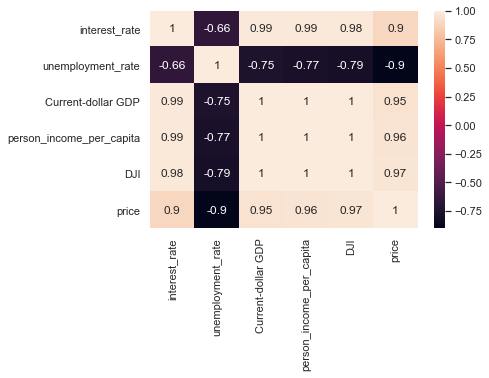

In [99]:
def corr_chicago_data_price(start=2016, end=2019):
    price = All_zipcodes_yearly_data_merged.groupby('year')[['price']].mean()
    df = pd.merge(chicago_econ_data_yearly, price, how='inner', right_index=True, left_index=True)
    df = df[(df.index>=start) & (df.index<=end)]
    sns.heatmap(df.corr(), annot=True)
corr_chicago_data_price()

In [100]:
#saving chicago economy data
"""with open ('chicago_econ_data', 'wb') as f:
    dill.dump(chicago_econ_data,f)"""

"with open ('chicago_econ_data', 'wb') as f:\n    dill.dump(chicago_econ_data,f)"